In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
from scipy.integrate import quad
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import copy
import calendar
from optimise_GDD_fctns import * #Phenology_set, run_GDD_and_get_RMSE, run_GDD_and_get_RMSE_derivs, plot_profiles_at_minimum, get_station_locations, put_ERA5_in_array

#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [4]:
def run_GDD(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid', 
                             phase_list = ['beginning of flowering'], exclude_unfinished = False,
                             growing_period_length = 300, thresholds = [100], 
                             title_extra='', method='scatter', savename = False, plot=False):
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], 0.2, 3)#x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
    elif response_type == 'Convolved':
        table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 7, 3)#, x[4], x[5])#x[2]
        def response(meantemp):
            return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)

    driver_columns = [f'{driver_variable} at day {day}' for day in range(growing_period_length)]
    ds_for_model = ds[driver_columns + ['year', 'Stations_id']].copy()
    #ds_for_model.loc[:, driver_columns] = ds_for_model.loc[:, driver_columns]#.round(decimals = 10).astype(np.float64)
    ds_for_model.loc[:, driver_columns] = response(ds_for_model[[f'{driver_variable} at day {day}' for day in range(growing_period_length)]]).cumsum(axis=1)
    model_dev_time_series = ds_for_model.values.T
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['year'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['year', 'Stations_id']).dropna(how='all')
    if plot:
        plot_from_comparison_array(comparison_array, title_extra=title_extra, method=method, savename=savename, 
                                  phase_list=phase_list, exclude_unfinished=exclude_unfinished, growing_period_length=growing_period_length)
    return comparison_array

In [40]:
station_data1 = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
station_data2 = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Sofortmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
station_data = pd.concat([station_data1, station_data2], axis=0)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_23896\1139828079.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data1 = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_23896\1139828079.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data2 = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Sofortmelder.txt"

In [5]:
def stoch_GDD_simulation(x, ds, driver_variable = 'temperature', latlon_proj = True, response_type = 'Wang', scale_param = 1,
                             phase_list = ['beginning of flowering'], exclude_unfinished = False,
                             growing_period_length = 300, thresholds = [20], 
                             title_extra='', method='scatter', savename = False, plot=False):
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], 0.2, 3)#x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
    elif response_type == 'Convolved':
        table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 2.5, 5)#, x[4], x[5])#x[2]
        def response(meantemp):
            return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
    ds_for_model = ds.copy()
    driver_columns = [f'{driver_variable} at day {day}' for day in range(growing_period_length)]
    #ds_for_model.loc[:, driver_columns] = ds_for_model.loc[:, driver_columns]#.round(decimals = 10).astype(np.float64)
    ds_for_model.loc[:, driver_columns] = response(ds_for_model[[f'{driver_variable} at day {day}' for day in range(growing_period_length)]]).cumsum(axis=1)
    ds_for_model.loc[:, driver_columns] = 1 / (1 + np.exp( - scale_param * ( ds_for_model[driver_columns] - thresholds[0] ) ))
    first_prob = ds_for_model[[f'{driver_variable} at day 0']]
    ds_for_model.loc[:, driver_columns] = ds_for_model[driver_columns].diff(axis=1)#.fillna(ds_for_model[[f'{driver_variable} at day 0']])
    ds_for_model.loc[:, f'{driver_variable} at day 0'] = first_prob
    ds_for_model.loc[:, driver_columns] = ds_for_model.loc[:, driver_columns].apply(lambda x: x.div(x.sum()), axis = 1)
    #ds_for_model.loc[:, driver_columns] = ds_for_model[driver_columns].div(ds_for_model[driver_columns].sum(axis=1), axis=0)
    ds_for_model.loc[:, 'modelled time to flowering'] = ds_for_model.loc[:, driver_columns].apply(lambda x: np.random.choice(growing_period_length, p = x), axis = 1)
    return ds_for_model

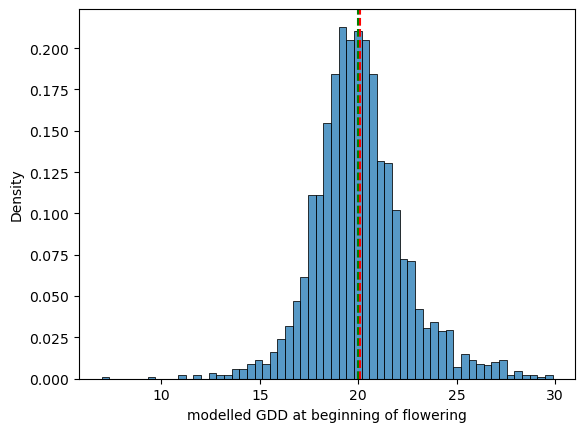

In [ ]:
x0 = [0.34525542, 7.00219008, 23.57229066, 39.02041395]
#ds_inputs_DE_early['observed time to beginning of flowering'] = ds_inputs_DE_early['observed time to beginning of flowering'].dt.days
cf = run_GDD_transformed_space(x0, ds_inputs_DE_early, driver_variable='t2m', response_type='Wang',
                               phase_list=['beginning of flowering'], exclude_unfinished=False,
                             growing_period_length=300, thresholds=[20])
fig, ax = plt.subplots()
sns.histplot(x='modelled GDD at beginning of flowering', data=cf, label='modelled days to anthesis',
             stat='density', ax=ax)
ax.axvline(x=cf['modelled GDD at beginning of flowering'].mean(), color='red', linestyle='--', label='mean modelled GDD')
ax.axvline(x=20, color='green', linestyle='--', label='threshold for beginning of flowering')

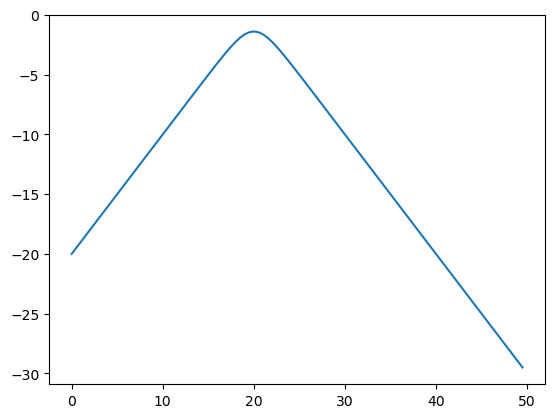

In [7]:
vals = np.arange(0, 50, 0.5)
thresholds = [20]
fig, ax = plt.subplots()
ax.plot(vals, -(vals - thresholds[0]) - 2 * np.log(1 + np.exp(-(vals - thresholds[0]))))

In [6]:
def run_GDD_transformed_space_error3(x, ds, driver_variable, latlon_proj = True, 
                                     response_type = 'Trapezoid', phase_list = ['beginning of flowering'], 
                                     exclude_unfinished = False,
                                     growing_period_length = 300, thresholds = [100], 
                                     new_unfinished_penalisation=False, alpha = 0.5):
    comparison_array = run_GDD_transformed_space(x, ds, driver_variable, latlon_proj=latlon_proj,
                               response_type=response_type, phase_list=phase_list,
                                 growing_period_length=growing_period_length, thresholds=thresholds)
    phase = phase_list[0]
    likelihoods =  1 / (1 + np.exp(- (alpha * (comparison_array[f'modelled GDD at {phase}'] - thresholds[0])))) - 1 / (1 + np.exp(- ( alpha * (comparison_array[f'modelled GDD before {phase}'] - thresholds[0]))))
    return - np.log(likelihoods[likelihoods>0.0001]).mean()

In [7]:
def run_GDD_transformed_space_error4(x, ds, driver_variable, latlon_proj = True, 
                                     response_type = 'Trapezoid', phase_list = ['beginning of flowering'], 
                                     exclude_unfinished = False,
                                     growing_period_length = 300, thresholds = [100], 
                                     new_unfinished_penalisation=False):
    comparison_array = run_GDD_transformed_space(x, ds, driver_variable, latlon_proj=latlon_proj,
                               response_type=response_type, phase_list=phase_list,
                                 growing_period_length=growing_period_length, thresholds=thresholds)
    phase = phase_list[0]
    return (((comparison_array[f'modelled GDD at {phase}'] - thresholds[0])**2).mean())

In [8]:
def run_GDD_supplemented_error(x, ds, driver_variable, latlon_proj = True, 
                                     response_type = 'Trapezoid', phase_list = ['beginning of flowering'], 
                                     exclude_unfinished = False,
                                     growing_period_length = 300, thresholds = [100], 
                                     new_unfinished_penalisation=False):
    bias_error = run_GDD_transformed_space_error4(x, ds, driver_variable, latlon_proj=latlon_proj,
                               response_type=response_type, phase_list=phase_list,
                                  growing_period_length=growing_period_length, thresholds=thresholds)
    RMSE_error = run_GDD_and_get_RMSE(x, ds, driver_variable, latlon_proj=latlon_proj,
                               response_type=response_type, phase_list=phase_list,
                               new_unfinished_penalisation=new_unfinished_penalisation,
                               growing_period_length=growing_period_length, thresholds=thresholds)
    return RMSE_error + 0.1*bias_error


In [9]:
def local_opt(x1s, train, test, error_fctn = run_GDD_and_get_RMSE, lower_bounds = [0.05, 4, 20, 20, 35], upper_bounds = [1, 12, 35, 35, 60], #ds
              great_threshold = 13, response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
              method = 'trust-constr', modified_cost = False, thresholds = [100], growing_period_length = 185,
              maxiter = 50, split = True, CCNN_split = False, test_size = 0.5, random_state=1, itr = 0.5, bias_term = False):
    #if split:
    #    train, test = train_test_split(ds, test_size=test_size, random_state = random_state)
    #    #train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
    #elif CCNN_split:
    #    test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
    #    train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    complement_indices = ds.index.difference(test.index)
    #
    #    # Filter df2 to keep only the rows with the complement indices
    #    train = ds.loc[complement_indices]
    #    #train = pd.merge(ds, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #else:
    #    train = ds
    #    test = ds
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[4] - x[3]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0],
                                                [0, 0, -1, 1, 0],
                                                [0, 0, 0, -1, 1]])}
        constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
    elif response_type == 'Wang' or response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        if bias_term:
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0]]),lb= [0, 0], ub=[1000, 1000])
        else:  
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0, 0], [0, 0, -1, 1, 0, 0]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Spline':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2],
                                                x[3]]),
                    'jac' : lambda x: np.array([[0 for count in range(20)],
                                                [0 for count in range(20)]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0 for count in range(20)], [0 for count in range(20)]]),lb= [-1, -1], ub=[1000, 1000])
    bounds = scipy.optimize.Bounds(lb=lower_bounds, ub = upper_bounds)
    x0 = np.array([1, 4, 25, 35, 45])
    final_mins = []
    for x0 in x1s:
        if method == 'trust-constr':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list, 
                                                                         new_unfinished_penalisation=modified_cost, 
                                                                         growing_period_length = growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'trust-constr',#'COBYQA',
                                    jac='3-point',#
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', #jac='3-point',#[x0/1000 for x0 in 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#
                                    constraints=[constraints],
                                    options={'verbose': 3, 'initial_tr_radius': itr, 'xtol':1e-7, 'maxiter':maxiter},# ,'gtol':1e-7, 'finite_diff_rel_step': 0.05
                                    bounds=bounds, tol=1e-9)
        elif method == 'SLSQP':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'SLSQP',
                                    #jac = '3-point',
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#jac='3-point',#
                                    constraints=[ineq_cons],
                                    options={'disp': 3, 'maxiter':maxiter, 'ftol': 1e-16},
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Nelder-Mead':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Nelder-Mead',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Powell':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Powell',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)
        print(x0, res.x, x0 - res.x)
        RMSE = error_fctn(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds)
        #print('R^2: ', r2_score(c_array[f'observed time to {only_phase}'], c_array[f'modelled time to {only_phase}']))
        print('RMSE at opt on test set: ', RMSE)
        print('R^2:', 1 - (RMSE**2/(test[f'observed time to {only_phase}'].var()*((len(test) - 1)/len(test)))))
        final_mins.append(res.x)
    return final_mins, res, train, test

In [10]:
def KFold_crossval(ds, k_folds, method = 'Nelder-Mead'):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    statyear = ds[['Stations_id', 'Referenzjahr']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner')

        x1s = [np.array([0.5, 8, 28, 39])]
        print(f'Fold {fold + 1}')
        fm = local_opt(x1s, train, 
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method=method,
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.02)
        print('Parameters: ', fm)

        comparison_array = run_GDD_and_plot(fm[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')
        comparison_array['Error'] = comparison_array['observed time to beginning of flowering'] - comparison_array['modelled time to beginning of flowering']

        r2_score_model = r2_score(comparison_array['observed time to beginning of flowering'], comparison_array['modelled time to beginning of flowering'])
        bias_model = (comparison_array['Error']).mean()
        variance = comparison_array['modelled time to beginning of flowering'].var()

        RMSE = np.sqrt(np.mean((comparison_array['Error'] - bias_model)**2))
        STD = comparison_array['modelled time to beginning of flowering'].std() 
        Corr = comparison_array['observed time to beginning of flowering'].corr(comparison_array['modelled time to beginning of flowering'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_array['Error'].min())
        LQs.append(comparison_array['Error'].quantile(0.25))
        Medians.append(comparison_array['Error'].median())
        UQs.append(comparison_array['Error'].quantile(0.75))
        Maxs.append(comparison_array['Error'].max())

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [11]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [57]:
ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE1=ds_inputs_DE1.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE1))
ds_inputs_DE1 = ds_inputs_DE1.dropna(how='all')
print(len(ds_inputs_DE1))
ds_inputs_DE1 = ds_inputs_DE1.loc[ds_inputs_DE1['observed time to beginning of flowering'] < 200]
ds_inputs_DE1 = ds_inputs_DE1.loc[ds_inputs_DE1['observed time to beginning of flowering'] > 40]
ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')
ds_inputs_DE2=ds_inputs_DE2.rename(columns={'Referenzjahr':'year'})
ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], ignore_index=True).drop_duplicates()

15308
15308


In [ ]:
#ds_inputs_DE.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5.csv')

In [12]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5.csv')

In [13]:
for vble in ['photoperiod', 'DTF', 'dev stage', 'vpd', 'ssrd', 't2max', 't2min', 'tp']:
    ds_inputs_DE = ds_inputs_DE.drop(columns = [col for col in ds_inputs_DE.columns if vble in col])

In [29]:
ds_inputs_DE['FAO_sort'].fillna(-999).value_counts()#[:10]

FAO_sort
-999.0    12318
 220.0     2876
 240.0     2194
 210.0     1938
 230.0     1722
 250.0     1499
 225.0      616
 260.0      484
 200.0      390
 255.0      361
 235.0      319
 280.0      212
 245.0      199
 300.0      193
 215.0      183
 270.0      153
 190.0      129
 290.0       93
 180.0       77
 265.0       70
 205.0       68
 275.0       45
 320.0       21
 310.0       19
 216.0       11
 305.0        3
 285.0        2
 340.0        2
 219.0        2
 195.0        2
 350.0        2
 330.0        2
 175.0        1
 185.0        1
 170.0        1
Name: count, dtype: int64

In [33]:
for code in range(80, 90):
    print(ds_inputs_DE.loc[ds_inputs_DE['Naturraumgruppe_Code'] == code, 'Naturraumgruppe'].unique())

['Odertal']
['Mittelbrandenburgische Platten und Niederungen']
['Ostbrandenburgisches Heide- und Seengebiet']
['Spreewald']
['Lausitzer Becken- und Heideland']
['Fläming']
['Altmark']
['Elbtalniederung']
['Elbe-Mulde-Tiefland']
['Oberlausitzer Heideland']


<Axes: xlabel='Naturraumgruppe_Code', ylabel='Count'>

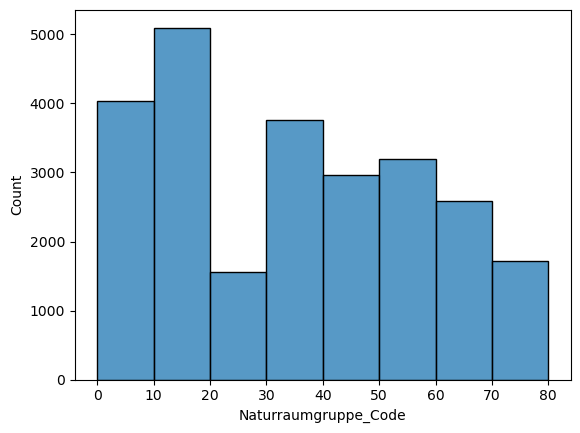

In [18]:
sns.histplot(ds_inputs_DE['Naturraumgruppe_Code'], bins = np.arange(0, 90, 10))

In [11]:
def optimise_and_plot_nature_regions(ds):
    x1s = [np.array([0.5, 8, 23, 39])]#28
    fm_varieties = []
    comparison_array_varieties = []
    for i, nature_code in enumerate([0, 10, 20, 30, 40, 50, 60, 70]):
        title_extra = ['Alpine', 'Saarland/black forest', 'Rheinland', 'Harz mountains/middle German mountains', 'Saxony/Thuringia hills', 'Middle Germany', 'Marsh/moor', 'Baltic coast region', 'Brandenburg'][i]
        print(nature_code, title_extra)
        ds_inputs_region = ds.loc[ds_inputs_DE['Naturraumgruppe_Code'] // 10 == nature_code // 10]
        train, test = train_test_split(ds_inputs_region, test_size=0.2, random_state = 1)#fm_variety[-2:]#
        fm_variety = local_opt(x1s, train, test,# ds_variety, 
                            lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                            great_threshold = 13, response_type = 'Wang',
                            phase_list = ['beginning of flowering'],
                            method='Nelder-Mead',
                            thresholds = [20], growing_period_length=300,
                            test_size = 0.2, random_state=1)
        print(fm_variety[0][0])
        comparison_array_variety = run_GDD(fm_variety[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                            thresholds = [20], title_extra=title_extra, method = 'regression', plot=True)
        fm_varieties.append(fm_variety)
        comparison_array_varieties.append(comparison_array_variety)
    return fm_varieties, comparison_array_varieties

0 Alpine
Optimization terminated successfully.
         Current function value: 8.091549
         Iterations: 89
         Function evaluations: 193
[ 0.5  8.  23.  39. ] [ 0.30788134  7.0287006  22.11020556 38.65221434] [0.19211866 0.9712994  0.88979444 0.34778566]
RMSE at opt on test set:  7.951309644456989
R^2: 0.3920913399007814
[ 0.30788134  7.0287006  22.11020556 38.65221434]
0 stations out of 806 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3920913399007815
Bias: 0.007117832139845538 (sign 1.0)
Variance of modelled values: 45.554035725844884
10 Saarland/black forest
Optimization terminated successfully.
         Current function value: 8.508681
         Iterations: 96
         Function evaluations: 213
[ 0.5  8.  23.  39. ] [ 0.33065302  7.75222282 23.02192943 38.83583677] [ 0.16934698  0.24777718 -0.02192943  0.16416323]
RMSE at opt on test set:  8.53562316091204
R^2: 0.3762895248722802
[ 0.33065302  7.75222282 23.02192943 38.83583677]
0 station

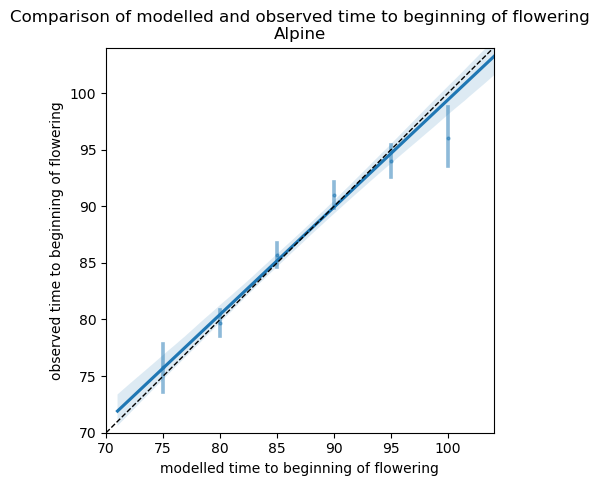

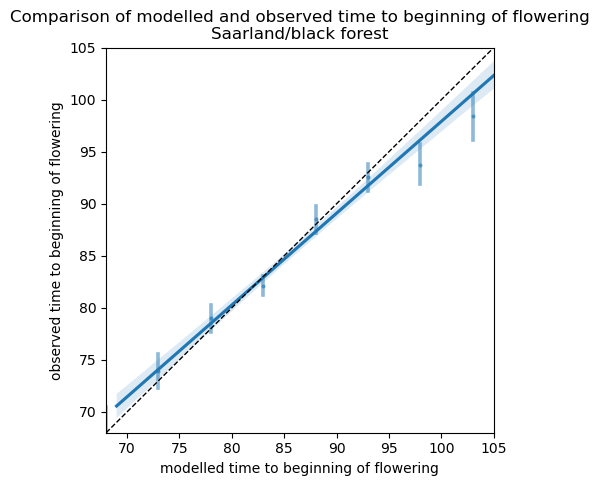

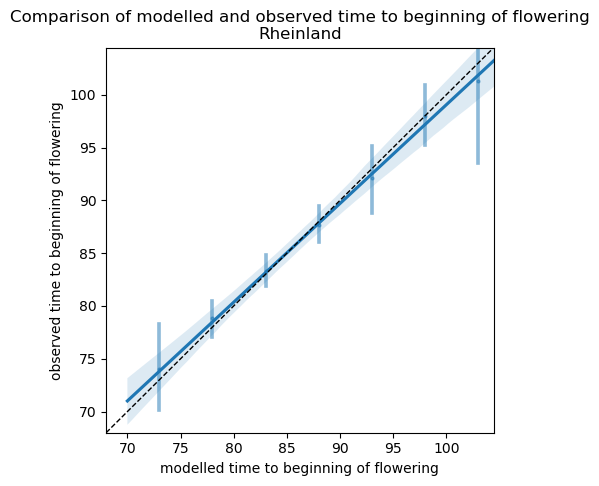

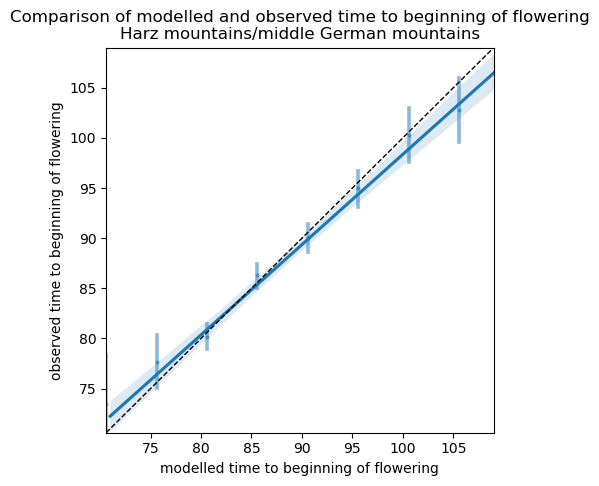

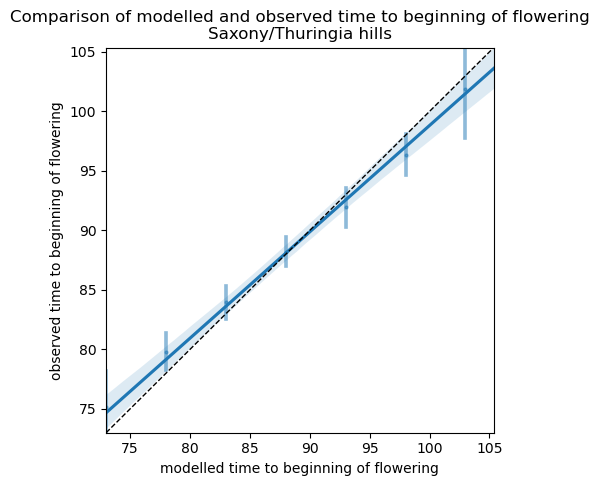

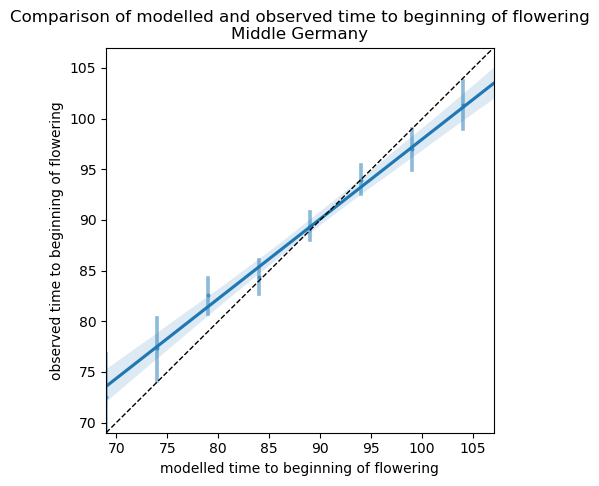

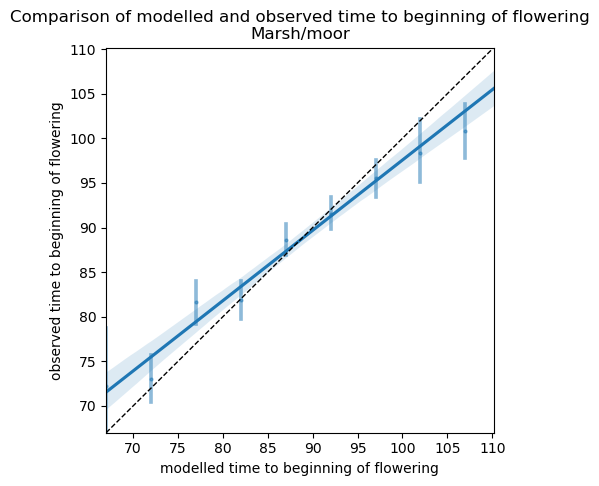

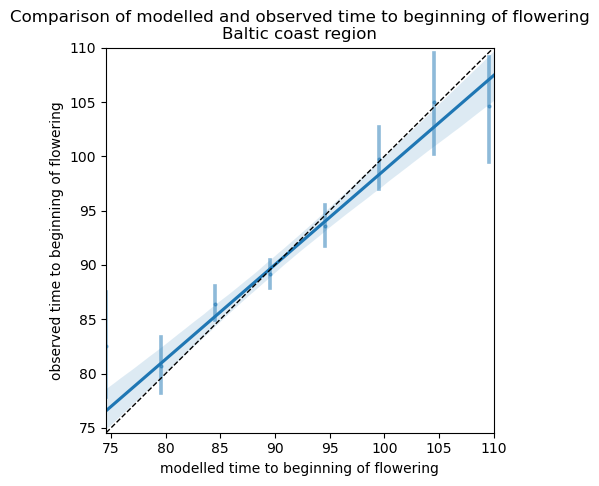

In [55]:
fm_varieties, comparison_array_varieties = optimise_and_plot_nature_regions(ds_inputs_DE)
    

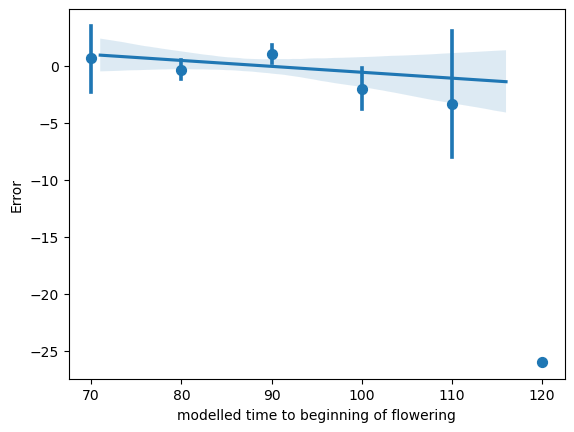

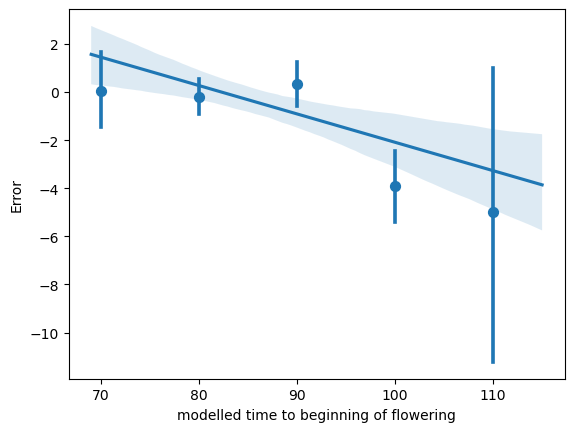

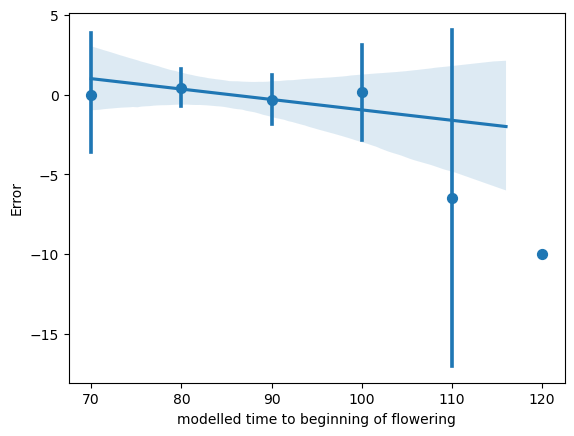

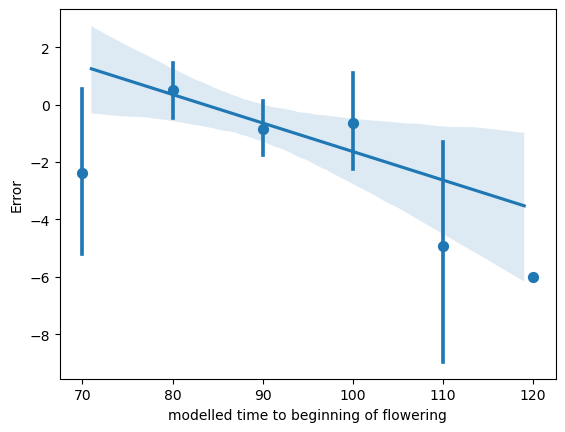

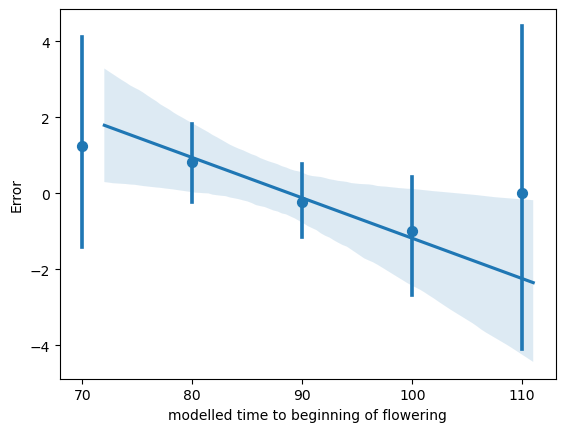

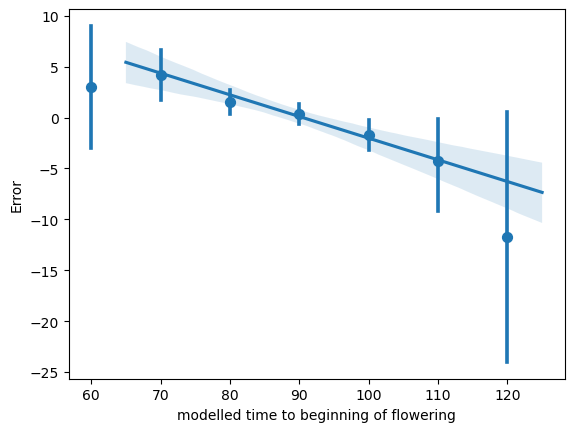

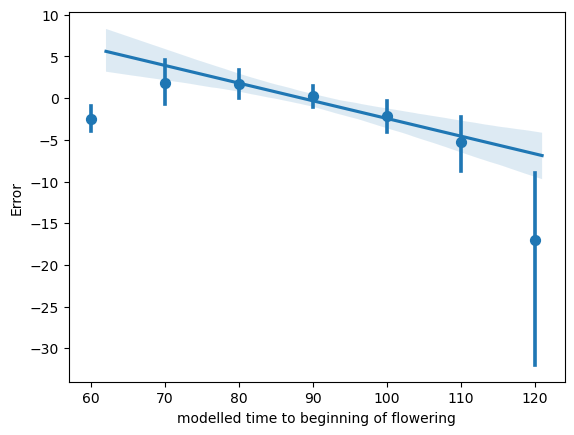

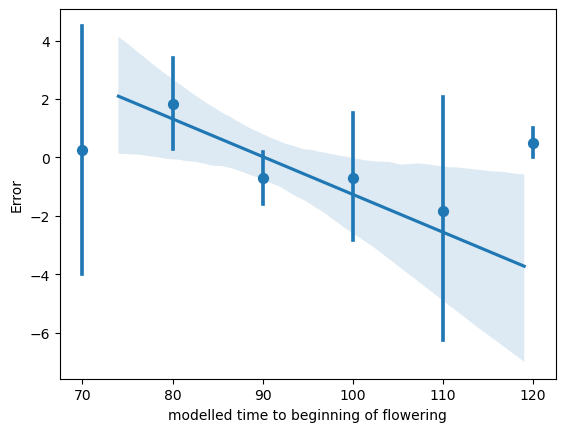

In [57]:
for ca in comparison_array_varieties:
    ca['Error'] = ca['observed time to beginning of flowering'] - ca['modelled time to beginning of flowering']
    fig, ax = plt.subplots()
    sns.regplot(x='modelled time to beginning of flowering', y='Error', data=ca, x_bins = np.arange(40, 200, 10))

In [61]:
ca_full = pd.concat(comparison_array_varieties, ignore_index=True)

<Axes: xlabel='modelled time to beginning of flowering', ylabel='Error'>

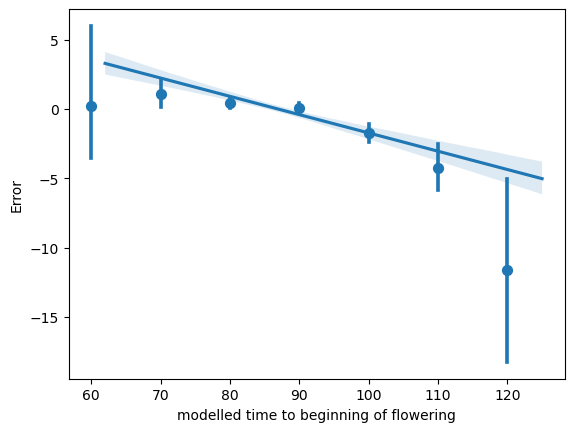

In [62]:
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=ca_full, x_bins = np.arange(40, 200, 10))

In [59]:
ds_inputs_DE = ds_inputs_DE.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_DE = ds_inputs_DE.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering'], 'D').dt.days#, 'D'

In [18]:
FAO_sorts_string = ds_inputs_DE['SORTE'].str.split(' ').str.get(-1)
FAO_sorts_string = FAO_sorts_string*(1 - FAO_sorts_string.str.contains(r'[a-zA-Z]', regex=True))
FAO_sorts_string.replace('', np.nan, inplace = True)
FAO_sorts_string.fillna(0, inplace=True)
FAO_sorts_string = FAO_sorts_string.astype(np.int64)
ds_inputs_DE['FAO_sort'] = FAO_sorts_string

In [21]:
ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'FAO_sort'] = (ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'SILOREIFEZAHL'] + ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'KOERNERREIFEZAHL'])/2

In [62]:
early_threshold = 220
ei_threshold = 225
il_threshold = 250
ds_inputs_DE_early = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] > 0)*(ds_inputs_DE['FAO_sort'] < early_threshold)]
print(len(ds_inputs_DE_early))
ds_inputs_DE_ei = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] >= early_threshold)*(ds_inputs_DE['FAO_sort'] <= ei_threshold)]
print(len(ds_inputs_DE_ei))
ds_inputs_DE_il = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] > ei_threshold)*(ds_inputs_DE['FAO_sort'] < il_threshold)]
print(len(ds_inputs_DE_il))
ds_inputs_DE_late = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] >= il_threshold)]
print(len(ds_inputs_DE_late))


2803
3492
4434
3161


In [12]:
def optimise_and_plot_varieties(ds, thresholds):
    early_threshold = thresholds[0]
    ei_threshold = thresholds[1]
    il_threshold = thresholds[2]
    ds_early = ds.loc[(ds['FAO_sort'] > 0)*(ds['FAO_sort'] < early_threshold)]
    print(len(ds_early), ' in early category')
    ds_ei = ds.loc[(ds['FAO_sort'] >= early_threshold)*(ds['FAO_sort'] <= ei_threshold)]
    print(len(ds_ei), ' in early intermediate category')
    ds_il = ds.loc[(ds['FAO_sort'] > ei_threshold)*(ds['FAO_sort'] < il_threshold)]
    print(len(ds_il), ' in intermediate late category')
    ds_late = ds.loc[(ds['FAO_sort'] >= il_threshold)]
    print(len(ds_late), ' in late category')
    x1s = [np.array([0.5, 8, 23, 39])]#28
    print('Optimising early varieties')
    fm_varieties = []
    comparison_array_varieties = []
    for i, ds_variety in enumerate([ds_early, ds_ei, ds_il, ds_late]):
        title_extra = ['Early varieties', 'Early intermediate varieties', 'Intermediate late varieties', 'Late varieties'][i]
        train, test = train_test_split(ds_variety, test_size=0.2, random_state = 1)#fm_variety[-2:]#
        fm_variety = local_opt(x1s, train, test,# ds_variety, 
                            lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                            great_threshold = 13, response_type = 'Wang',
                            phase_list = ['beginning of flowering'],
                            method='Nelder-Mead',
                            thresholds = [20], growing_period_length=300,
                            test_size = 0.2, random_state=1)
        print(fm_variety[0][0])
        comparison_array_variety = run_GDD(fm_variety[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                            thresholds = [20], title_extra='Early varieties', method = 'regression', plot=True)
        fm_varieties.append(fm_variety)
        comparison_array_varieties.append(comparison_array_variety)
    return fm_varieties, comparison_array_varieties

In [75]:
print('Early varieties mean flowering time: ', ds_inputs_DE_early['observed time to beginning of flowering'].dt.days.mean(),
      '\nEarly intermediate varieties mean flowering time: ', ds_inputs_DE_ei['observed time to beginning of flowering'].dt.days.mean(),
      '\nIntermediate late varieties mean flowering time: ', ds_inputs_DE_il['observed time to beginning of flowering'].dt.days.mean(),
      '\nLate varieties mean flowering time: ', ds_inputs_DE_late['observed time to beginning of flowering'].dt.days.mean())

Early varieties mean flowering time:  88.29004637887977 
Early intermediate varieties mean flowering time:  87.86454753722795 
Intermediate late varieties mean flowering time:  86.93820478123591 
Late varieties mean flowering time:  85.77886744701044


In [82]:
print('Early varieties mean planting date: ', pd.to_datetime(ds_inputs_DE_early['Planting date']).dt.dayofyear.mean(),
      '\nEarly intermediate varieties mean planting date: ', pd.to_datetime(ds_inputs_DE_ei['Planting date']).dt.dayofyear.mean(),
      '\nIntermediate late varieties mean planting date: ', pd.to_datetime(ds_inputs_DE_il['Planting date']).dt.dayofyear.mean(),
      '\nLate varieties mean planting date: ', pd.to_datetime(ds_inputs_DE_late['Planting date']).dt.dayofyear.mean())

Early varieties mean planting date:  119.5693899393507 
Early intermediate varieties mean planting date:  118.8479381443299 
Intermediate late varieties mean planting date:  117.94136220117275 
Late varieties mean planting date:  117.12496045555204


In [84]:
print('Early varieties mean flowering date: ', pd.to_datetime(ds_inputs_DE_early['Planting date']).dt.dayofyear.mean() + ds_inputs_DE_early['observed time to beginning of flowering'].dt.days.mean(),
        '\nEarly intermediate varieties mean flowering date: ', pd.to_datetime(ds_inputs_DE_ei['Planting date']).dt.dayofyear.mean() + ds_inputs_DE_ei['observed time to beginning of flowering'].dt.days.mean(),
        '\nIntermediate late varieties mean flowering date: ', pd.to_datetime(ds_inputs_DE_il['Planting date']).dt.dayofyear.mean() + ds_inputs_DE_il['observed time to beginning of flowering'].dt.days.mean(),
        '\nLate varieties mean flowering date: ', pd.to_datetime(ds_inputs_DE_late['Planting date']).dt.dayofyear.mean() + ds_inputs_DE_late['observed time to beginning of flowering'].dt.days.mean())

Early varieties mean flowering date:  207.85943631823045 
Early intermediate varieties mean flowering date:  206.71248568155784 
Intermediate late varieties mean flowering date:  204.87956698240868 
Late varieties mean flowering date:  202.90382790256248


In [71]:
fm_flowering_all_DE5

([array([ 0.38441275,  7.07110641, 24.11864933, 38.5       ,  1.21540003])],
        message: Optimization terminated successfully.
        success: True
         status: 0
            fun: 8.323929835512903
              x: [ 3.844e-01  7.071e+00  2.412e+01  3.850e+01  1.215e+00]
            nit: 189
           nfev: 337
  final_simplex: (array([[ 3.844e-01,  7.071e+00, ...,  3.850e+01,
                          1.215e+00],
                        [ 3.844e-01,  7.071e+00, ...,  3.850e+01,
                          1.215e+00],
                        ...,
                        [ 3.844e-01,  7.071e+00, ...,  3.850e+01,
                          1.215e+00],
                        [ 3.844e-01,  7.071e+00, ...,  3.850e+01,
                          1.215e+00]], shape=(6, 5)), array([ 8.324e+00,  8.324e+00,  8.324e+00,  8.324e+00,
                         8.324e+00,  8.324e+00])),
        Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Planting date  year  \
 18040         18040          2737    

In [72]:
scale_values = np.arange(0.2, 0.6, 0.0125)
T_opt_values = np.arange(20, 30, 0.125)
scales, T_opts = np.meshgrid(scale_values, T_opt_values)
RMSE2s = np.zeros(T_opts.shape)
for i in range(T_opts.shape[0]):
    print(T_opt_values[i])
    for j in range(T_opts.shape[1]):
        RMSE2s[i, j] = run_GDD_and_get_RMSE_bias_term(np.array([scales[i, j], 7.5, T_opts[i, j], 39, 1.215*4]), ds_inputs_DE_reduced, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], growing_period_length=300, 
                                            thresholds = [20])

20.0
20.125
20.25
20.375
20.5
20.625
20.75
20.875
21.0
21.125
21.25
21.375
21.5
21.625
21.75
21.875
22.0
22.125
22.25
22.375
22.5
22.625
22.75
22.875
23.0
23.125
23.25
23.375
23.5
23.625
23.75
23.875
24.0
24.125
24.25
24.375
24.5
24.625
24.75
24.875
25.0
25.125
25.25
25.375
25.5
25.625
25.75
25.875
26.0
26.125
26.25
26.375
26.5
26.625
26.75
26.875
27.0
27.125
27.25
27.375
27.5
27.625
27.75
27.875
28.0
28.125
28.25
28.375
28.5
28.625
28.75
28.875
29.0
29.125
29.25
29.375
29.5
29.625
29.75
29.875


In [13]:
scale_values = np.arange(0.2, 0.6, 0.025)#125
T_opt_values = np.arange(22, 30, 0.25)#125
#scale_values = np.arange(0.2, 0.6, 0.025)#125
#T_opt_values = np.arange(20, 30, 0.25)#125
scales, T_opts = np.meshgrid(scale_values, T_opt_values)
RMSE2s = np.zeros(T_opts.shape)
for i in range(T_opts.shape[0]):
    print(T_opt_values[i])
    for j in range(T_opts.shape[1]):
        RMSE2s[i, j] = run_GDD_and_get_RMSE(np.array([scales[i, j], 7.5, T_opts[i, j], 39, 1.215*4]), ds_inputs_DE_reduced, 't2m', response_type='Convolved', phase_list = ['beginning of flowering'], growing_period_length=300, 
                                            thresholds = [20])

22.0
22.25
22.5
22.75
23.0
23.25
23.5
23.75
24.0
24.25
24.5
24.75
25.0
25.25
25.5
25.75
26.0
26.25
26.5
26.75
27.0
27.25
27.5
27.75
28.0
28.25
28.5
28.75
29.0
29.25
29.5
29.75


In [16]:
RMSE3s = RMSE2s.copy()
RMSE3s[RMSE2s > 15] = np.nan

8.372788449339797 T_opt1 = 29.75 scale = 0.575


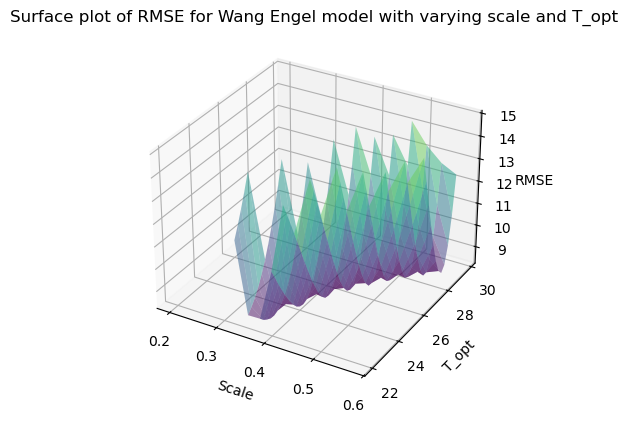

In [17]:
fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(scales, T_opts, RMSE3s, cmap='viridis', alpha = 0.5)#[3:-3, 4:]
ax.set(xlabel = 'Scale')
ax.set(ylabel = 'T_opt')
ax.set_title('Surface plot of RMSE for Wang Engel model with varying scale and T_opt')
ax.set(zlabel = 'RMSE')
mindex = np.unravel_index(np.argmin(RMSE2s), T_opts.shape)
mindex = (-1, -1)
#ax.scatter(scales[mindex], T_opts[mindex], RMSE2s[mindex], color = 'red', s=20)
print(RMSE2s.min(), f'T_opt1 = {T_opts[mindex]}', f'scale = {scales[mindex]}')


# Make the direction data for the arrows
#derivs = run_GDD_and_get_RMSE_derivs(np.array([scales[mindex], 7.5, T_opts[mindex], 39]), ds_inputs_DE_early, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], growing_period_length=300, 
#                                            thresholds = [20])

#ax.quiver(scales[mindex], T_opts[mindex], RMSE2s[mindex], -derivs[0], -derivs[2], -3, length=1, normalize=True)

In [19]:
RMSE3s

array([[        nan,         nan,         nan,         nan,         nan,
        11.98071705,  8.82394898,  8.83923134, 11.09628011, 14.1093457 ,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
        12.50439068,  9.05063336,  8.64004192, 10.67624741, 13.58882067,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
        13.09162674,  9.3302215 ,  8.5147828 , 10.23842997, 13.06223912,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
        13.73021799,  9.69080363,  8.41993284,  9.83019704, 12.50052269,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,   

In [ ]:
scale_values = np.arange(0.2, 0.6, 0.0125)
T_opt_values = np.arange(20, 30, 0.125)
scales, T_opts = np.meshgrid(scale_values, T_opt_values)
RMSE2s = np.zeros(T_opts.shape)
for i in range(T_opts.shape[0]):
    print(T_opt_values[i])
    for j in range(T_opts.shape[1]):
        RMSE2s[i, j] = run_GDD_and_get_RMSE(np.array([scales[i, j], 7.5, T_opts[i, j], 39]), ds_inputs_DE_early, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], growing_period_length=300, 
                                            thresholds = [20])

In [56]:
RMSE3s = RMSE2s.copy()
RMSE3s[RMSE2s > 50] = np.nan

8.177678170728099 T_opt1 = 29.75 scale = 0.8749999999999998


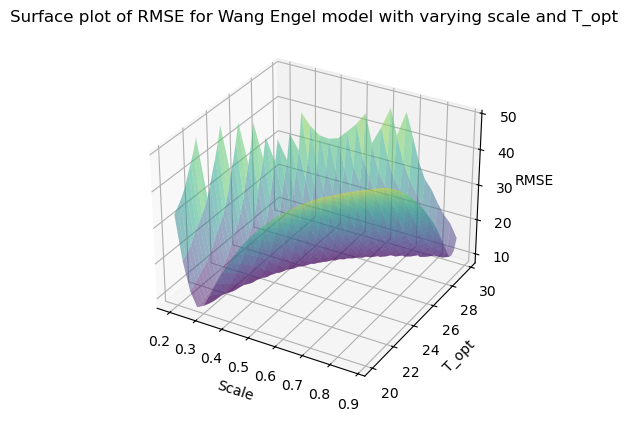

In [70]:
fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(scales, T_opts, RMSE3s, cmap='viridis', alpha = 0.5)#[3:-3, 4:]
ax.set(xlabel = 'Scale')
ax.set(ylabel = 'T_opt')
ax.set_title('Surface plot of RMSE for Wang Engel model with varying scale and T_opt')
ax.set(zlabel = 'RMSE')
mindex = np.unravel_index(np.argmin(RMSE2s), T_opts.shape)
mindex = (-1, -1)
#ax.scatter(scales[mindex], T_opts[mindex], RMSE2s[mindex], color = 'red', s=20)
print(RMSE2s.min(), f'T_opt1 = {T_opts[mindex]}', f'scale = {scales[mindex]}')


# Make the direction data for the arrows
#derivs = run_GDD_and_get_RMSE_derivs(np.array([scales[mindex], 7.5, T_opts[mindex], 39]), ds_inputs_DE_early, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], growing_period_length=300, 
#                                            thresholds = [20])

#ax.quiver(scales[mindex], T_opts[mindex], RMSE2s[mindex], -derivs[0], -derivs[2], -3, length=1, normalize=True)

2803  in early category
3492  in early intermediate category
4434  in intermediate late category
3161  in late category
Optimising early varieties
Optimization terminated successfully.
         Current function value: 8.171364
         Iterations: 76
         Function evaluations: 166
[ 0.5  8.  23.  39. ] [ 0.34790744  7.02222445 23.7504802  39.01890724] [ 0.15209256  0.97777555 -0.7504802  -0.01890724]
RMSE at opt on test set:  7.983382920294498
R^2: 0.45361327382827554
[ 0.34790744  7.02222445 23.7504802  39.01890724]
0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.453613273828277
Bias: 0.016932457637080518 (sign 1.0)
Variance of modelled values: 68.18707028265847
Optimization terminated successfully.
         Current function value: 8.343545
         Iterations: 72
         Function evaluations: 154
[ 0.5  8.  23.  39. ] [ 0.37278326  7.1090662  24.48921521 39.01028249] [ 0.12721674  0.8909338  -1.48921521 -0.01028249]
RMSE at op

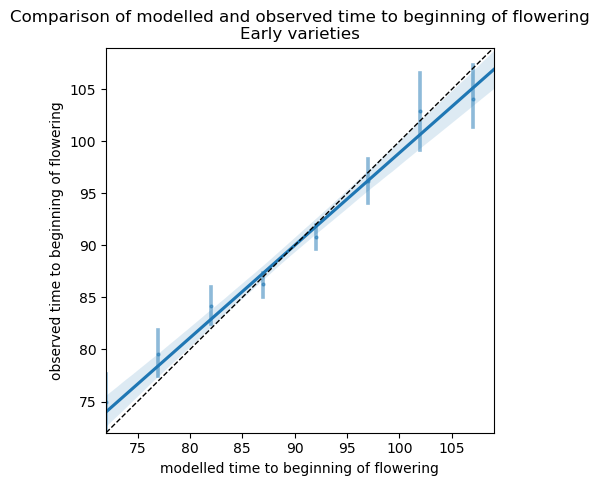

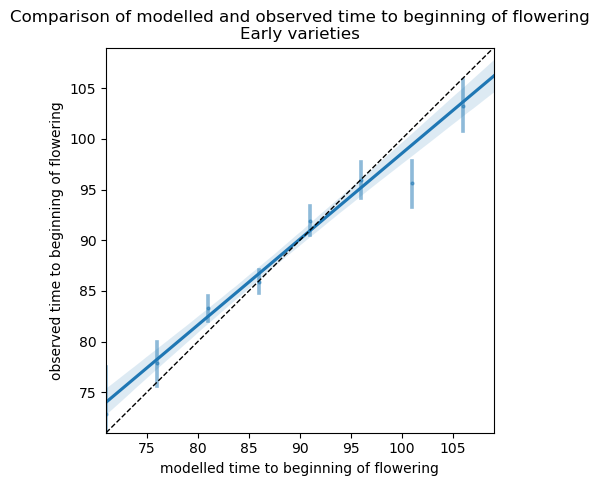

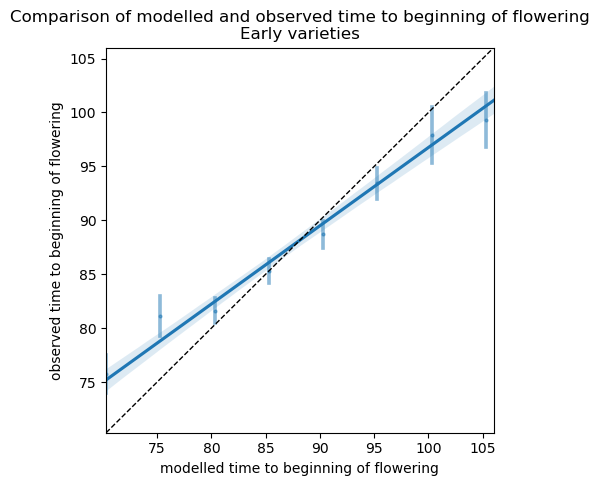

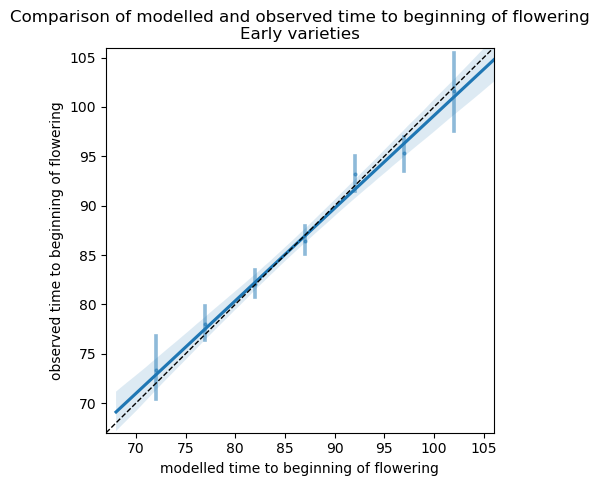

In [24]:
fm_varieties, comparison_array_varieties = optimise_and_plot_varieties(ds_inputs_DE, [220, 225, 250])

In [86]:
separate_params = pd.concat(comparison_array_varieties, ignore_index=True)

In [142]:
print(len(ds_inputs_varieties.loc[cols_in_other(ds_inputs_varieties, separate_params, ['Referenzjahr', 'Stations_id'])]),
      len(ds_inputs_varieties.loc[~cols_in_other(ds_inputs_varieties, separate_params, ['Referenzjahr', 'Stations_id'])]),
      len(ds_inputs_varieties))

2780 11110 13890


In [13]:
def cols_in_other(df1, df2, compare_cols):
    index1 = pd.MultiIndex.from_arrays([df1[col] for col in compare_cols])
    index2 = pd.MultiIndex.from_arrays([df2[col] for col in compare_cols])
    return index1.isin(index2)

In [9]:
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ERA5_pd_SOS.csv').dropna()
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024.csv')
ds_inputs_DE = ds_inputs_DE.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_DE = ds_inputs_DE.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering'], 'D')#, 'D'
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'].dt.days > 0] #30
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'].dt.days < 170]

In [10]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
ds_inputs_SSA = ds_inputs_SSA.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_SSA = ds_inputs_SSA.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering'], 'D')

In [ ]:
R2s = []
Biases = []
Variances = []

RMSEs = []
STDs = []
Corrs = []

Mins = []
LQs = []
Medians = []
UQs = []
Maxs = []

comparison_array = run_GDD_and_plot(fm_flowering_all_DE[0][0], ds_inputs_SSA, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')
comparison_array['Error'] = comparison_array['observed time to beginning of flowering'] - comparison_array['modelled time to beginning of flowering']

r2_score_model = r2_score(comparison_array['observed time to beginning of flowering'], comparison_array['modelled time to beginning of flowering'])
bias_model = (comparison_array['Error']).mean()
variance = comparison_array['modelled time to beginning of flowering'].var()

RMSE = np.sqrt(np.mean((comparison_array['Error'] - bias_model)**2))
STD = comparison_array['modelled time to beginning of flowering'].std() 
Corr = comparison_array['observed time to beginning of flowering'].corr(comparison_array['modelled time to beginning of flowering'])

RMSEs.append(RMSE)
STDs.append(STD)
Corrs.append(Corr)

Mins.append(comparison_array['Error'].min())
LQs.append(comparison_array['Error'].quantile(0.25))
Medians.append(comparison_array['Error'].median())
UQs.append(comparison_array['Error'].quantile(0.75))
Maxs.append(comparison_array['Error'].max())

R2s.append(r2_score_model)
Biases.append(bias_model)
Variances.append(variance)

error_df_transfer = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'GDD Wang Engel', 'SSA', 'Transfer DE to SSA')
error_df = pd.concat([error_df, error_df_transfer])

In [ ]:
R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = KFold_crossval(ds_inputs_DE, 5)
R2s_SSA, Biases_SSA, Variances_SSA, RMSEs_SSA, STDs_SSA, Corrs_SSA, Mins_SSA, LQs_SSA, Medians_SSA, UQs_SSA, Maxs_SSA = KFold_crossval(ds_inputs_SSA, 5)
error_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'GDD Wang Engel', 'Germany', '5-Fold')
error_df_SSA = make_error_df(R2s_SSA, Biases_SSA, Variances_SSA, RMSEs_SSA, STDs_SSA, Corrs_SSA, Mins_SSA, LQs_SSA, Medians_SSA, UQs_SSA, Maxs_SSA, 'GDD Wang Engel', 'SSA', '5-Fold')
error_df = pd.concat([error_df, error_df_SSA])#.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\GDD_Wang_Engel_5_fold_errors.csv', index = False)
error_df.to_csv('results_for_comparing/important_results/error_df.csv', index=False)

In [121]:
print(R2s_SSA)
print(Biases_SSA)
print(Variances_SSA)

[0.17091982220934743, -0.0140335876030393, 0.2162110307834869, 0.4008056394763344, 0.4381739755571531]
[np.float64(-0.5217391304347826), np.float64(-0.8913043478260869), np.float64(0.391304347826087), np.float64(0.35555555555555557), np.float64(0.0)]
[64.70531400966185, 79.9826086956522, 166.7985507246375, 48.967676767676785, 34.18181818181818]


In [55]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
x1s = [np.ones((20))]
x1s = [np.array([0, 0, 0, 0.1, 0.1, 0.2, 0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.3])]
fm_flowering_tc_DE, res = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0 for count in range(20)], upper_bounds = [100 for count in range(20)],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Spline',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 2)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24664\2816556142.py:86: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m',


Optimization terminated successfully.
         Current function value: 11.993501
         Iterations: 1049
         Function evaluations: 1518
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.00000000e+00 6.16952543e-01 0.00000000e+00 4.77769287e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.00212918e-01
 2.80976154e-02 7.94489017e-01 3.51106906e-02 6.29365910e-01
 4.65295861e-02 1.05428433e-01 7.36427971e-02 9.96488558e-01
 3.06015739e+00 4.56658766e+00 3.38213031e-02 2.98297848e-05] [ 1.00000000e+00  3.83047457e-01  1.00000000e+00  9.52223071e-01
  1.00000000e+00  1.00000000e+00  1.00000000e+00  9.97870824e-02
  9.71902385e-01  2.05510983e-01  9.64889309e-01  3.70634090e-01
  9.53470414e-01  8.94571567e-01  9.26357203e-01  3.51144234e-03
 -2.06015739e+00 -3.56658766e+00  9.66178697e-01  9.99970170e-01]
RMSE at opt on test set:  12.032528919691575
R^2: -0.29356293996124916


In [148]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
x1s = [np.ones((20))*0.3]
x1s = [x]
#x1s = [np.arra([0.58303832 0.60021864 0.62112309 0.66657544 0.60308471 0.97653708, 0.52677426 0.54452755 0.56334521 0.46919742])]
#x1s = [np.array([0, 0, 0, 0.1, 0.1, 0.2, 0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.3])]
fm_flowering_tc_DE, res = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0 for count in range(20)], upper_bounds = [100 for count in range(20)],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Spline',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [100], growing_period_length=300,
                     test_size = 0.2, maxiter = 4, random_state = 1)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  41   |   0   | +1.0178e+01 | 5.00e-01 | 4.78e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  82   |   1   | +1.2566e+01 | 3.50e+00 | 2.37e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  123  |   5   | +1.1023e+01 | 2.14e+01 | 1.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|   4   |  205  |  11   | +1.1023e+01 | 2.14e+00 | 1.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |

The maximum number of function evaluations is exceeded.
Number of iterations: 4, function evaluations: 205, CG iterations: 11, optimality: 1.14e+01, constraint violation: 0.00e+00, execution time: 5.5e+02 s.
[0.15798619 0.15823926 0.17217433 0.22564493 0.23050108 0.37851778
 0.5118658  0.54246262 0.59964448 0.59681543 0.57583808 0.61641514
 0.57285107 0.54297576 0.52831566 0.51917606 0.5154848  0.51536491
 0.4036713  0.28321193] [0.15910225 0.15935531 0.17328953 0.22675691 0.2350329  0.47261375
 0.52249516 0.55262779 0.60894212 0.60750053 0.49359567 0.61750353
 0.57394209 0.54406859 0.52940937 0.52027032 0.51657928 0.51645941
 0.40477253 0.28432044] [-0.00111606 -0.00111605 -0.00111521 -0.00111198 -0.00453183 -0.09409598
 -0.01062936 -0.01016517 -0.00929765 -0.0106851   0.08224242 -0.00108839
 -0.00109102 -0.00109283 -0.00109371 -0.00109426 -0.00109448 -0.00109449
 -0.00110123 -0.

In [122]:
x = fm_flowering_tc_DE[0]
#x = x1s[0]
def B_0(u):
    return 0.1*((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)
def response(meantemp):
    resp = 0
    for i, coeff in enumerate(x):
        resp += coeff*B_0(0.25*(meantemp - i*2))
    return np.maximum(resp, 0)
def deriv(meantemp):
    return [B_0(0.25*(meantemp - i*2)) for i in range(len(x))]

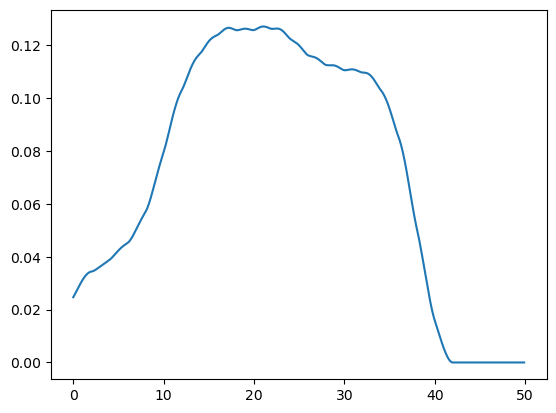

In [123]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 50, 0.1), response(np.arange(0, 50, 0.1)))

(0.0, 1.0)

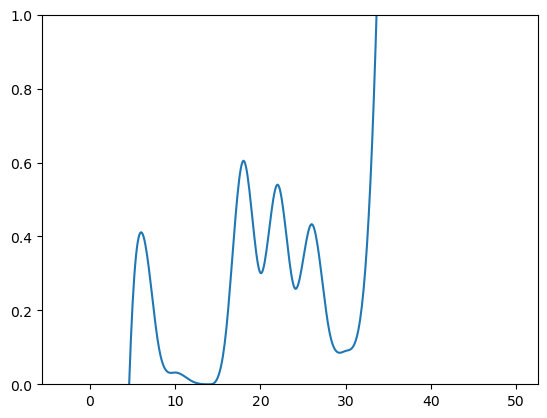

In [59]:
spl = scipy.interpolate.BSpline(np.arange(0, 40, 2), fm_flowering_tc_DE[0], 3)
fig, ax = plt.subplots()
ax.plot(np.arange(-3, 50, 0.1), spl(np.arange(-3, 50, 0.1)))
ax.set_ylim((0, 1))

In [215]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
fm_flowering_tc_DE, res = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 2)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   9   |   0   | +1.0502e+01 | 1.00e+00 | 3.49e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  18   |   1   | +1.4578e+02 | 2.00e+00 | 2.20e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  27   |   5   | +1.0607e+01 | 2.00e+00 | 1.08e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |  36   |   9   | +1.0066e+01 | 2.00e+00 | 7.38e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   5   |  45   |  13   | +9.5025e+00 | 2.00e+00 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   6   |  54   |  16   | +9.5025e+00 | 2.00e-01 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|   7   |  72   |  19   | +9.5025e+00 | 2.00e-02 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |  81   |  22   | +9.5025e+00 | 2.00e-03 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   9   |  90   |  24   | +9.5025e+00 | 6.18e-04 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  10   |  108  |  26   | +9.5025e+00 | 3.09e-04 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  11   |  117  |  27   | +9.5025e+00 | 1.18e-04 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  12   |  126  |  29   | +9.5025e+00 | 5.91e-05 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  13   |  135  |  31   | +9.5025e+00 | 1.62e-05 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  14   |  144  |  33   | +9.5021e+00 | 1.13e-04 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  15   |  162  |  34   | +9.5021e+00 | 5.67e-05 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  16   |  171  |  35   | +9.5021e+00 | 2.66e-05 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  17   |  189  |  36   | +9.5021e+00 | 5.29e-06 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  18   |  207  |  37   | +9.5021e+00 | 6.43e-07 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  19   |  225  |  38   | +9.5021e+00 | 6.43e-08 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


KeyboardInterrupt: 

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


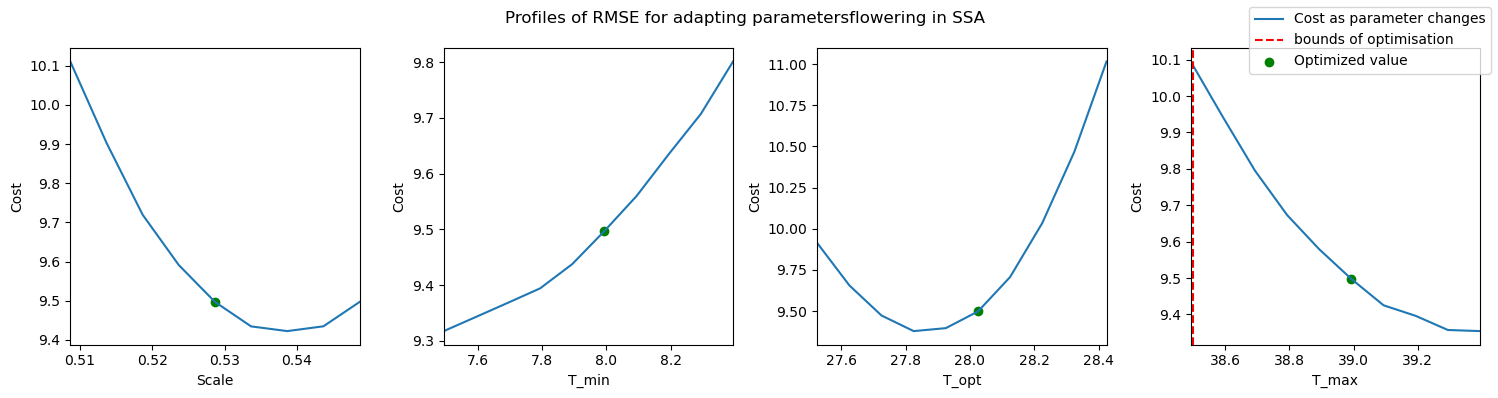

In [211]:
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_tc_DE[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5, 0.1, 0.5], ub = [5, 11, 31, 40, 5, 10], 
                         response_type = 'Convolved', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in SSA')

In [42]:
x1s = [np.array([0.5, 8, 28, 39])]#])]#, 2, 3])]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
fm_flowering_all_DE = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 21, 38], upper_bounds = [5, 11, 30, 40],#38.5, 0.1, 0.5], 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)

NameError: name 'vec_expint' is not defined

In [227]:
x1s = [np.array([0.5, 8, 28, 39, 2, 3])]#])]#, 2, 3])]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
fm_flowering_all_DE = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5, 0.1, 0.5], upper_bounds = [5, 11, 31, 40, 5, 10],#, 0.1, 0.5], 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)

Optimization terminated successfully.
         Current function value: 8.523301
         Iterations: 128
         Function evaluations: 254
[ 0.5  8.  28.  39.   2.   3. ] [ 0.36327417  7.30339085 25.         39.10537745  2.28511994  3.53223723] [ 0.13672583  0.69660915  3.         -0.10537745 -0.28511994 -0.53223723]
RMSE at opt on test set:  8.672576443417832
R^2: 0.342555551931912


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


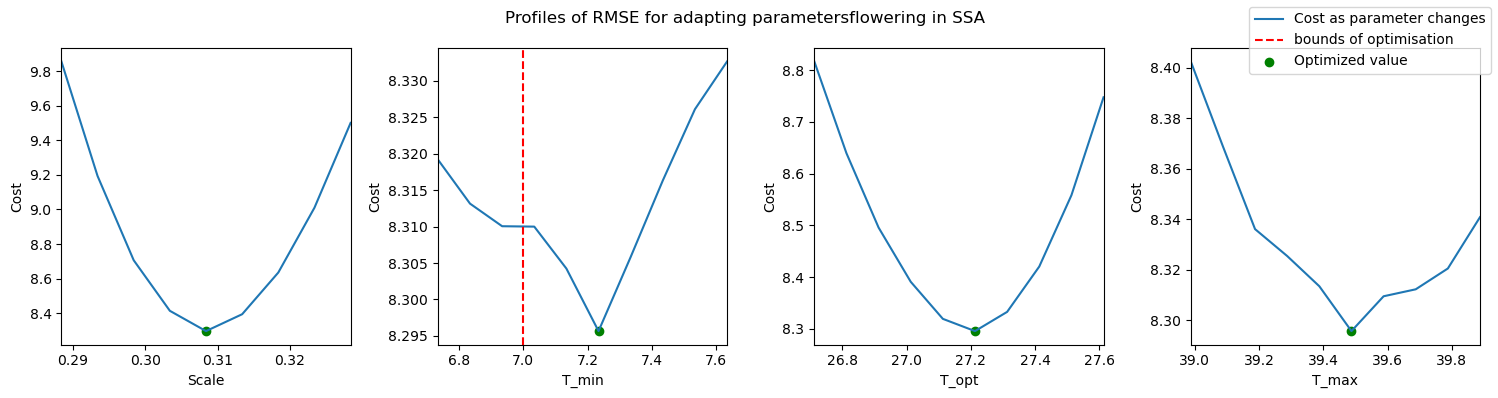

In [250]:
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5, 0.1, 0.5], ub = [5, 11, 31, 40, 5, 10], 
                         response_type = 'Convolved', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in SSA')

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


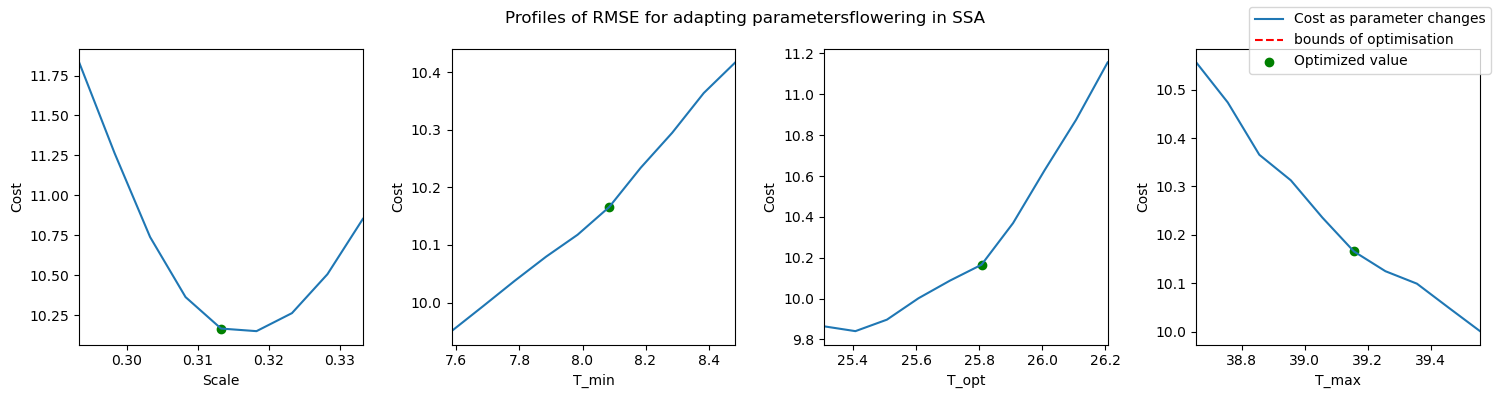

In [27]:
train_a, test_a = train_test_split(ds_inputs_SSA, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_all_SSA[0][0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in SSA')

In [92]:
x1s = [np.array([0.5, 8, 28, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
test_b = ds_inputs_varieties.loc[cols_in_other(ds_inputs_varieties, separate_params, ['Referenzjahr', 'Stations_id'])]
train_b = ds_inputs_varieties.loc[~cols_in_other(ds_inputs_varieties, separate_params, ['Referenzjahr', 'Stations_id'])]
fm_flowering_all_DE_all = local_opt(x1s, train_b, test_b,# ds_inputs_DE_early, 
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

Optimization terminated successfully.
         Current function value: 8.365664
         Iterations: 116
         Function evaluations: 233
[ 0.5  8.  28.  39. ] [ 0.3209848   7.03557583 22.5648775  38.50246086] [0.1790152  0.96442417 5.4351225  0.49753914]
RMSE at opt on test set:  8.32105330216998
R^2: 0.4318997536927227


In [69]:
run_GDD_and_get_RMSE_derivs(fm_flowering_all_DE[0][0], ds_inputs_DE_early, 't2m', response_type='Wang', 
                            phase_list = ['beginning of flowering'], growing_period_length=300,
                            thresholds = [20])

2803 2803


[np.float64(13.609922265062993),
 np.float64(-2.0302298269953267),
 np.float64(-2.4024969794180073),
 np.float64(0.6905601334438246)]

In [91]:
ds_inputs_varieties = pd.concat([ds_inputs_DE_early, ds_inputs_DE_ei, ds_inputs_DE_il, ds_inputs_DE_late], ignore_index=True)

In [121]:
np.sqrt(np.mean((c_array['modelled time to beginning of flowering'] - c_array['observed time to beginning of flowering'])**2))

np.float64(8.740362658033098)

In [170]:
x1s = [np.array([5, 8, 28, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
fm_flowering_all_DE = local_opt(x1s, train_a, test_a, error_fctn=run_GDD_transformed_space_error,# ds_inputs_DE_early, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [15, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [200], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   9   |   0   | +5.2311e+00 | 5.00e-01 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  18   |   1   | +4.2233e+00 | 3.50e+00 | 2.05e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  27   |   3   | +6.0470e+00 | 1.28e+01 | 3.56e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   4   |  36   |   5   | +3.2916e+00 | 1.28e+01 | 4.19e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   |  45   |   7   | +3.2639e+00 | 1.28e+01 | 2.38e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   6   |  54   |   9   | +3.2321e+00 | 1.28e+01 | 2.29e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |  72   |  12   | +3.2321e+00 | 1.47e+00 | 2.29e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |  81   |  14   | +3.0739e+00 | 6.01e+

In [120]:
x1s = [np.array([0.5, 8, 25, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
fm_flowering_all_DE2 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 error_fctn=run_GDD_transformed_space_error2,
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [200], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

Optimization terminated successfully.
         Current function value: 16.672466
         Iterations: 492
         Function evaluations: 788
[ 0.5  8.  25.  39. ] [ 2.74017663  7.         20.         40.        ] [-2.24017663  1.          5.         -1.        ]
RMSE at opt on test set:  15.613883465771611
R^2: -1.360334624900076


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


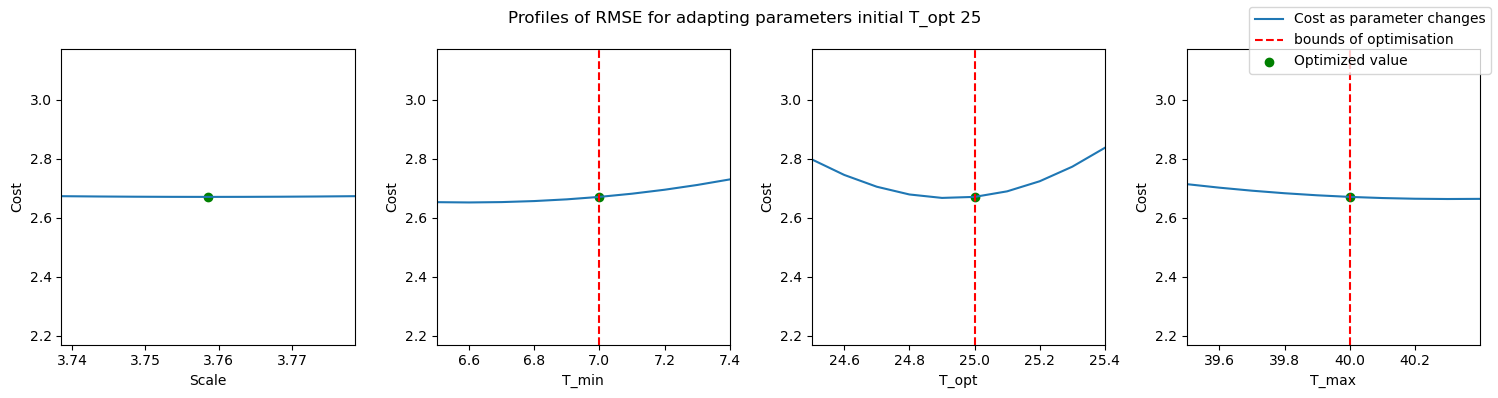

In [171]:
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], fm_flowering_all_DE[-2],
                         error_fctn = run_GDD_transformed_space_error,#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [200], title = ' initial T_opt 25', plot_range = 0.5)

In [50]:
x1s = [np.array([0.5, 8, 25, 39])]#[np.array([0.5, 7.5, 25, 39])]#
run_GDD_transformed_space_error3(x1s[0], ds_inputs_DE_early, 't2m', response_type='Wang',
                            phase_list = ['beginning of flowering'], growing_period_length=300,
                            thresholds = [20], new_unfinished_penalisation=False, alpha = 4)

np.float64(5.03086728604278)

In [185]:
x1s = [np.array([1.5, 8, 28, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
fm_flowering_all_DE3 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 error_fctn=run_GDD_transformed_space_error3,
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [60], growing_period_length=300,
                     test_size = 0.2, maxiter = 10, random_state = 1)

Optimization terminated successfully.
         Current function value: 3.742354
         Iterations: 237
         Function evaluations: 438
[ 1.5  8.  28.  39. ] [ 1.46684771  8.23247775 26.20979261 38.95570421] [ 0.03315229 -0.23247775  1.79020739  0.04429579]
RMSE at opt on test set:  3.8352710195244657
R^2: 0.8738990563308353


In [20]:
x1s = [np.array([0.5, 8, 28, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = fm_flowering_all_DE4[0]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
fm_flowering_all_DE4 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 #error_fctn=run_GDD_supplemented_error,
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

Optimization terminated successfully.
         Current function value: 8.481722
         Iterations: 128
         Function evaluations: 250
[ 0.5  8.  28.  39. ] [ 0.31863698  7.0094364  22.75838446 38.51850467] [0.18136302 0.9905636  5.24161554 0.48149533]
RMSE at opt on test set:  8.371535227201898
R^2: 0.406970001734685


In [11]:
ds_inputs_DE_reduced = ds_inputs_DE.sample(frac = 0.2, random_state=1)

Optimization terminated successfully.
         Current function value: 3.616186
         Iterations: 207
         Function evaluations: 366
[ 0.5  8.  28.  39. ] [ 0.36880762  7.         24.55907399 38.50000003] [0.13119238 1.         3.44092601 0.49999997]
RMSE at opt on test set:  3.609131665036277
R^2: 0.894573754307085
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.39283123429479594
Bias: 0.5500576607981985 (sign 1.0)
Variance of modelled values: 79.82890102533095
Optimization terminated successfully.
         Current function value: 3.615278
         Iterations: 361
         Function evaluations: 599
[ 0.5  8.  28.  39. ] [ 0.36575853  7.68277472 24.04749414 38.50020311] [0.13424147 0.31722528 3.95250586 0.49979689]
RMSE at opt on test set:  3.607779211713014
R^2: 0.8946527524563599
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3908483337841314
Bias: 0.5152748861551271 (s

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7360\3957145699.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m',


[ 0.5  8.  28.  39. ] [ 0.40685036  7.10115272 24.3249104  39.9996831 ] [ 0.09314964  0.89884728  3.6750896  -0.9996831 ]
RMSE at opt on test set:  3.5842148155562517
R^2: 0.8960244201907077
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.39675074191898896
Bias: 0.4684873968671461 (sign 1.0)
Variance of modelled values: 71.2919501670074
Optimization terminated successfully.
         Current function value: 3.580316
         Iterations: 201
         Function evaluations: 377
[ 0.5  8.  28.  39. ] [ 0.51007253  8.37411471 24.82731736 39.03118264] [-0.01007253 -0.37411471  3.17268264 -0.03118264]
RMSE at opt on test set:  3.59563765606748
R^2: 0.8953606268010117
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3399024502358118
Bias: 0.7101556614361371 (sign 1.0)
Variance of modelled values: 93.75177559143913


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7360\3957145699.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m',


[ 0.5  8.  28.  39. ] [ 0.45276256  7.0124681  23.15268864 38.52176233] [0.04723744 0.9875319  4.84731136 0.47823767]
RMSE at opt on test set:  3.5565802843318477
R^2: 0.8976215564256514
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.38467588083264637
Bias: 0.21025153557657122 (sign 1.0)
Variance of modelled values: 64.14981006993203


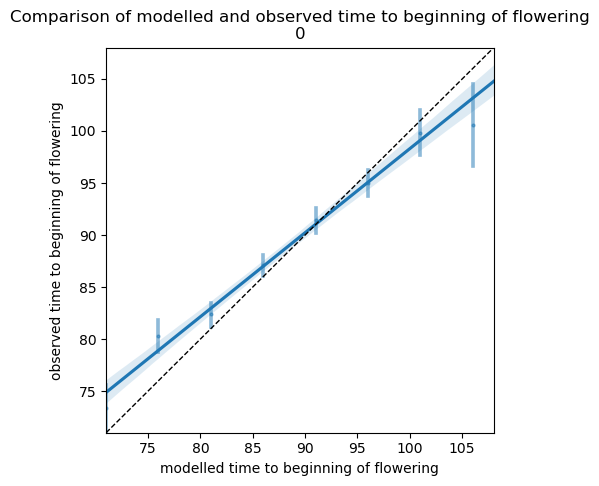

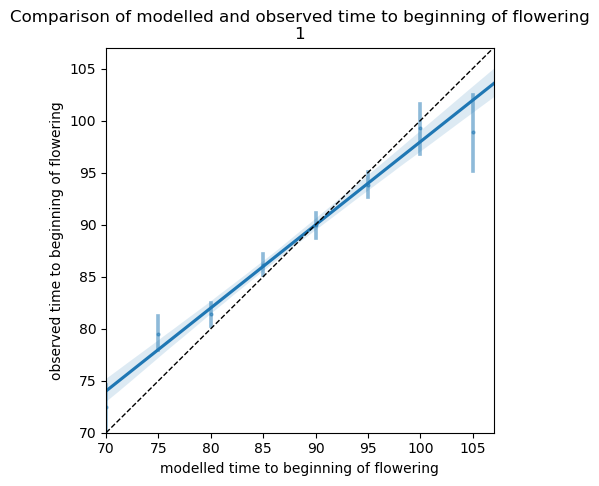

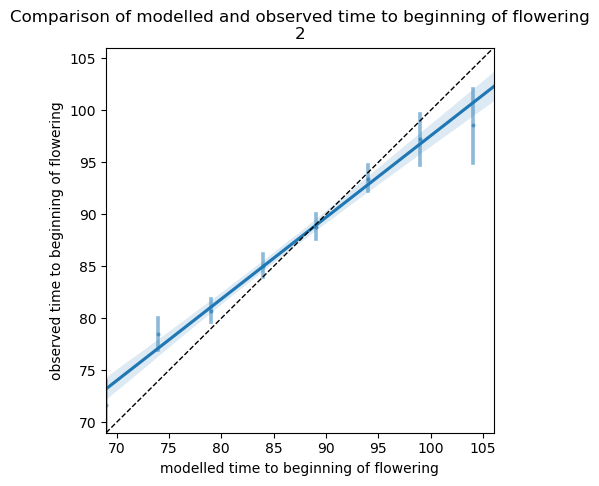

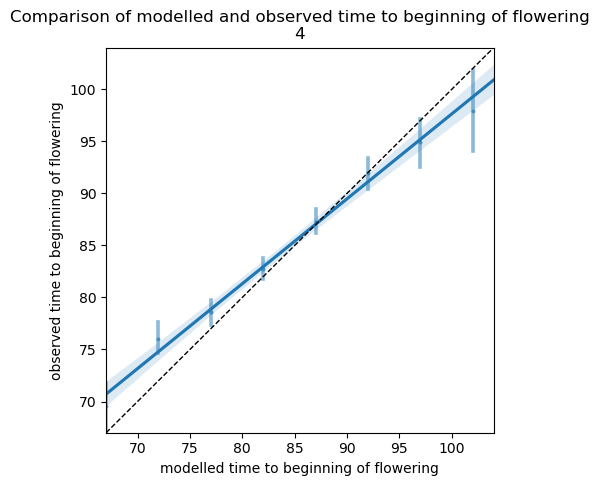

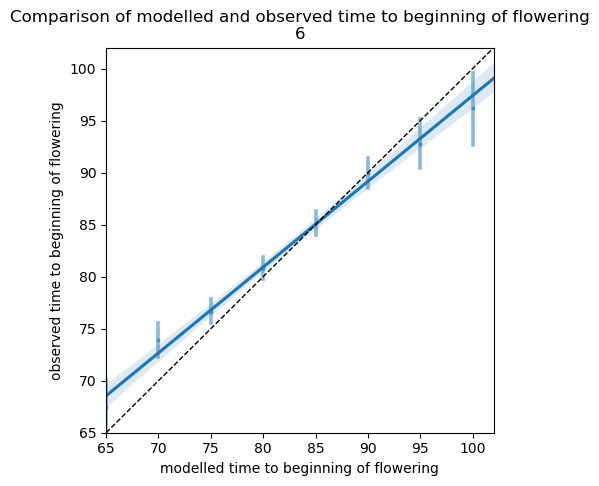

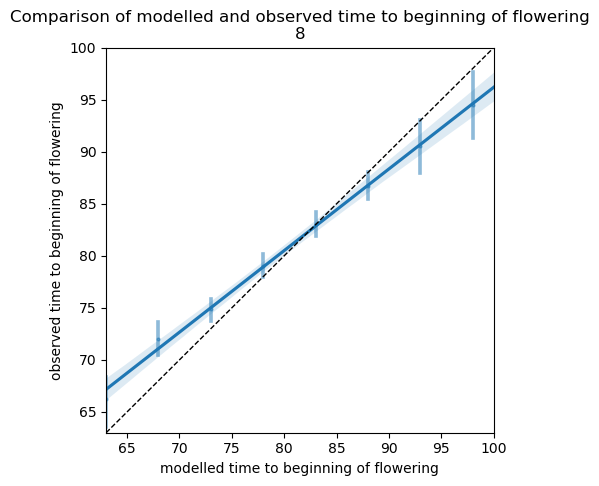

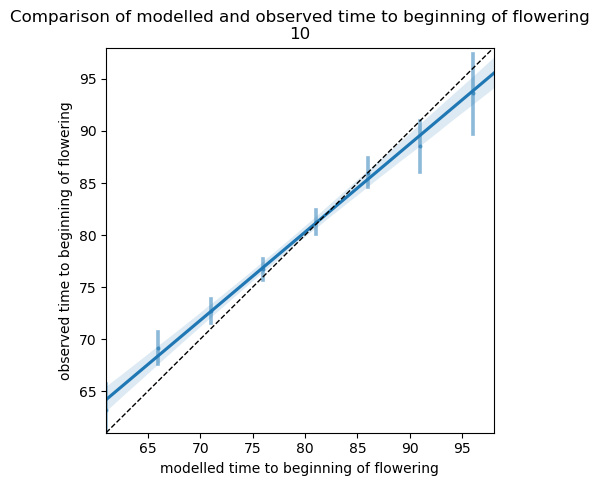

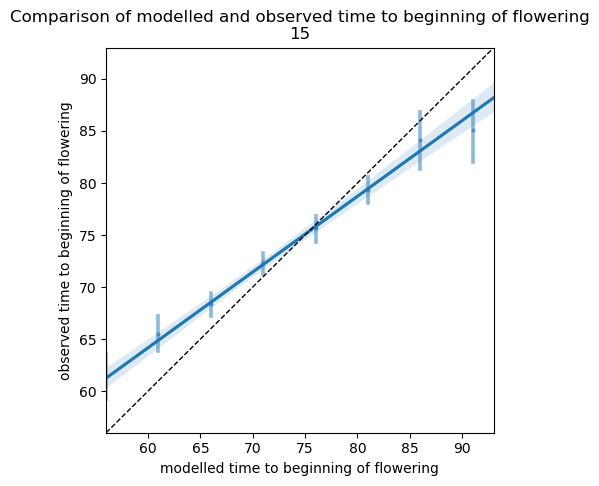

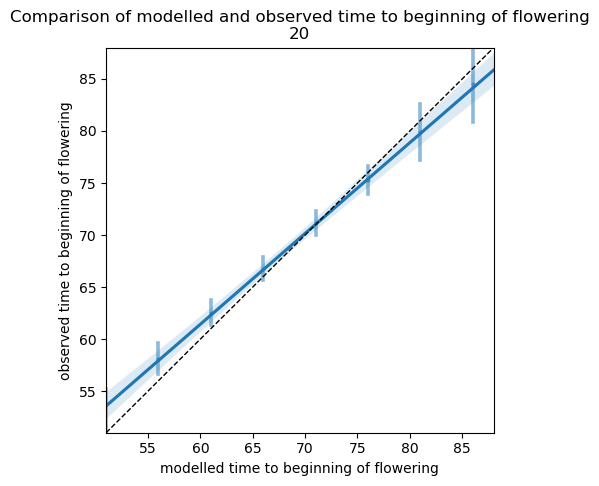

In [22]:
fm_shifted = []
comparison_array_shifted = []
x1s = [np.array([0.5, 8, 28, 39])]
for flowering_shift in [0, 1, 2, 4, 6, 8, 10, 15, 20]:
    ds_inputs_DE_shifted = ds_inputs_DE_reduced.copy()
    ds_inputs_DE_shifted['observed time to beginning of flowering'] = ds_inputs_DE_shifted['observed time to beginning of flowering'] - flowering_shift
    train_a, test_a = train_test_split(ds_inputs_DE_shifted, test_size=0.2, random_state = 1)
    fm_shift = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                         error_fctn=run_GDD_transformed_space_error3,
                         lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                         great_threshold = 13, response_type = 'Wang',
                         phase_list = ['beginning of flowering'],
                         method='Nelder-Mead',
                         thresholds = [20], growing_period_length=300,
                         test_size = 0.2, maxiter = 50, random_state = 1)
    fm_shifted.append(fm_shift)
    comparison_array_shift = run_GDD(fm_shift[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                            thresholds = [20], title_extra=str(flowering_shift), method = 'regression', plot=True)
    comparison_array_shifted.append(comparison_array_shift)
    


In [11]:
x1s = [np.array([0.5, 8, 28, 39, 0.5])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = fm_flowering_all_DE4[0]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_all_DE5 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 #error_fctn = run_GDD_and_get_RMSE_bias_term, #error_fctn=run_GDD_supplemented_error,
                     lower_bounds = [0.01, 7, 20, 38.5, -2], upper_bounds = [5, 11, 31, 40, 2],
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 10, random_state = 1, itr = 0.01, bias_term = True)

Optimization terminated successfully.
         Current function value: 8.371502
         Iterations: 116
         Function evaluations: 226
[ 0.5  8.  28.  39.   0.5] [ 0.44932428  7.23906059 26.14758185 39.08231653  0.55529453] [ 0.05067572  0.76093941  1.85241815 -0.08231653 -0.05529453]
RMSE at opt on test set:  8.41516856419258
R^2: 0.4238991804408617


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


IndexError: list index out of range

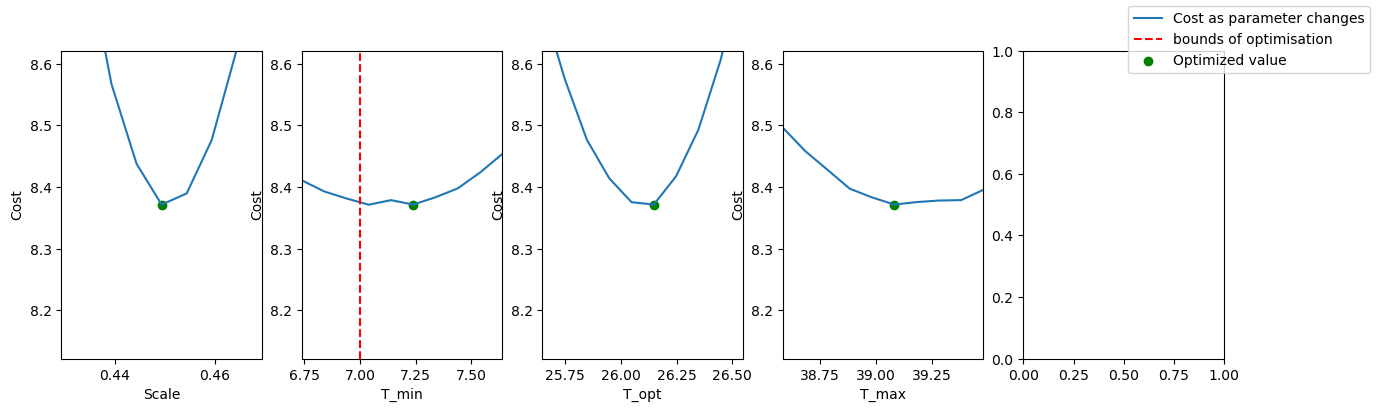

In [12]:
plot_profiles_at_minimum(fm_flowering_all_DE5[0][0], fm_flowering_all_DE5[-2],
                         lb=[0.01, 7, 20, 38.5, -10], ub = [5, 11, 31, 40, 10], 
                         response_type = 'Convolved', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' Convolved response', plot_range = 0.25)

In [118]:
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_all_DE5 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 #error_fctn = run_GDD_and_get_RMSE_bias_term, #error_fctn=run_GDD_supplemented_error,
                     lower_bounds = [0.01, 7, 20, 38.5, -2], upper_bounds = [5, 11, 31, 40, 2],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 10, random_state = 1, itr = 0.01, bias_term = True)

Optimization terminated successfully.
         Current function value: 8.363051
         Iterations: 134
         Function evaluations: 263
[ 0.5  8.  28.  39.   0.5] [ 0.31484962  7.01347729 22.98066462 39.20942413  0.91725853] [ 0.18515038  0.98652271  5.01933538 -0.20942413 -0.41725853]
RMSE at opt on test set:  8.46475336740652
R^2: 0.42007489850941215


In [79]:
print(run_GDD_transformed_space_error4(fm_flowering_all_DE4[0][0], test_a, 't2m', response_type='Wang',
                            phase_list = ['beginning of flowering'], growing_period_length=300, thresholds = [60]),
        run_GDD_and_get_RMSE(fm_flowering_all_DE4[0][0], test_a, 't2m', response_type='Wang',
                            phase_list = ['beginning of flowering'], growing_period_length=300, thresholds = [60]))


0.6205044974613388 8.67033379155849


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max
Plotting Bias term


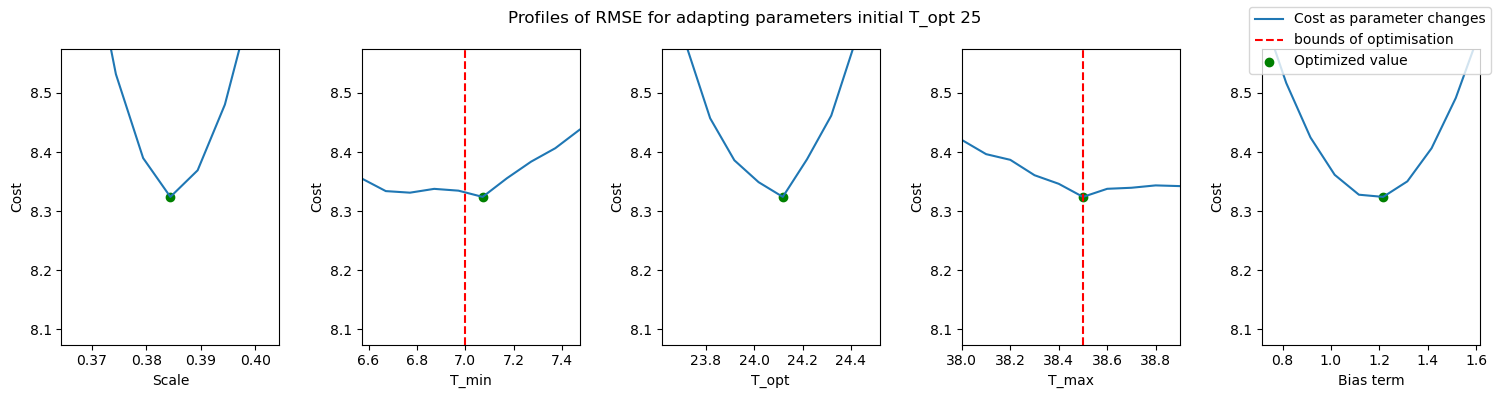

In [68]:
plot_profiles_at_minimum(fm_flowering_all_DE5[0][0], fm_flowering_all_DE5[-2],
                         error_fctn = run_GDD_and_get_RMSE_bias_term,#error_fctn = run_GDD_supplemented_error,#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5, -10], ub = [5, 11, 31, 40, 10], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 25', plot_range = 0.25, bias_term = True)

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


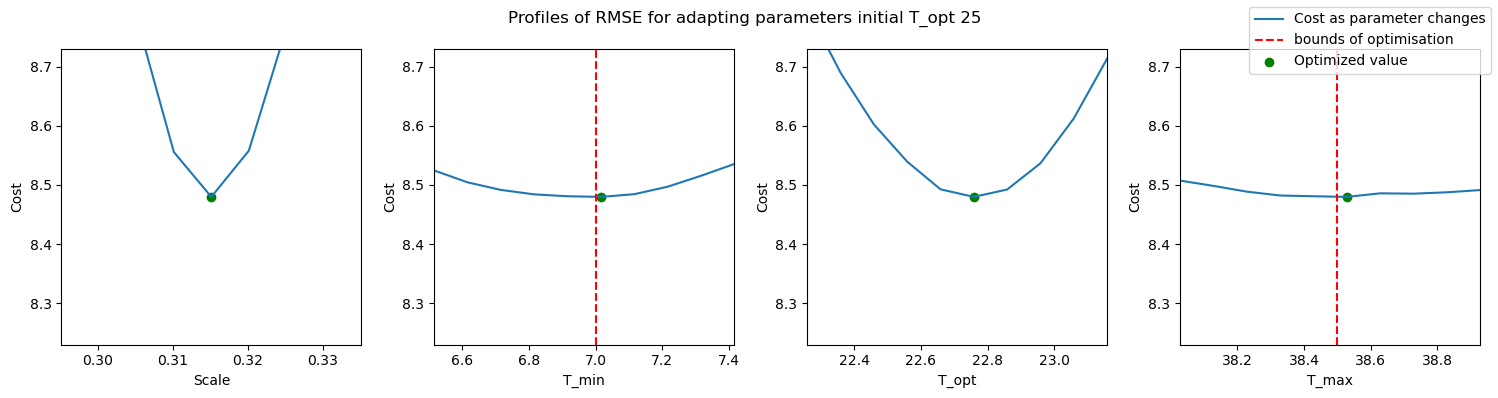

In [ ]:
plot_profiles_at_minimum(fm_flowering_all_DE5[0][0], fm_flowering_all_DE4[-2],
                         #error_fctn = run_GDD_supplemented_error,#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 25', plot_range = 0.25, bias_term = True)

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


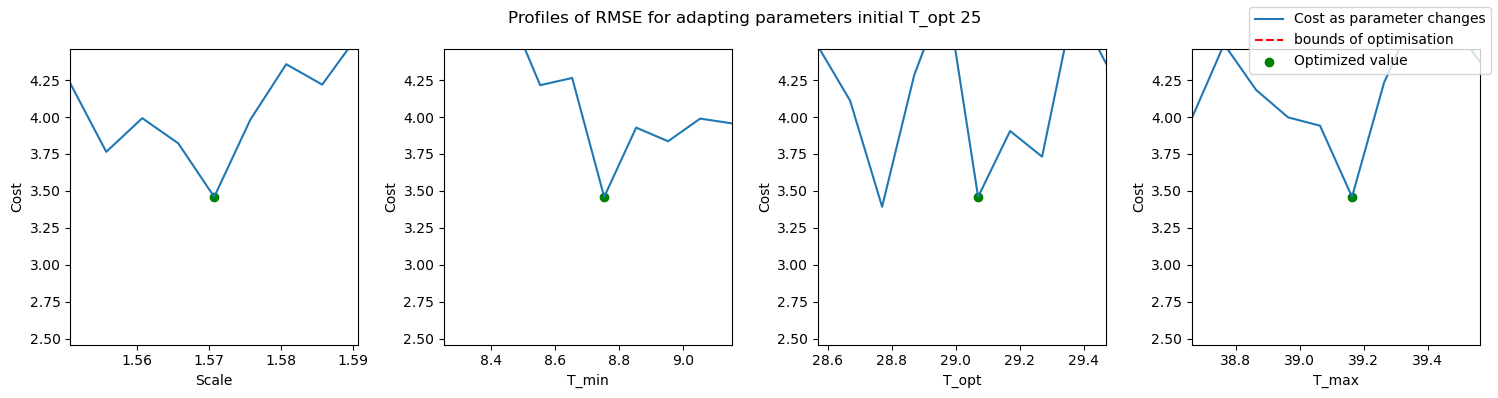

In [62]:
plot_profiles_at_minimum(fm_flowering_all_DE3[0][0], fm_flowering_all_DE3[-2],
                         error_fctn = run_GDD_transformed_space_error3,#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [60], title = ' initial T_opt 25', plot_range = 1)

0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3555372003121221
Bias: 0.0026722080827140783 (sign 1.0)
Variance of modelled values: 106.6903615991844
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


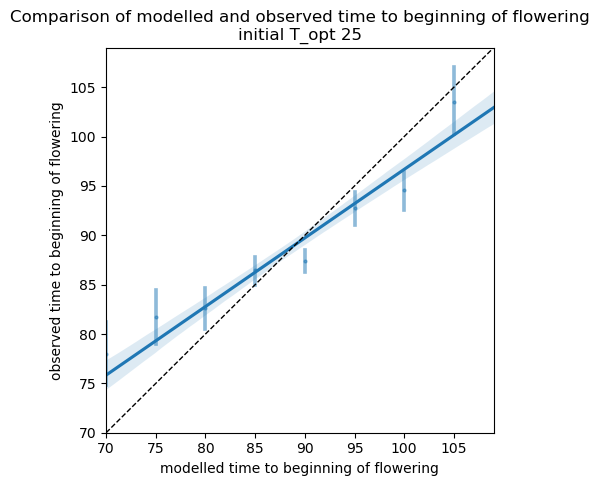

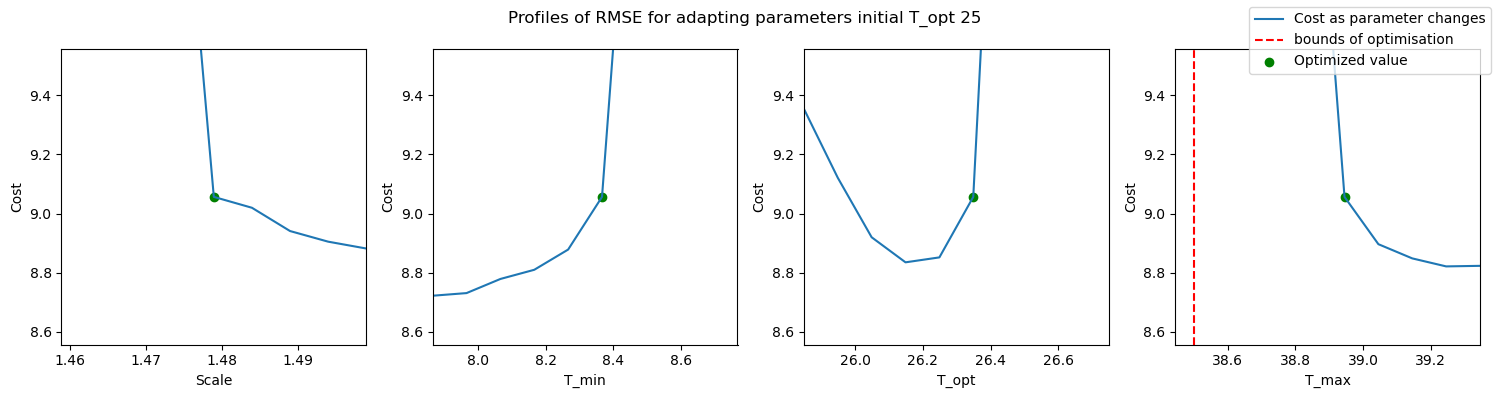

In [81]:
c_array = run_GDD(fm_flowering_all_DE4[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [60], title_extra='initial T_opt 25', method = 'regression', plot=True)
plot_profiles_at_minimum(fm_flowering_all_DE4[0][0], fm_flowering_all_DE4[-2],#train_a, #fm2s[0], ds2, #fm2s[0]
                         error_fctn = run_GDD_and_get_RMSE,
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [60], title = ' initial T_opt 25', plot_range = 0.5)

0 stations out of 450 did not reach the end of phase 'beginning of flowering'
R^2 value for model: -61.794292662981526
Bias: 6395.378612345679 (sign 1.0)
Variance of modelled values: 14.220781984657279


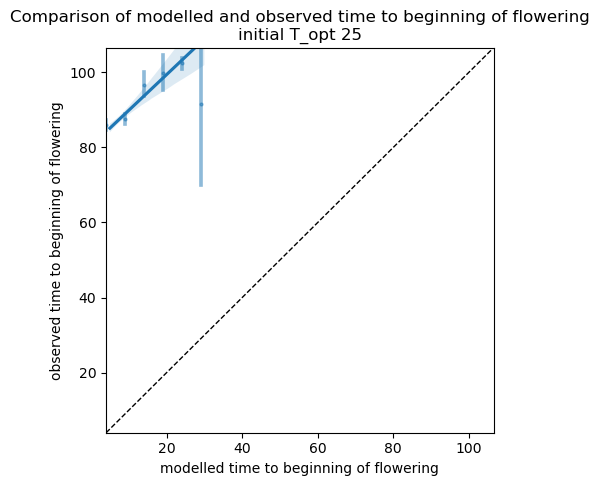

In [114]:
c_array = run_GDD(fm_flowering_all_DE2[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='initial T_opt 25', method = 'regression', plot=True)

In [17]:
fm_flowering_all_DE4 = [[[0.34525542, 7.00219008, 23.57229066, 39.02041395]], ds_inputs_DE, 0]
#fm_flowering_all_DE4 = [[[1.46684771, 8.23247775, 26.20979261, 38.95570421]], ds_inputs_DE, 0]
ds_inputs_DE_constant_flowering = ds_inputs_DE.copy()
ds_inputs_DE_constant_flowering['observed time to beginning of flowering'] = np.round(ds_inputs_DE_constant_flowering['observed time to beginning of flowering'].mean()).astype(int)
cf = run_GDD_transformed_space(fm_flowering_all_DE4[0][0], ds_inputs_DE_constant_flowering, #fm_flowering_all_DE4[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

In [297]:
cf_stoch = stoch_GDD_simulation(fm_flowering_all_DE2[0][0], ds_inputs_DE, 'temperature', response_type='Wang', phase_list = ['beginning of flowering'],
                                thresholds = [20], growing_period_length=300, scale_param=1)

In [298]:
modelled_time = cf_stoch['modelled time to flowering']
for count in range(20):
    print(count)
    cf_stoch_new = stoch_GDD_simulation(fm_flowering_all_DE2[0][0], ds_inputs_DE, 'temperature', response_type='Wang', phase_list = ['beginning of flowering'],
                                thresholds = [20], growing_period_length=300, scale_param=1)
    modelled_time += cf_stoch_new['modelled time to flowering']
modelled_time /= 21


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [299]:
cf_stoch['Meaned modelled time to flowering'] = modelled_time
cf_stoch['Meaned Error'] = cf_stoch['Meaned modelled time to flowering'] - cf_stoch['observed time to beginning of flowering']

In [ ]:
cf_stoch['Error'] = cf_stoch['observed time to beginning of flowering'] - cf_stoch['modelled time to flowering']

In [301]:
np.sqrt((cf_stoch['Meaned Error']**2).mean())

np.float64(10.09899455227818)

<Axes: xlabel='Meaned modelled time to flowering', ylabel='Meaned Error'>

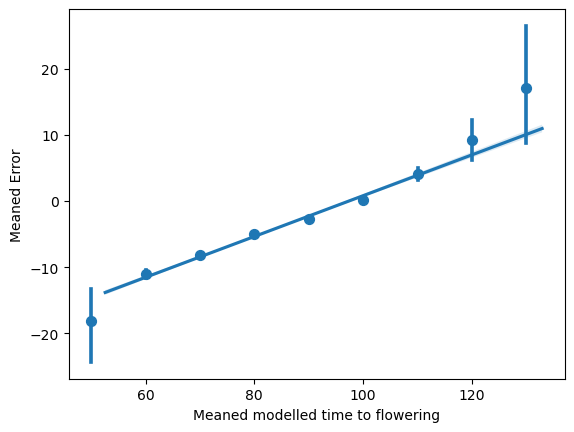

In [303]:
sns.regplot(x='Meaned modelled time to flowering', y='Meaned Error', data=cf_stoch, x_bins = np.arange(0, 150, 10))

<Axes: xlabel='Meaned modelled time to flowering', ylabel='observed time to beginning of flowering'>

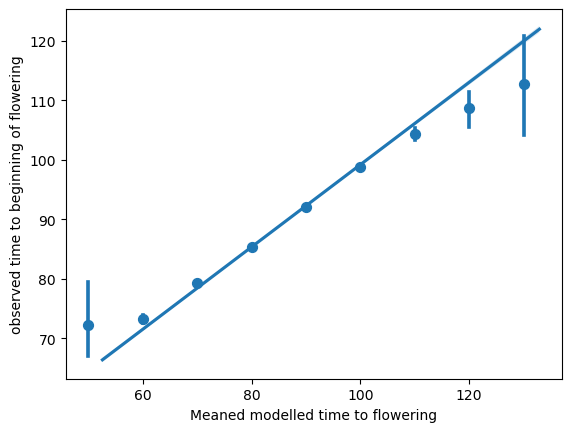

In [300]:
sns.regplot(x='Meaned modelled time to flowering', y='observed time to beginning of flowering', data=cf_stoch, x_bins = np.arange(0, 150, 10))

((array([-10.54031968,  -9.65348893,  -9.18698236, ...,   9.18698236,
           9.65348893,  10.54031968], shape=(26208,)),
  array([ 51,  53,  55, ..., 131, 133, 133], shape=(26208,))),
 (np.float64(5.468003903793307),
  np.float64(83.31944444444444),
  np.float64(0.9942383391364268)))

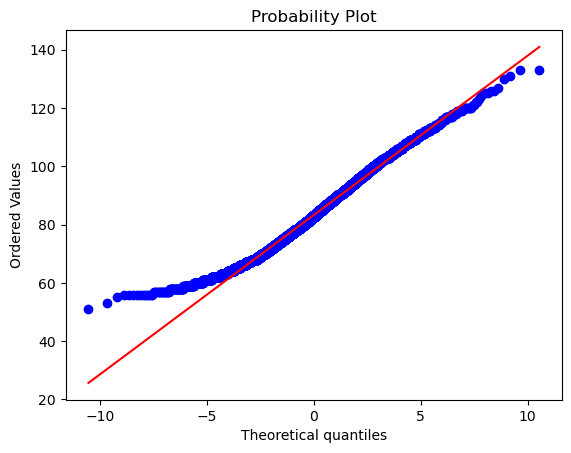

In [295]:
stats.probplot(cf_stoch['modelled time to flowering'], dist=scipy.stats.logistic, plot=plt)# #gennorm(beta = 1.5)

In [197]:
cf2 = run_GDD(fm_flowering_all_DE4[0][0], fm_flowering_all_DE4[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

In [141]:
cf4 = run_GDD_transformed_space(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [3])

In [99]:
cf4['modelled GDD at beginning of flowering'].var()

9.802791223594378

In [100]:
cf4['modelled GDD at beginning of flowering'].mean()

np.float64(21.39304488888339)

In [12]:
for vble in ['photoperiod', 'DTF', 'dev stage', 'vpd', 'ssrd', 't2max', 't2min', 'tp']:
    ds_inputs_DE_reduced = ds_inputs_DE_reduced.drop(columns = [col for col in ds_inputs_DE_reduced.columns if vble in col])

In [186]:
cf_convolved = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],# + [3, 7.5]
                               't2m', response_type='Convolved', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

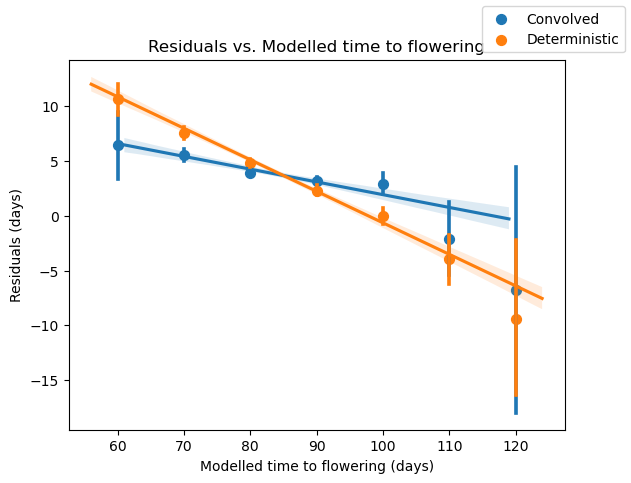

In [187]:
cf_convolved['Error'] = cf_convolved['observed time to beginning of flowering'] - cf_convolved['modelled time to beginning of flowering']
cf_deterministic['Error'] = cf_deterministic['observed time to beginning of flowering'] - cf_deterministic['modelled time to beginning of flowering']
fig, ax = plt.subplots()
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_convolved, x_bins = np.arange(0, 150, 10), label = 'Convolved', ax=ax)
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_deterministic, x_bins = np.arange(0, 150, 10), label = 'Deterministic', ax=ax)
ax.set_ylabel('Residuals (days)')
ax.set_xlabel('Modelled time to flowering (days)')
ax.set_title('Residuals vs. Modelled time to flowering')
fig.legend()

In [16]:
fm_flowering_all_DE2 = [[[0.503004, 7.02058042, 27.00252239, 39.30655295]], ds_inputs_DE, 0] #_reduced
cf_deterministic = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

Text(0, 0.5, 'Convolved - Standard (days)')

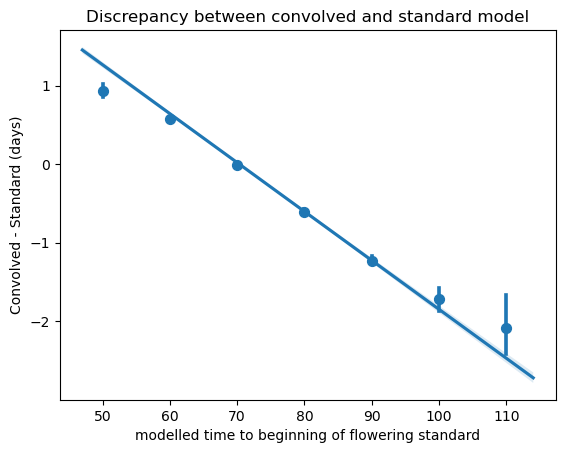

In [159]:
cf_compare_convolution = cf_deterministic[['year', 'Stations_id', 'observed time to beginning of flowering', 'modelled time to beginning of flowering']].merge(cf_convolved[['year', 'Stations_id', 'modelled time to beginning of flowering']], suffixes = [' standard', ' convolved'], on = ['year', 'Stations_id'])
cf_compare_convolution['discrepancy'] = cf_compare_convolution['modelled time to beginning of flowering convolved'] - cf_compare_convolution['modelled time to beginning of flowering standard']
fig, ax = plt.subplots()
sns.regplot(x = 'modelled time to beginning of flowering standard', y = 'discrepancy', data = cf_compare_convolution, x_bins = np.arange(0, 150, 10), ax=ax)
ax.set_title('Discrepancy between convolved and standard model')
ax.set_ylabel('Convolved - Standard (days)')

In [160]:
cf_stoch = stoch_GDD_simulation(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2], 't2m', response_type='Convolved', phase_list = ['beginning of flowering'],
                                thresholds = [20], growing_period_length=300, scale_param=1)
cf_stoch['modelled time to flowering mean'] = cf_stoch['modelled time to flowering']

In [161]:
for sample_index in range(50):
    print(sample_index)
    cf_stoch_new = stoch_GDD_simulation(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2], 't2m', response_type='Convolved', phase_list = ['beginning of flowering'],
                                thresholds = [20], growing_period_length=300, scale_param=1)
    cf_stoch['modelled time to flowering mean'] += cf_stoch_new['modelled time to flowering']
cf_stoch['modelled time to flowering mean'] /= 101

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [173]:
cf_stoch['modelled time to flowering mean'] =  cf_stoch['modelled time to flowering mean']*101/51

In [132]:
y = np.arange(0, 1, 0.01)[1:]
s = np.sqrt(0.5 * 3 / np.pi**2)
mu = 0
log_distributed = mu + s * np.log(y / (1 - y))
cfs = []
for pert in log_distributed:
    print(pert)
    ds_inputs_shifted = ds_inputs_DE_reduced.copy()
    ds_inputs_shifted[[f't2m at day {n}' for n in range(300)]] += pert
    cf_for_list = run_GDD(fm_flowering_all_DE2[0][0], ds_inputs_shifted,
                               't2m', response_type='Convolved', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])
    cfs.append(cf_for_list)

-1.7914001242176545
-1.5172199187065736
-1.3551515146185675
-1.2389592028353624
-1.1478848267419122
-1.0726816410301545
-1.0084167036892007
-0.9521450854899604
-0.9019668767523202
-0.856584487270533
-0.8150720727435236
-0.7767457130452202
-0.7410857326896751
-0.7076878901497148
-0.6762314471513327
-0.6464575635218227
-0.6181542527436411
-0.5911456435095072
-0.5652841477991541
-0.5404446394667307
-0.5165200538743928
-0.49341801135771174
-0.4710581910770825
-0.4493702633732803
-0.42829224363526663
-0.4077691683334757
-0.38775202013731336
-0.36819684765061156
-0.34906403868216157
-0.33031771571802027
-0.31192522945137113
-0.2938567315865031
-0.27608481217260356
-0.2585841897957887
-0.24133144531627965
-0.22430479166292822
-0.2074838736207777
-0.19084959266530893
-0.17438395278069305
-0.1580699239019012
-0.14189132018187448
-0.1258326907354218
-0.10987922087417722
-0.09401664213953086
-0.07823114967658824
-0.06250932568247401
-0.046838067814838985
-0.031204521567569313
-0.01559601571529208

In [137]:
cf_spread = cfs[0][['year', 'Stations_id', 'modelled time to beginning of flowering']]
cf_spread = cf_spread.rename(columns = {'modelled time to beginning of flowering': 'modelled time to beginning of flowering pert 0'})
for i, cf_for_list in enumerate(cfs):
    cf_spread = pd.merge(cf_spread, cf_for_list[['year', 'Stations_id', 'modelled time to beginning of flowering']], on=['year', 'Stations_id'])
    cf_spread = cf_spread.rename(columns = {'modelled time to beginning of flowering': f'modelled time to beginning of flowering pert {i + 1}'})
print(len(cf_spread))
cf_spread = cf_spread.loc[cf_spread['modelled time to beginning of flowering pert 0'] < 300]#cf_spread.columns[-1]
print(len(cf_spread))
cf_spread.loc[:, 'modelled time to beginning of flowering mean'] = cf_spread[[f'modelled time to beginning of flowering pert {i}' for i in range(len(cfs))]].mean(axis=1)
cf_spread = cf_spread.merge(cf_deterministic[['year', 'Stations_id', 'modelled time to beginning of flowering', 'observed time to beginning of flowering']], on = ['year', 'Stations_id'])
cf_spread['discrepancy'] = cf_spread['modelled time to beginning of flowering mean'] - cf_spread['modelled time to beginning of flowering']
cf_spread['Error'] = cf_spread['observed time to beginning of flowering'] - cf_spread['modelled time to beginning of flowering mean']
cf_deterministic['Error'] = cf_deterministic['observed time to beginning of flowering'] - cf_deterministic['modelled time to beginning of flowering']

5242
5234


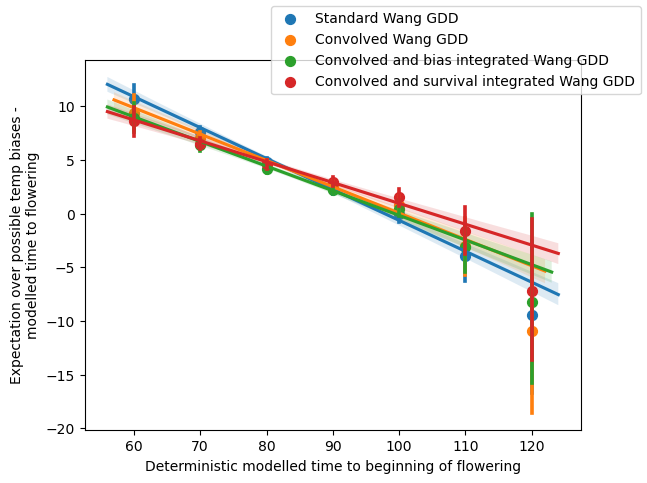

In [180]:
fig, ax = plt.subplots()
cf_deterministic['Error'] = cf_deterministic['observed time to beginning of flowering'] - cf_deterministic['modelled time to beginning of flowering']
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_deterministic, x_bins = np.arange(0, 150, 10), ax = ax, label = 'Standard Wang GDD')
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_convolved, x_bins = np.arange(0, 150, 10), ax = ax, label = 'Convolved Wang GDD')
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_spread, x_bins = np.arange(0, 150, 10), ax = ax, label = 'Convolved and bias integrated Wang GDD')
sns.regplot(x='Deterministic modelled time to beginning of flowering', y='Error', data=cf_compare, x_bins = np.arange(0, 150, 10), ax = ax, label = 'Convolved and survival integrated Wang GDD')
ax.set_ylabel('Expectation over possible temp biases -\nmodelled time to flowering')
fig.legend()

In [41]:
print(cf_deterministic['modelled time to beginning of flowering'].var(), cf_stoch['modelled time to flowering'].var(),
      cf_stoch['modelled time to flowering mean'].var())

81.37360327229229 112.9177061296043 81.10227794629516


In [174]:
cf_compare = cf_stoch.merge(cf_deterministic[['modelled time to beginning of flowering', 'Stations_id', 'year']], on = ['Stations_id', 'year'])
cf_compare = cf_compare.rename(columns = {'modelled time to flowering': 'Stochastic modelled time to beginning of flowering',
                                        'modelled time to flowering mean': 'Meaned stochastic modelled time to beginning of flowering',
                                        'modelled time to beginning of flowering': 'Deterministic modelled time to beginning of flowering'})

In [175]:
cf_compare['sample discrepancy'] = cf_compare['Stochastic modelled time to beginning of flowering'] - cf_compare['Deterministic modelled time to beginning of flowering']
cf_compare['mean discrepancy'] = cf_compare['Meaned stochastic modelled time to beginning of flowering'] - cf_compare['Deterministic modelled time to beginning of flowering']

In [178]:
cf_compare['Error'] = cf_compare['observed time to beginning of flowering'] - cf_compare['Meaned stochastic modelled time to beginning of flowering']

<Axes: xlabel='Deterministic modelled time to beginning of flowering', ylabel='mean discrepancy'>

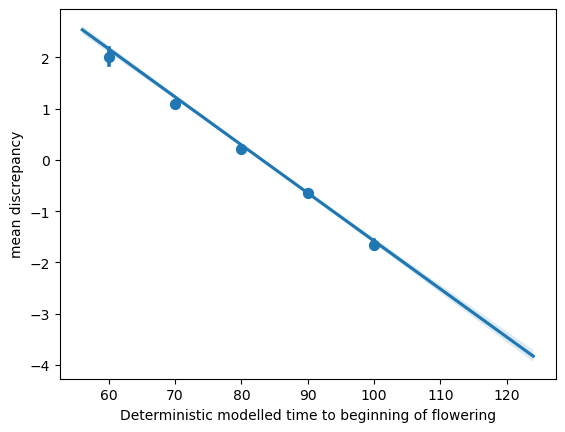

In [176]:
sns.regplot(x='Deterministic modelled time to beginning of flowering', y='mean discrepancy', data=cf_compare, x_bins = np.arange(0, 110, 10))

<Axes: xlabel='sample discrepancy', ylabel='Count'>

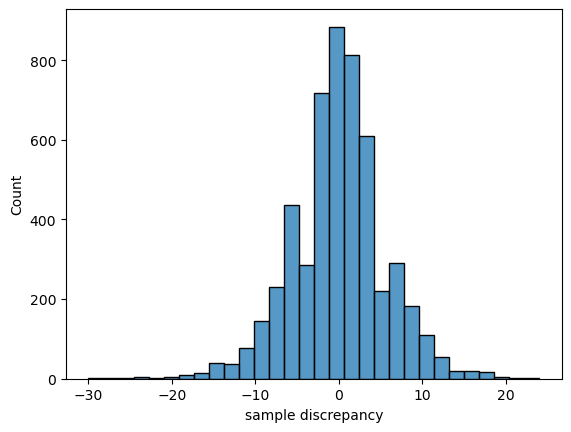

In [52]:
sns.histplot(cf_compare['sample discrepancy'], bins = 30)

In [22]:
fm_flowering_all_DE2 = [[[0.503004, 7.02058042, 27.00252239, 39.30655295]], ds_inputs_DE, 0]
cf3 = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Convolved', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

In [27]:
cf5 = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

<Axes: xlabel='modelled time to beginning of flowering', ylabel='Count'>

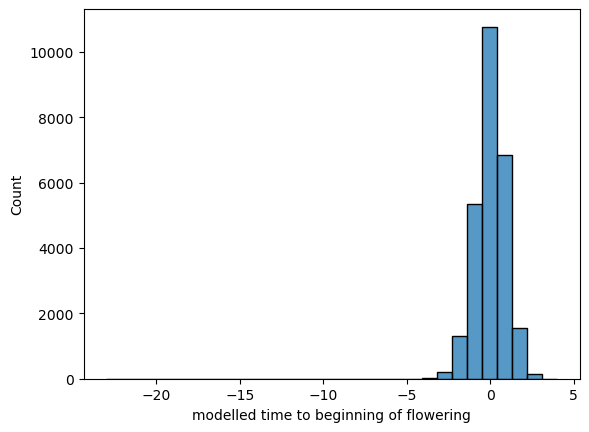

In [29]:
sns.histplot(cf3['modelled time to beginning of flowering'] - cf5['modelled time to beginning of flowering'], bins=30)

-2.2957696534838243
-1.713168974541066
-1.352462894302665
-1.0808892789334614
-0.8565844872705333
-0.6606354314360404
-0.4826628906325593
-0.3161398478038024
-0.1564622993531765
0.0
0.15646229935317663
0.3161398478038028
0.48266289063255957
0.6606354314360408
0.8565844872705333
1.0808892789334614
1.3524628943026658
1.7131689745410665
2.2957696534838257


In [102]:
y = np.arange(0, 1, 0.01)[1:]
s = np.sqrt(cf4['modelled GDD at beginning of flowering'].var() * 3 / np.pi**2)
mu = cf4['modelled GDD at beginning of flowering'].mean()
log_distributed = mu + s * np.log(y / (1 - y))
cfs = []
for threshold in log_distributed:
    print(threshold)
    cf_for_list = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [threshold])
    cfs.append(cf_for_list)

13.461049109093125
14.675069474289707
15.392679057924646
15.907157601410823
16.310418468178806
16.643404574201853
16.92795809459393
17.17711864339833
17.399298677084673
17.60024369041805
17.784053154526998
17.953755344044502
18.111651288040328
18.25953089489073
18.398814335668288
18.530647707847145
18.655969649389753
18.775558886638866
18.8900689126573
19.000053763390127
19.105987501691352
19.20827916800843
19.307284408493317
19.403314630158107
19.49664428965072
19.587516755540058
19.676149067701328
19.76273583496826
19.847452452959764
19.930457780819218
20.011896383772662
20.091900424675515
20.17059126983295
20.24808086077357
20.324472893213017
20.3998638363622
20.47434381943176
20.547997407234345
20.620904282873507
20.693139852397355
20.76477578380949
20.835880490835294
20.90651957023564
20.976756200164843
21.046651506023803
21.116264899417075
21.185654395147054
21.25487691064211
21.32398855179663
21.39304488888339
21.46210122597015
21.531212867124673
21.60043538261973
21.66982487834

In [ ]:
cf_spread = cfs[0][['Referenzjahr', 'Stations_id', 'modelled time to beginning of flowering']]
cf_spread = cf_spread.rename(columns = {'modelled time to beginning of flowering': 'modelled time to beginning of flowering threshold 0'})
for i, cf_for_list in enumerate(cfs):
    cf_spread = pd.merge(cf_spread, cf_for_list[['Referenzjahr', 'Stations_id', 'modelled time to beginning of flowering']], on=['Referenzjahr', 'Stations_id'])
    cf_spread = cf_spread.rename(columns = {'modelled time to beginning of flowering': f'modelled time to beginning of flowering threshold {i + 1}'})
print(len(cf_spread))
cf_spread = cf_spread.loc[cf_spread['modelled time to beginning of flowering threshold 0'] < 300]#cf_spread.columns[-1]
print(len(cf_spread))
cf_spread.loc[:, 'modelled time to beginning of flowering mean'] = cf_spread[[f'modelled time to beginning of flowering threshold {i}' for i in range(len(cfs))]].mean(axis=1)

In [61]:
cf_spread.loc[:, 'discrepancy'] = cf_spread['modelled time to beginning of flowering mean'] - cf_spread['modelled time to beginning of flowering threshold 9']

In [62]:
cf_spread = cf_spread.merge(ds_inputs_DE[['Referenzjahr', 'Stations_id', 'observed time to beginning of flowering']], on=['Referenzjahr', 'Stations_id'], how='inner')

In [63]:
np.sqrt(((cf_spread['modelled time to beginning of flowering mean'] - cf_spread['observed time to beginning of flowering'])**2).mean())

np.float64(9.147363930735544)

In [64]:
cf_spread['modelled time to beginning of flowering mean'].max()

138.94736842105263

<Axes: xlabel='discrepancy', ylabel='Count'>

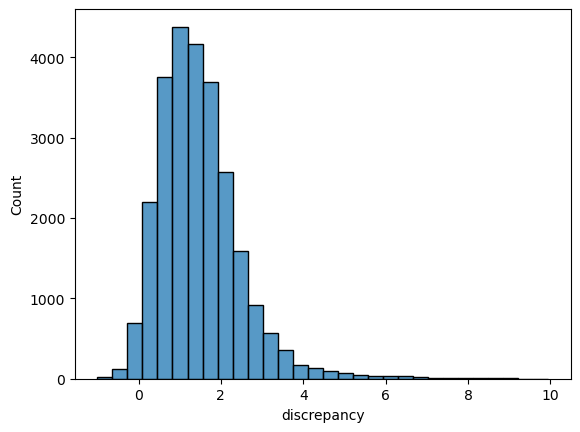

In [65]:
sns.histplot(cf_spread['discrepancy'], bins = 30)

((array([-13.36836075, -12.48156486, -12.01509419, ...,  12.01509419,
          12.48156486,  13.36836075], shape=(443232,)),
  array([ 47.,  48.,  48., ..., 238., 248., 248.], shape=(443232,))),
 (np.float64(9.239586702686301),
  np.float64(87.26630748682406),
  np.float64(0.9757340151492986)))

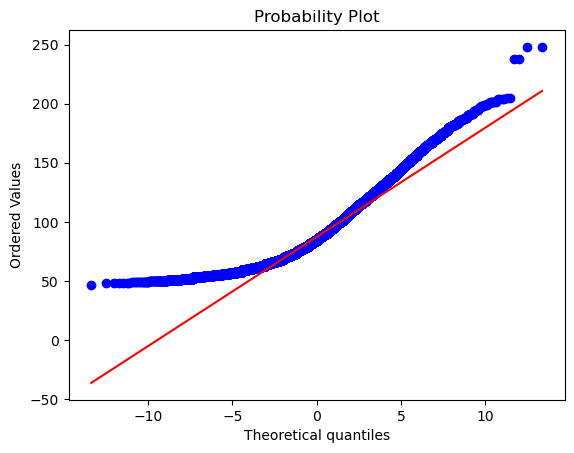

In [50]:
stats.probplot(cf_spread[[f'modelled time to beginning of flowering threshold {i}' for i in range(len(cfs))]].values.flatten(), dist=scipy.stats.logistic, plot=plt)# #gennorm(beta = 1.5)

<Axes: xlabel='modelled time to flowering', ylabel='Count'>

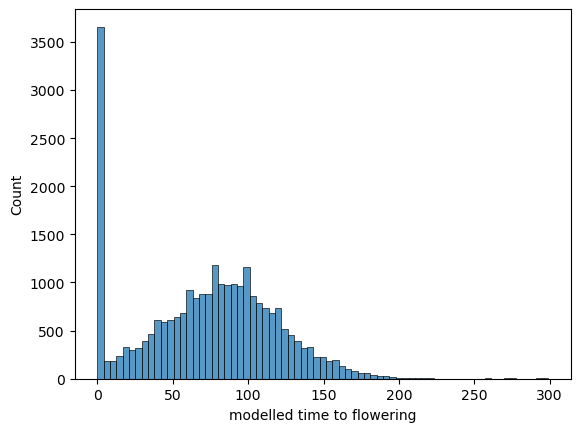

In [269]:
sns.histplot(cf_stoch['modelled time to flowering'])

((array([-10.5213292 ,  -9.63449774,  -9.16799044, ...,   9.16799044,
           9.63449774,  10.5213292 ], shape=(25715,)),
  array([ 37.07737839,  37.31415484,  37.81230248, ..., 148.06181501,
         151.94675909, 152.14866914], shape=(25715,))),
 (np.float64(7.3674578025232496),
  np.float64(86.62164955235231),
  np.float64(0.9979111415000055)))

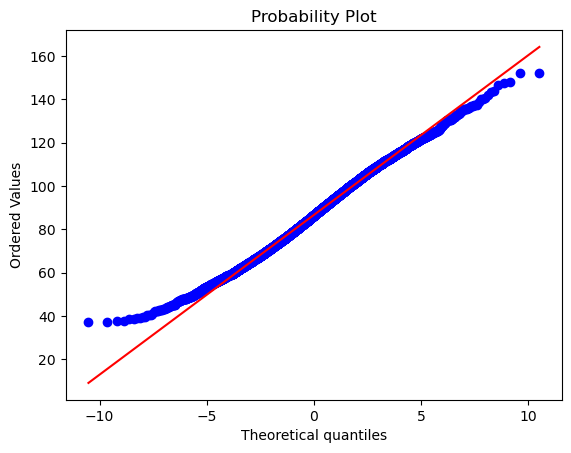

In [74]:
stats.probplot(cf_spread['modelled time to beginning of flowering mean'] + np.random.logistic(0, 5, len(cf_spread)), dist=scipy.stats.logistic, plot=plt)# #gennorm(beta = 1.5)

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

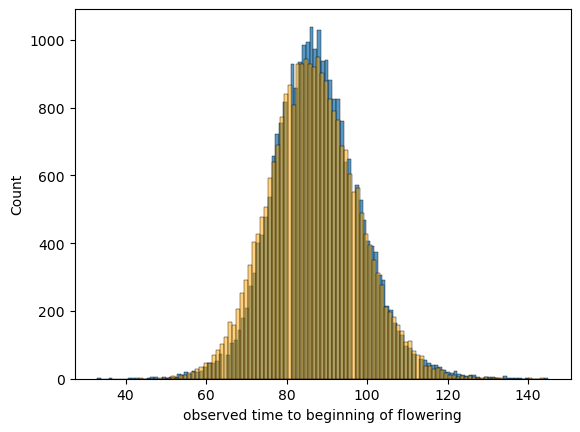

In [68]:
fig, ax = plt.subplots()
sns.histplot(cf_spread['observed time to beginning of flowering'], ax=ax)
sns.histplot(cf_spread['modelled time to beginning of flowering mean'] + np.random.normal(0, 5, len(cf_spread)), ax=ax, color='orange', alpha=0.5)

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

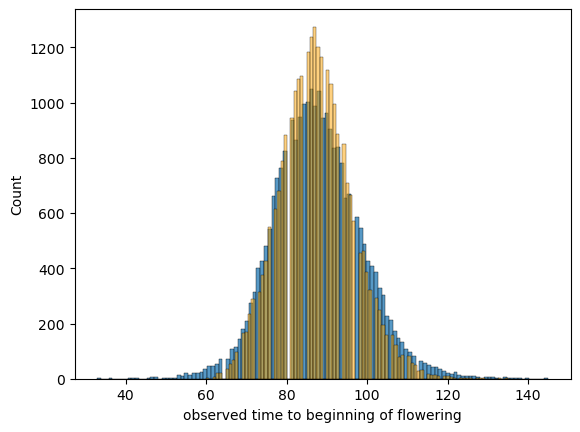

In [ ]:
fig, ax = plt.subplots()
sns.histplot(cf3['observed time to beginning of flowering'], ax=ax)
sns.histplot(cf3['modelled time to beginning of flowering'] + 3, ax=ax, color='orange', alpha=0.5)

((array([-10.54031968,  -9.65348893,  -9.18698236, ...,   9.18698236,
           9.65348893,  10.54031968], shape=(26208,)),
  array([ 57.,  59.,  59., ..., 126., 130., 132.], shape=(26208,))),
 (np.float64(4.936583218390187),
  np.float64(84.39377289377289),
  np.float64(0.9943858555965698)))

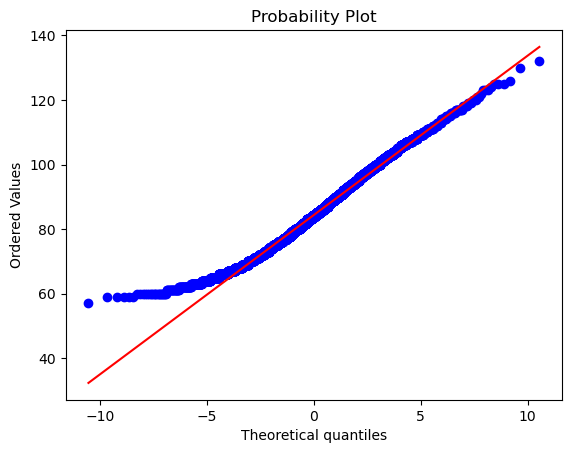

In [32]:
cf3['Error'] = cf3['observed time to beginning of flowering'] - cf3['modelled time to beginning of flowering']
#stats.probplot(cf2['Error'], dist="norm", plot=plt)  - cf2['observed time to beginning of flowering']
stats.probplot(cf3['modelled time to beginning of flowering'], dist=scipy.stats.logistic, plot=plt)# #gennorm(beta = 1.5)

<Axes: xlabel='modelled time to beginning of flowering', ylabel='Error'>

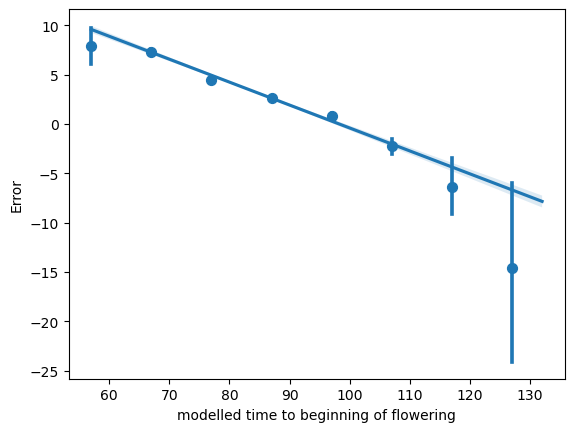

In [26]:
#cf_spread = pd.merge(cf_spread, cf3[['Referenzjahr', 'Stations_id', 'observed time to beginning of flowering']], on=['Referenzjahr', 'Stations_id'])
#cf_spread['Error'] = cf_spread['observed time to beginning of flowering'] - cf_spread['modelled time to beginning of flowering mean']
sns.regplot(y='Error', x = 'modelled time to beginning of flowering', data=cf3, x_bins=np.arange(cf3['modelled time to beginning of flowering'].min(), cf3['modelled time to beginning of flowering'].max(), 10))

((array([-4.04245198, -3.82951871, -3.71313745, ...,  3.71313745,
          3.82951871,  4.04245198], shape=(26208,)),
  array([ 33,  36,  41, ..., 138, 140, 145], shape=(26208,))),
 (np.float64(10.95996588695097),
  np.float64(87.61336233211233),
  np.float64(0.9966217317035899)))

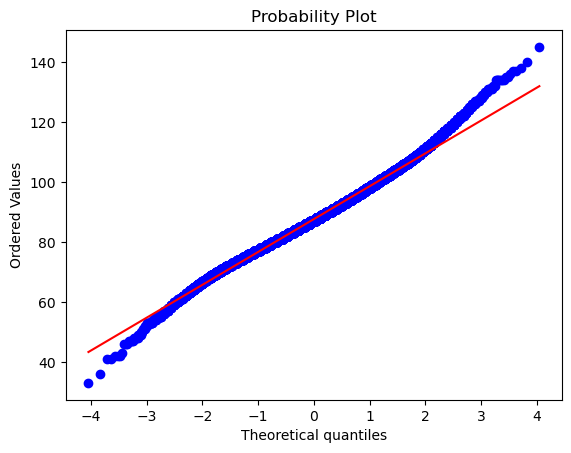

In [44]:
cf2['Error'] = cf2['observed time to beginning of flowering'] - cf2['modelled time to beginning of flowering']
#stats.probplot(cf2['Error'], dist="norm", plot=plt)
stats.probplot(cf2['observed time to beginning of flowering'], dist="norm", plot=plt) #gennorm(beta = 1.5)

<Axes: xlabel='modelled GDD at beginning of flowering', ylabel='Count'>

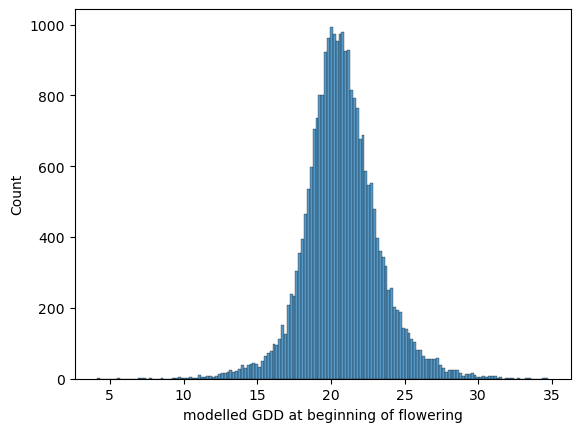

In [81]:
sns.histplot(cf['modelled GDD at beginning of flowering'])

In [82]:
cf['modelled GDD at beginning of flowering'].mean()

np.float64(20.752858495979694)

((array([-10.54031968,  -9.65348893,  -9.18698236, ...,   9.18698236,
           9.65348893,  10.54031968], shape=(26208,)),
  array([ 3.51301632,  4.50898622,  5.38536286, ..., 38.33207135,
         38.8517145 , 40.84185358], shape=(26208,))),
 (np.float64(1.7231882879637161),
  np.float64(21.39304488888339),
  np.float64(0.9979001026906007)))

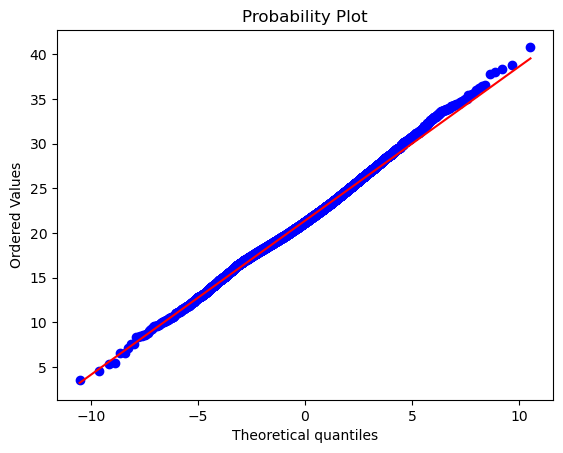

In [154]:

x = stats.cauchy(scale = 100)
fig, ax = plt.subplots()
x = stats.beta(a=3, b=2)
stats.probplot(cf4['modelled GDD at beginning of flowering'], dist=scipy.stats.logistic, plot = plt) #scipy.stats.logistic
#stats.probplot(cf['modelled GDD at beginning of flowering'], dist=scipy.stats.gennorm(beta = 1.5), plot = plt)

In [86]:
cf.loc[cf['modelled GDD at beginning of flowering'] < 40]

observed time to beginning of flowering  Referenzjahr  Stations_id  \
73                                         57          1991        11620   
182                                        72          2001         7807   
428                                        79          1996        10865   
532                                        63          1996         7700   
627                                        60          2022         8556   
714                                        60          1999         7807   
837                                        64          1995        12898   
933                                        71          1997        10865   
957                                        49          2013         8793   
1049                                       91          1996         8025   
1089                                       62          1993        12007   
1152                                       63          1994         9711   
1297                                       46          2001        12865   
1491                                       70          1991         9899   
1593                                       60          1993         7998   
1720                                       95          1996         9581   
1900                                       70          1995        10796   
1990                                       72          1997        13262   
2152                                       69          1995         7620   
2196                                       84          1995        10427   
2210                                       71          1995        11809   

      modelled GDD before beginning of flowering  \
73                                     30.612407   
182                                    37.945729   
428                                    31.576946   
532                                    32.370124   
627                                    36.098703   
714                                    29.054096   
837                                    26.398175   
933                                    28.006852   
957                                    29.234736   
1049                                   34.673834   
1089                                   37.487166   
1152                                   32.092897   
1297                                   23.824394   
1491                                   13.825835   
1593                                   38.537361   
1720                                   33.603036   
1900                                   34.360749   
1990                                   35.849559   
2152                                   32.033442   
2196                                   32.531118   
2210                                   36.560962   

      modelled GDD at beginning of flowering  
73                                 31.357741  
182                                38.700292  
428                                32.677657  
532                                33.050820  
627                                37.558094  
714                                29.856594  
837                                27.519621  
933                                28.338366  
957                                30.197942  
1049                               35.043738  
1089                               38.548690  
1152                               33.453602  
1297                               24.541519  
1491                               14.467870  
1593                               38.747176  
1720                               34.006940  
1900                               35.475144  
1990                               36.806540  
2152                               33.210646  
2196                               33.746202  
2210                               37.345380

In [85]:
ds_inputs_DE_early['observed time to beginning of flowering'].min()

46

In [96]:
cf2 = run_GDD_transformed_space(x0, fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [200])

<Axes: xlabel='modelled GDD at beginning of flowering', ylabel='Count'>

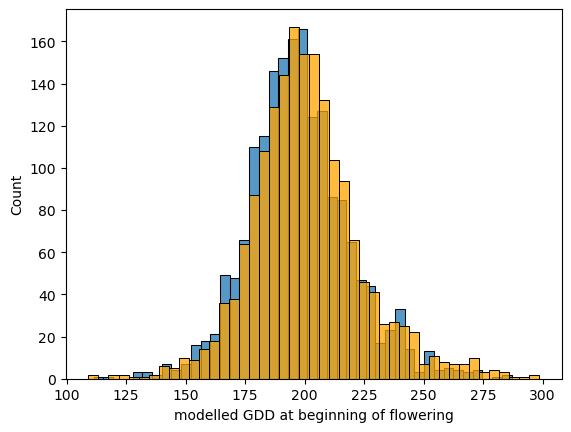

In [99]:
fig, ax = plt.subplots()
sns.histplot(cf['modelled GDD at beginning of flowering'], ax=ax, label='GDD optimised')
sns.histplot(cf2['modelled GDD at beginning of flowering']*10, ax=ax, label='RMSE optimised', color='orange')

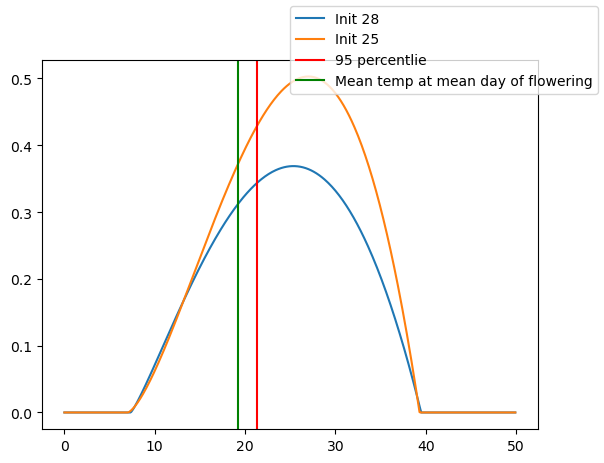

In [ ]:
#fm_flowering_all_DE = [[fm_flowering_all_DE], ds_inputs_DE, 0, 1]
fm_flowering_all_DE = []
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), label = 'Init 28')
ax.plot(xvals, fm_flowering_all_DE2[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Init 25')
ax.axvline(np.quantile(comp_frame_25[[f't2m at day {n}' for n in range(300)]].values, 0.95), color = 'red', label = '95 percentlie')
ax.axvline(comp_frame_25['t2m at day 88'].mean(), color = 'green', label = 'Mean temp at mean day of flowering')
fig.legend()

In [ ]:
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), label = 'Init 28')
ax.plot(xvals, fm_flowering_all_DE2[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Init 25')
ax.axvline(np.quantile(comp_frame_25[[f'temperature at day {n}' for n in range(300)]].values, 0.95), color = 'red', label = '95 percentlie')
ax.axvline(comp_frame_25['temperature at day 88'].mean(), color = 'green', label = 'Mean temp at mean day of flowering')
fig.legend()

In [125]:
table*x[0]

array([0.00865437, 0.01053558, 0.01272847, 0.0152632 , 0.01816882,
       0.02147251, 0.02519884, 0.02936902, 0.03400025, 0.03910518,
       0.04469148, 0.05076152, 0.05731232, 0.06433554, 0.07181773,
       0.07974064, 0.08808173, 0.0968147 , 0.10591014, 0.11533612,
       0.12505883, 0.13504316, 0.14525315, 0.15565242, 0.16620442,
       0.17687265, 0.1876207 , 0.19841226, 0.20921101, 0.21998047,
       0.23068388, 0.24128397, 0.25174286, 0.26202188, 0.27208158,
       0.28188167, 0.29138113, 0.30053831, 0.30931122, 0.31765771,
       0.3255359 , 0.33290451, 0.33972325, 0.34595334, 0.35155784,
       0.35650216, 0.3607544 , 0.36428578, 0.36707086, 0.36908791,
       0.370319  , 0.37075016, 0.37037145, 0.36917689, 0.36716445,
       0.36433588, 0.36069659, 0.3562555 , 0.35102479, 0.34502007,
       0.33826001, 0.33076658, 0.32256506, 0.31368429, 0.30415696,
       0.29401992, 0.28331462, 0.27208747, 0.26039021, 0.24828017,
       0.23582039, 0.22307953, 0.21013155, 0.19705514, 0.18393

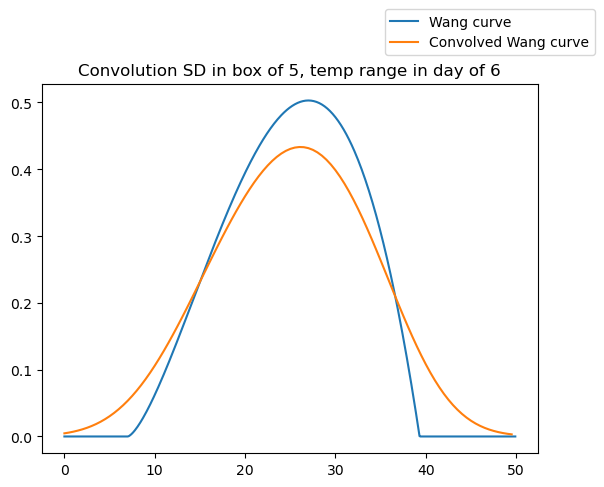

In [13]:
fm_flowering_all_DE2 = [[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
x = fm_flowering_all_DE2[0][0]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 5, 3)#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, fm_flowering_all_DE2[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Wang curve')
ax.plot(np.arange(0, 50, 0.5), x[0]*np.array(table), label = 'Convolved Wang curve')
ax.set_title('Convolution SD in box of 5, temp range in day of 6')
#ax.axvline(np.quantile(comp_frame_25[[f'temperature at day {n}' for n in range(300)]].values, 0.95), color = 'red', label = '95 percentlie')
#ax.axvline(comp_frame_25['temperature at day 88'].mean(), color = 'green', label = 'Mean temp at mean day of flowering')
fig.legend(bbox_to_anchor=(1, 1.05))

In [24]:
fm_flowering_all_DE = np.array([0.36883787, 7.33177754, 25.34427389, 39.48075322])

In [155]:
np.quantile(comp_frame_25_lates[[f'temperature at day {n}' for n in range(300)]].values, 0.9)

np.float64(18.066341534667767)

In [19]:
comp_frame_25 =run_GDD(fm_flowering_all_DE4[0][0], ds_inputs_DE, 't2m', response_type='Wang',#_early
        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
        thresholds = [20], title_extra='Early varieties', method = 'regression', plot=False)
comp_frame_28 =run_GDD(fm_flowering_all_DE2[0][0], ds_inputs_DE, 't2m', response_type='Wang',#_early
        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
        thresholds = [20], title_extra='Early varieties', method = 'regression', plot=False)

In [134]:
comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]] = fm_flowering_all_DE4[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(comp_frame_25[[f'temperature at day {n}' for n in range(300)]].values, fm_flowering_all_DE4[0][0][1], fm_flowering_all_DE4[0][0][2], fm_flowering_all_DE4[0][0][3])
comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]] = fm_flowering_all_DE2[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(comp_frame_28[[f'temperature at day {n}' for n in range(300)]].values, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3])

In [135]:
fm_flowering_all_DE2[0][0]

[0.503004, 7.02058042, 27.00252239, 39.30655295]

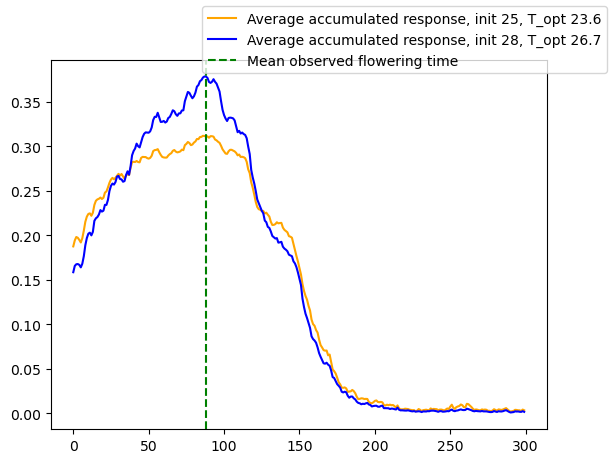

In [137]:
comp_frame_25_lates = comp_frame_25.loc[comp_frame_25['modelled time to beginning of flowering'] < 80]
comp_frame_28_lates = comp_frame_28.loc[comp_frame_28['modelled time to beginning of flowering'] < 80]
fig, ax = plt.subplots()
ax.plot(range(300), comp_frame_25_lates.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0), label = 'Average accumulated response, init 25, T_opt 23.6', color = 'orange')
ax.plot(range(300), comp_frame_28_lates.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0), label = 'Average accumulated response, init 28, T_opt 26.7', color = 'blue')

ax.axvline(x = comp_frame_25['observed time to beginning of flowering'].mean(), color='green', linestyle='--', label='Mean observed flowering time')
fig.legend()

KeyError: "None of [Index(['acc_response at day 0', 'acc_response at day 1',\n       'acc_response at day 2', 'acc_response at day 3',\n       'acc_response at day 4', 'acc_response at day 5',\n       'acc_response at day 6', 'acc_response at day 7',\n       'acc_response at day 8', 'acc_response at day 9',\n       ...\n       'acc_response at day 290', 'acc_response at day 291',\n       'acc_response at day 292', 'acc_response at day 293',\n       'acc_response at day 294', 'acc_response at day 295',\n       'acc_response at day 296', 'acc_response at day 297',\n       'acc_response at day 298', 'acc_response at day 299'],\n      dtype='object', length=300)] are in the [columns]"

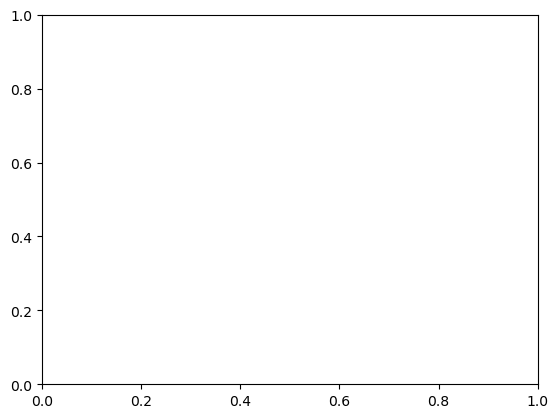

In [20]:
fig, ax = plt.subplots()
mean_25 = comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0)
var_25 = comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].var(axis=0)
mean_28 = comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0)
var_28 = comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].var(axis=0)
ax.plot(range(300), comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0), label = 'Average accumulated response, init 25, T_opt 23.6', color = 'orange')
ax.fill_between(range(300), mean_25 - np.sqrt(var_25), mean_25 + np.sqrt(var_25), color = 'orange', alpha = 0.3)
ax.plot(range(300), comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0), label = 'Average accumulated response, init 28, T_opt 26.7', color = 'blue')
ax.fill_between(range(300), mean_28 - np.sqrt(var_28), mean_28 + np.sqrt(var_28), color = 'blue', alpha = 0.3)
#ax.set_ylim((0, 25))
#ax.set_xlim((0, 120))
#ax.axhline(y=20, color='red', linestyle='--', label='Threshold')
ax.axvline(x = comp_frame_25['observed time to beginning of flowering'].dt.days.mean(), color='green', linestyle='--', label='Mean observed flowering time')
fig.legend()

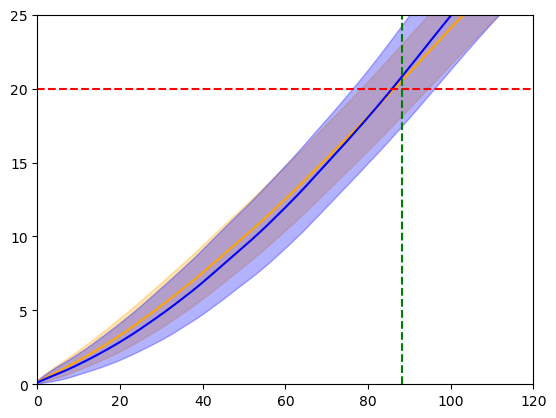

In [139]:
fig, ax = plt.subplots()
mean_cumsum_25 = comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).mean(axis=0)
var_cumsum_25 = comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).var(axis=0)
mean_cumsum_28 = comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).mean(axis=0)
var_cumsum_28 = comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).var(axis=0)
ax.plot(range(300), mean_cumsum_25, label = 'Average accumulated response, init 25', color = 'orange')
ax.fill_between(range(300), mean_cumsum_25 - np.sqrt(var_cumsum_25), mean_cumsum_25 + np.sqrt(var_cumsum_25), color = 'orange', alpha = 0.3)
ax.plot(range(300), comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).mean(axis=0), label = 'Average accumulated response, init 28', color = 'blue')
ax.fill_between(range(300), mean_cumsum_28 - np.sqrt(var_cumsum_28), mean_cumsum_28 + np.sqrt(var_cumsum_28), color = 'blue', alpha = 0.3)
ax.set_ylim((0, 25))
ax.set_xlim((0, 120))
ax.axhline(y=20, color='red', linestyle='--', label='Threshold')
ax.axvline(x = comp_frame_25['observed time to beginning of flowering'].mean(), color='green', linestyle='--', label='Mean observed flowering time')

In [177]:
ds = train_a
phase_list = ['beginning of flowering']
growing_period_length = 300
thresholds = [20]

lb = [0.01, 7, 20, 38.5]
ub = [5, 11, 31, 40]
bounds = scipy.optimize.Bounds(lb=lb[:2], ub = ub[:2])
x_list = []
for T_opt in np.arange(21, 30, 0.5)[:2]:
    print(f'Optimising T_opt = {T_opt}')
    fixed_params = [T_opt, 39]
    x0 = [0.5, 8]
    x = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE([x[0], x[1]] + fixed_params, ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                 x0, method = 'Nelder-Mead',
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)
    x_list.append(x)
    print(x)


Optimising T_opt = 21.0
Optimization terminated successfully.
         Current function value: 8.297087
         Iterations: 47
         Function evaluations: 98
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8.297087394551648
             x: [ 2.925e-01  7.031e+00]
           nit: 47
          nfev: 98
 final_simplex: (array([[ 2.925e-01,  7.031e+00],
                       [ 2.925e-01,  7.031e+00],
                       [ 2.925e-01,  7.031e+00]]), array([ 8.297e+00,  8.297e+00,  8.297e+00]))
Optimising T_opt = 21.5
Optimization terminated successfully.
         Current function value: 8.245860
         Iterations: 44
         Function evaluations: 96
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8.245859664444284
             x: [ 2.993e-01  7.020e+00]
           nit: 44
          nfev: 96
 final_simplex: (array([[ 2.993e-01,  7.020e+00],
                     

In [27]:
ds = ds_inputs_DE_reduced
phase_list = ['beginning of flowering']
growing_period_length = 300
thresholds = [20]
lb = [0.01, 7, 20, 38.5]
ub = [5, 11, 31, 40]
x_0_list3 = []
for T_opt in np.arange(20, 23, 0.5):
    print(f'Optimising T_opt = {T_opt}')
    fixed_params = [7.5, T_opt, 39]
    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type='Convolved', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})
    x_0_list3.append(x_0)
    print(x_0)


Optimising T_opt = 20.0
 
 Func-count     x          f(x)          Procedure
    1        1.91601      69.4551        initial
    2        3.09399       76.492        golden
    3        1.18798      58.9979        golden
    4       0.738031      43.7924        golden
    5       0.459948      21.9199        golden
    6       0.288083      16.6493        golden
    7       0.230244      39.1871        parabolic
    8       0.365636      9.98704        parabolic
    9        0.36161      9.60283        parabolic
   10       0.344275      8.61155        parabolic
   11       0.322812      9.67231        golden
   12       0.342537      8.58441        parabolic
   13       0.339826       8.5982        parabolic
   14       0.341728      8.58302        parabolic
   15       0.341893      8.58473        parabolic
   16       0.341002       8.5834        golden
   17       0.341543      8.58509        parabolic
   18       0.341658      8.58355        golden
   19       0.341791      8.581

In [28]:
x_0_list2 = x_0_list3 + x_0_list2

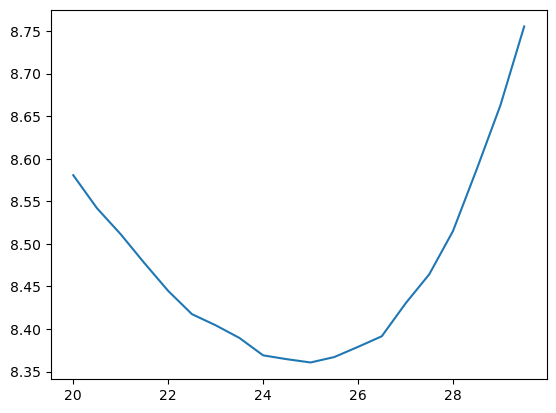

In [29]:
fig, ax = plt.subplots()
#ax.plot(np.arange(21, 30, 0.5), [x_0['x'] for x_0 in x_0_list])
RMSEs = [x_0['fun'] for x_0 in x_0_list2]
ax.plot(np.arange(20, 30, 0.5), RMSEs)

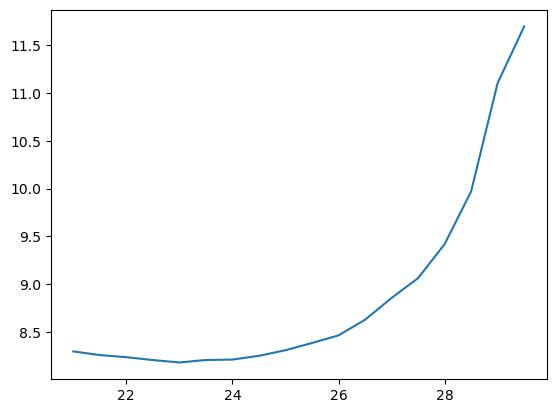

In [175]:
fig, ax = plt.subplots()
#ax.plot(np.arange(21, 30, 0.5), [x_0['x'] for x_0 in x_0_list])
RMSEs = [x_0['fun'] for x_0 in x_0_list]
ax.plot(np.arange(21, 30, 0.5), RMSEs)

In [61]:
x1s = [np.array([0.5, 8, 30, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
fm_flowering_all_DE3 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

Optimization terminated successfully.
         Current function value: 8.618254
         Iterations: 84
         Function evaluations: 172
[ 0.5  8.  30.  39. ] [ 0.503004    7.02058042 27.00252239 39.30655295] [-0.003004    0.97941958  2.99747761 -0.30655295]
RMSE at opt on test set:  8.546402647750035
R^2: 0.373829045123407


0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.34508471756281545
Bias: 1.2651237127487525 (sign 1.0)
Variance of modelled values: 106.14377387318557
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


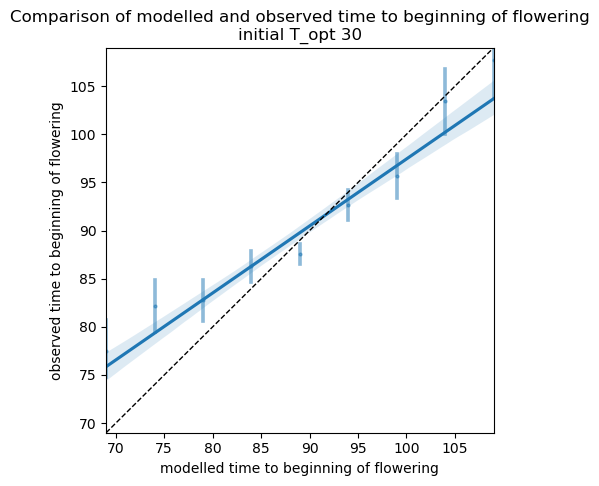

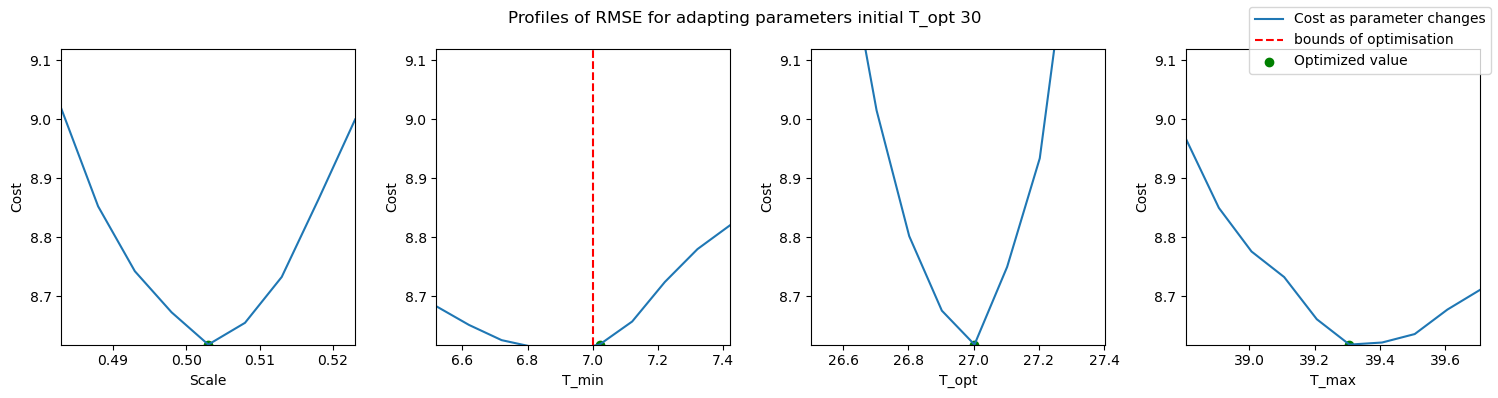

In [63]:
#train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
c_array = run_GDD(fm_flowering_all_DE[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='initial T_opt 30', method = 'regression', plot=True)
plot_profiles_at_minimum(fm_flowering_all_DE3[0][0], fm_flowering_all_DE[-2],#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 30')

0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.34508471756281545
Bias: 1.2651237127487525 (sign 1.0)
Variance of modelled values: 106.14377387318557
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


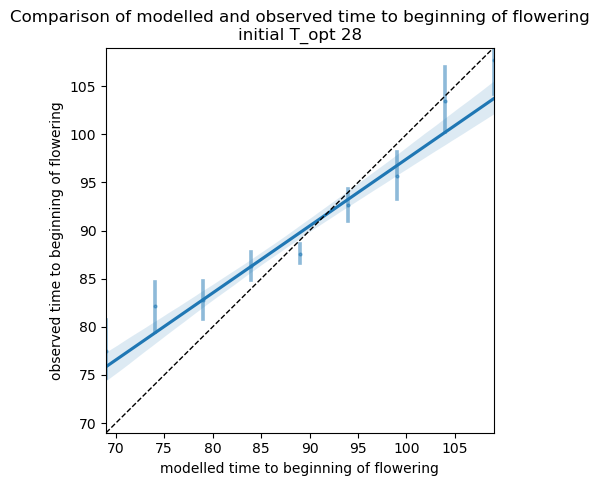

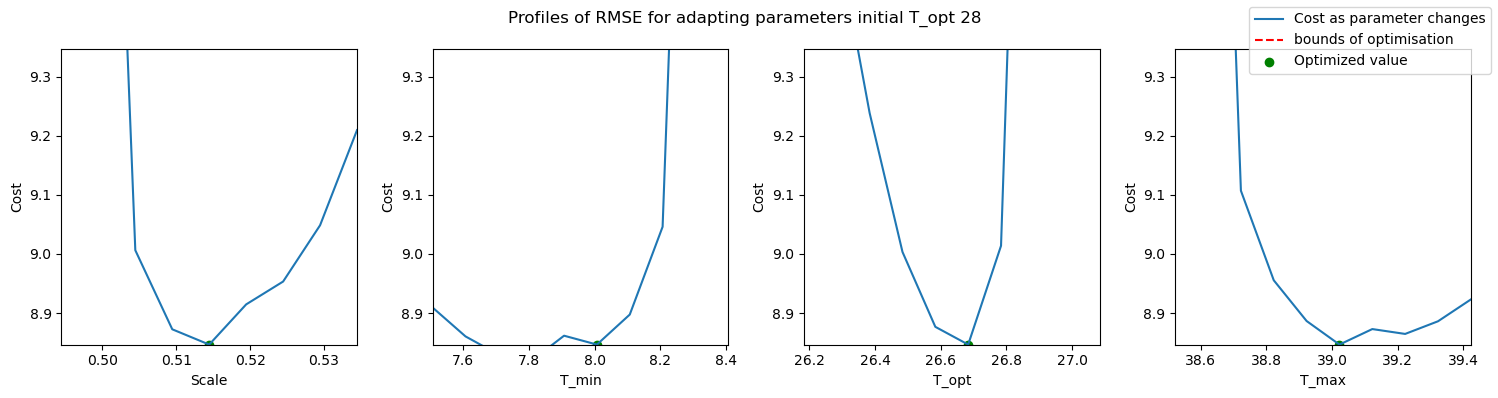

In [64]:
#train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
c_array = run_GDD(fm_flowering_all_DE[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='initial T_opt 28', method = 'regression', plot=True)
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], fm_flowering_all_DE[-2],#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 28')

In [102]:
fm_flowering_all_DE2[0][0]

array([ 0.34525542,  7.00219008, 23.57229066, 39.02041395])

0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.45605829903279316
Bias: 0.45640742117621186 (sign 1.0)
Variance of modelled values: 66.34161573720408
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


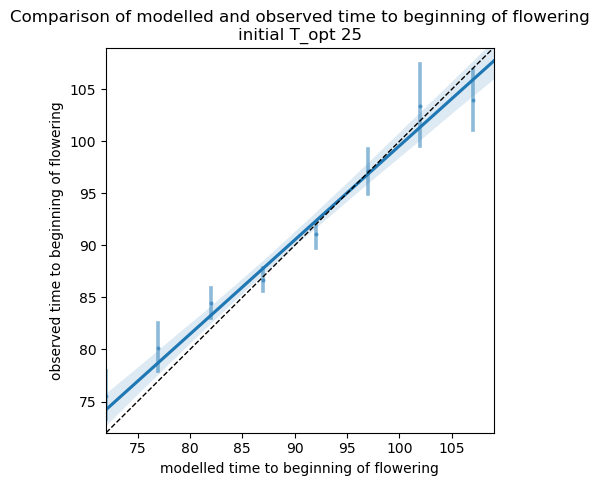

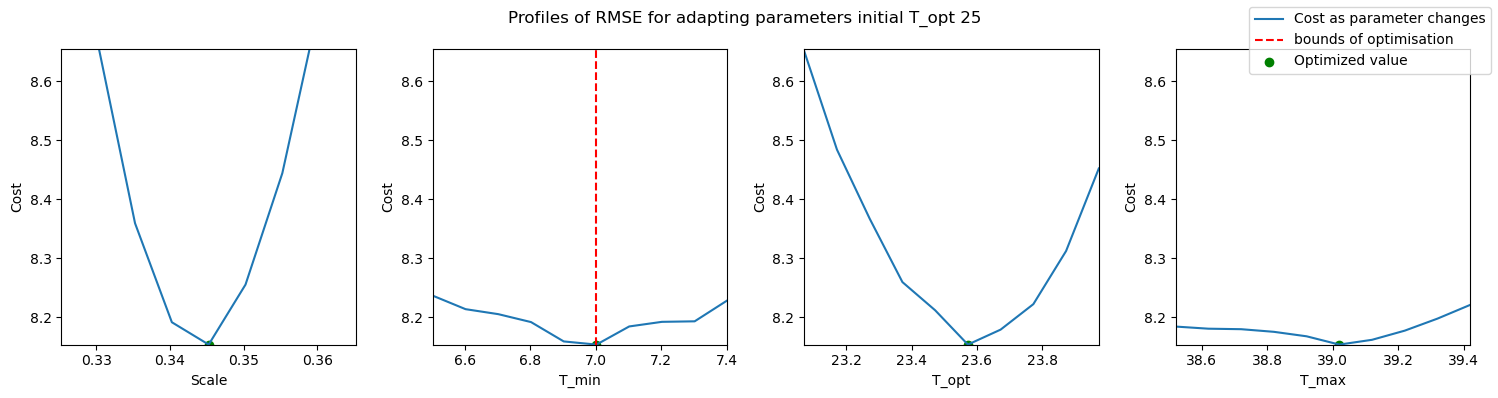

In [65]:
c_array = run_GDD(fm_flowering_all_DE2[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='initial T_opt 25', method = 'regression', plot=True)
plot_profiles_at_minimum(fm_flowering_all_DE2[0][0], fm_flowering_all_DE[-2],#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 25')

R^2 value for model: 0.413846226926438
Bias: 0.04473681486465441 (sign 1.0)
Variance of modelled values: 77.052308552582


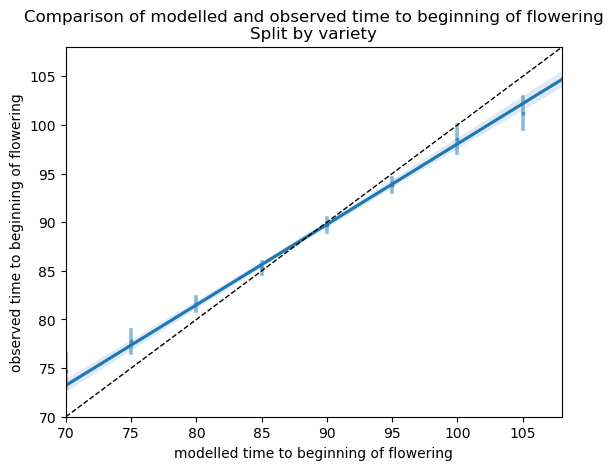

In [89]:
fig, axs = plt.subplots()
phase = 'beginning of flowering'
title_extra = 'Split by variety'
minval = min(separate_params[f'observed time to {phase}'].quantile(0.05), separate_params[f'modelled time to {phase}'].quantile(0.05)) - 1
maxval = max(separate_params[f'observed time to {phase}'].quantile(0.95), separate_params[f'modelled time to {phase}'].quantile(0.95)) + 1
sns.regplot(x=f'modelled time to {phase}', y=f'observed time to {phase}', data=separate_params, ax=axs,
            scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
axs.set_xlim(minval, maxval)
axs.set_ylim(minval, maxval)
axs.set_title(f'Comparison of modelled and observed time to {phase}\n{title_extra}')
rsquared = r2_score(separate_params[f'observed time to {phase}'], separate_params[f'modelled time to {phase}'])
print(f'R^2 value for model: {rsquared}')
bias = separate_params[f'observed time to {phase}'].mean() - separate_params[f'modelled time to {phase}'].mean()
variance_modelled = separate_params[f'modelled time to {phase}'].var()
print(f'Bias: {bias**2} (sign {np.sign(bias)})\nVariance of modelled values: {variance_modelled}')

0 stations out of 2780 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.4318997536927216
Bias: 0.18663643186170398 (sign 1.0)
Variance of modelled values: 59.744035430166626


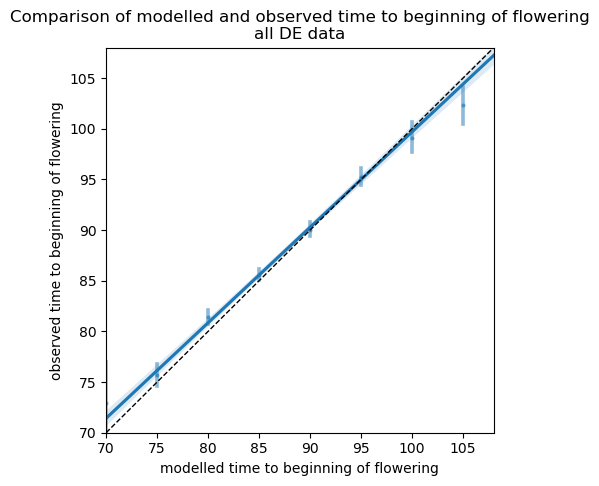

In [93]:
c_array = run_GDD(fm_flowering_all_DE_all[0][0], test_b, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='all DE data', method = 'regression', plot=True)

In [173]:
def adapt_and_plot(c_array):
    c_array['observed time to beginning of flowering'] = pd.to_timedelta(c_array['observed time to beginning of flowering'], 'D')
    plot_from_comparison_array(c_array, title_extra='separate parameters', method='histogram')

0 stations out of 2780 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.413846226926438
Bias: 0.04473681486465441
Variance of modelled values: 77.052308552582
R^2 value for model: 0.413846226926438
Bias: 0.04473681486465441 (sign 1.0)
Variance of modelled values: 77.052308552582


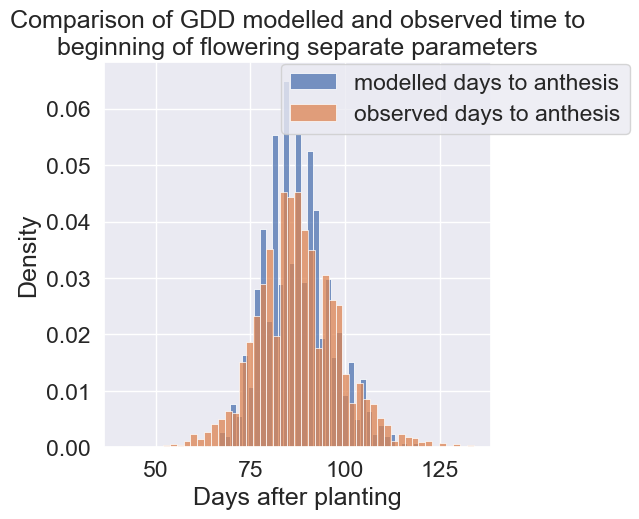

In [175]:
adapt_and_plot(separate_params)

0 stations out of 2780 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.4318997536927216
Bias: 0.18663643186170398
Variance of modelled values: 59.744035430166626
R^2 value for model: 0.4318997536927216
Bias: 0.18663643186170398 (sign 1.0)
Variance of modelled values: 59.744035430166626


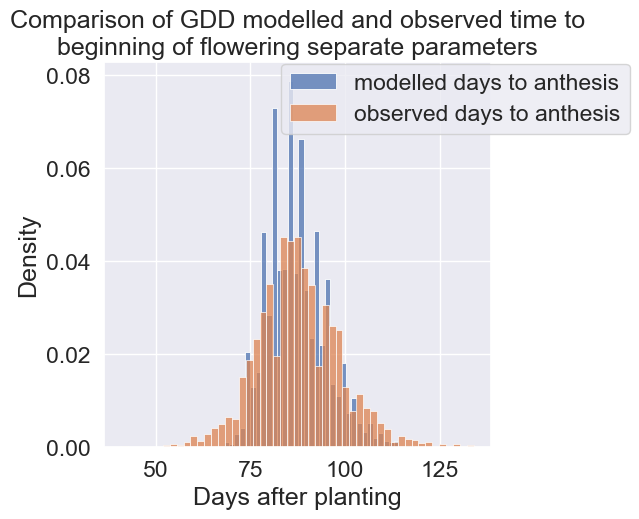

In [174]:
adapt_and_plot(c_array)

In [ ]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]
fm_flowering_tc, res = local_opt(x1s, ds_inputs_SSA, 
                     lower_bounds = [0.01, 7, 27, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.5, maxiter = 100, random_state = 1)

In [ ]:
x_opt = one_by_one_optimisation(fm_flowering_tc[0], train_a, #np.array(x_opt)
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300,
                         thresholds = [20])

Plotting Scale
Plotting T_min
Plotting T_opt


KeyboardInterrupt: 

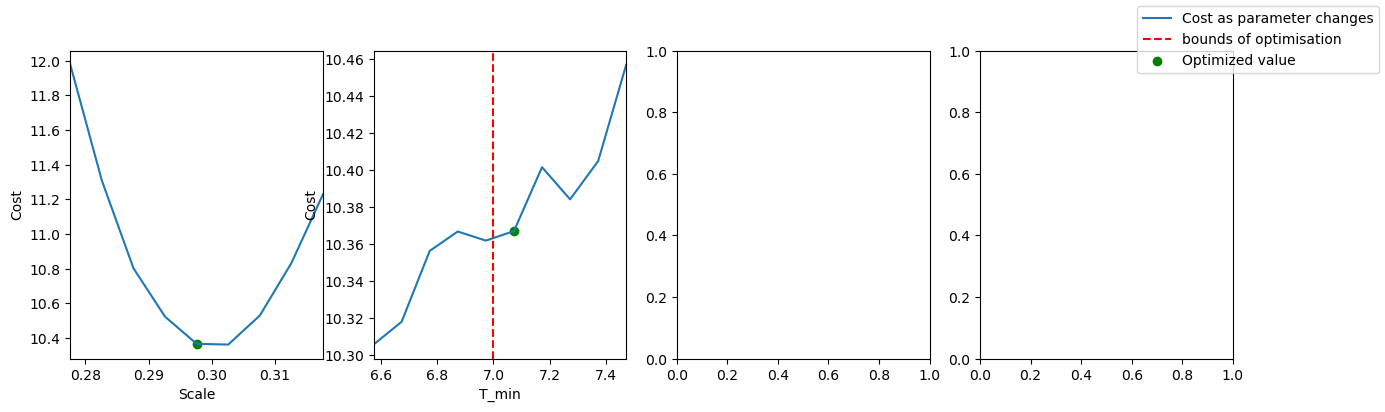

In [39]:
train_a, test_a = train_test_split(ds, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_tc[0], train_a, #fm2s[0], ds2, #fm2s[0] x_opt np.array([x_opt[0], 7, 25, 40])
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20])

In [212]:
start_year = 2000
end_year = 2023
step = 2
response_type = 'Wang'
phase_list = ['yellow ripeness']
method = 'trust-constr', 
modified_cost = False, 
thresholds = [100], 
growing_period_length = 185,
maxiter = 50
x1s = [np.array([0.3, 6, 29.5, 42])]
param_list = []
for year in range(start_year, end_year, step):
    ds2_warm_period = ds2_warm.loc[(ds2_warm['Referenzjahr'] >= year)*(ds2_warm['Referenzjahr'] < year + step)]
    fms, res = local_opt(x1s, ds2_warm_period, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300, split = False)
    plot_profiles_at_minimum(fms[0], ds2_warm_period, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])
    param_list.append(fms[0])
    #print(ds2_warm_period)


NameError: name 'ds2_warm' is not defined

In [15]:
x1s = [np.array([0.3, 6, 29.5, 42])]
#x1s = [fms[0]]
fm_all_ripeness, res = local_opt(x1s, ds2, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300)

Optimization terminated successfully.
         Current function value: 14.168034
         Iterations: 130
         Function evaluations: 237
[ 0.3  6.  29.5 42. ] [ 0.24281304  5.00383729 28.15685861 43.96110362] [ 0.05718696  0.99616271  1.34314139 -1.96110362]
RMSE at opt on test set:  19.941897092174766
R^2: -0.029379434800168136


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


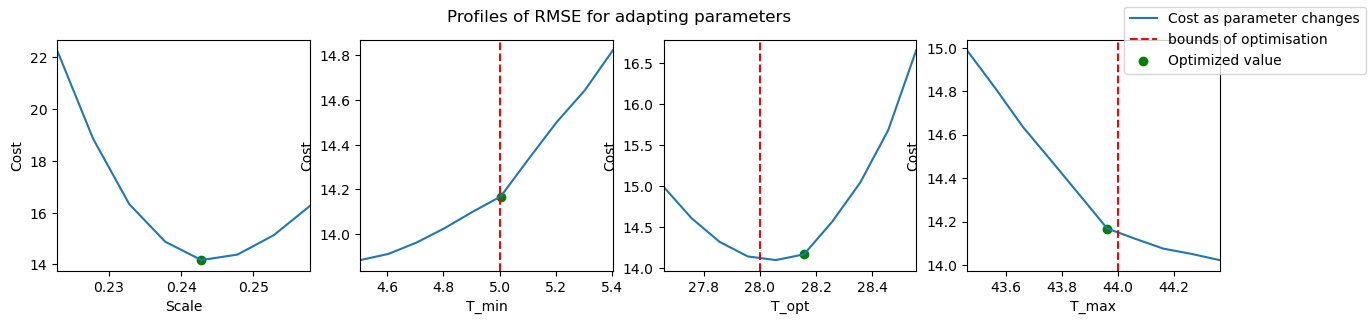

In [21]:
train, test = train_test_split(ds2, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm_all_ripeness[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [16]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.3, 6, 29.5, 42])]
fms, res = local_opt(x1s, ds2_cold, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20])


Optimization terminated successfully.
         Current function value: 13.376611
         Iterations: 107
         Function evaluations: 206
[ 0.3  6.  29.5 42. ] [ 0.25222093  5.01214034 28.02067488 43.695618  ] [ 0.04777907  0.98785966  1.47932512 -1.695618  ]
RMSE at opt on test set:  17.82466439988874
R^2: 0.12521048556632275


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


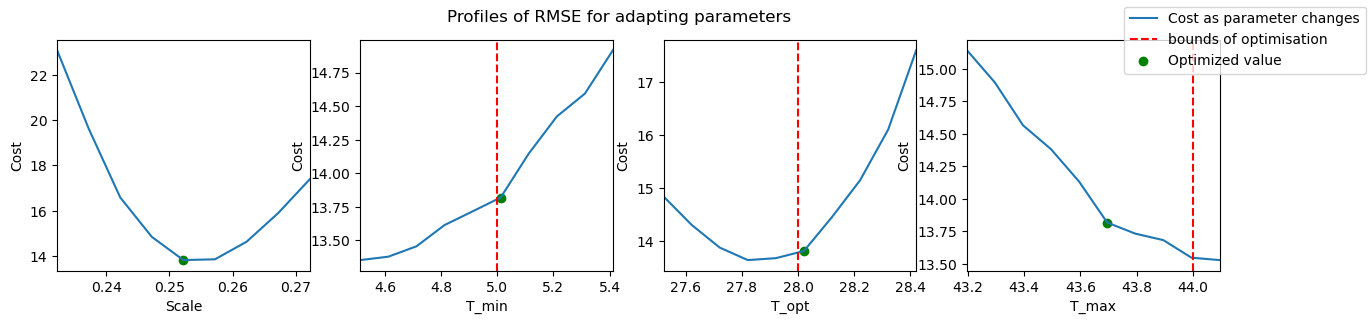

In [17]:
train, test = train_test_split(ds2_cold, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fms[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [30]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.3, 6, 29.5, 42])]
#x1s = [fms[0]]
fm2s, res = local_opt(x1s, ds2_warm, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300)

NameError: name 'ds2_warm' is not defined

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


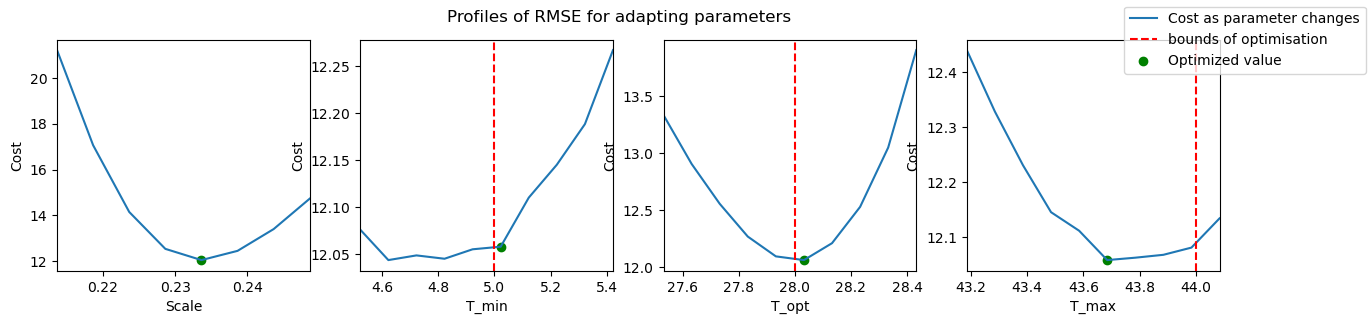

In [19]:
train, test = train_test_split(ds2_warm, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm2s[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])


In [120]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm3s, res = local_opt(x1s, ds_warm, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=200)
train_a, test_a = train_test_split(ds, test_size=0.5, random_state = 1)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +2.0043e+01 | 1.00e+00 | 2.91e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +2.0972e+01 | 7.00e+00 | 4.15e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |   5   | +1.5255e+01 | 7.00e+00 | 1.88e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |   4   |   8   | +1.1401e+01 | 7.00e+00 | 1.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   |   6   |  12   | +1.1401e+01 | 7.00e-01 | 1.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   6   |   7   |  15   | +1.1347e+01 | 7.00e-01 | 1.54e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |   8   |  18   | +1.1286e+01 | 7.00e-01 | 1.54e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |   9   |  21   | +9.5472e+00 | 1.40e+

c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  41   |  61   |  72   | +9.5413e+00 | 1.76e-02 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  42   |  63   |  74   | +9.5413e+00 | 8.82e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  43   |  64   |  75   | +9.5413e+00 | 4.41e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  44   |  65   |  76   | +9.5413e+00 | 2.20e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  45   |  67   |  77   | +9.5413e+00 | 9.35e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  46   |  68   |  78   | +9.5413e+00 | 4.67e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  47   |  70   |  79   | +9.5413e+00 | 1.99e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  48   |  72   |  80   | +9.5413e+00 | 4.29e-05 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  49   |  74   |  81   | +9.5413e+00 | 7.43e-06 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  50   |  76   |  82   | +9.5413e+00 | 3.72e-

In [ ]:
plot_profiles_at_minimum(fm3s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [40]:
x1s = [np.array([0.8, 8, 28, 39])]
fm_flowering_all_DE = local_opt(x1s, ds_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 9.838051
         Iterations: 138
         Function evaluations: 274
[ 0.8  8.  28.  39. ] [ 0.60195695  8.2342903  28.64357561 39.46867037] [ 0.19804305 -0.2342903  -0.64357561 -0.46867037]
RMSE at opt on test set:  10.001840890158821
R^2: 0.0766758382928796


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


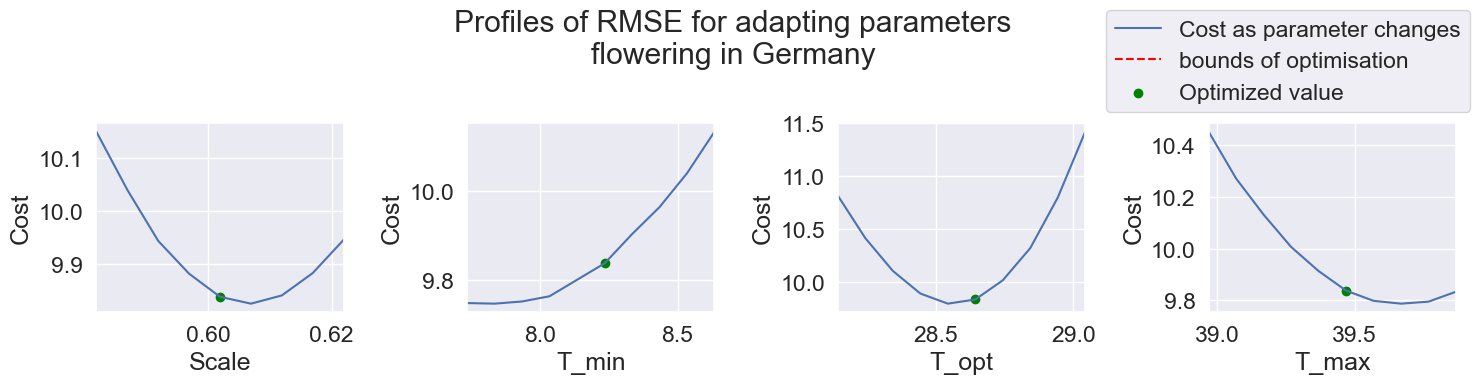

In [42]:
train_a, test_a = train_test_split(ds_DE, test_size=0.5, random_state = 1)
sns.set(font_scale=1.5) #[fm_flowering_all_DE[0][0][0], 7, 25, 40]
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], train_a, #fm2s[0], ds2, #fm2s[0] #fm_flowering_all[0][0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20], title = '\nflowering in Germany')

In [25]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm5s, res = local_opt(x1s, ds_warm, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 8.309354
         Iterations: 110
         Function evaluations: 237
[ 0.8  8.  28.  39. ] [ 0.38455098  7.85891439 25.01171837 38.67322138] [0.41544902 0.14108561 2.98828163 0.32677862]
RMSE at opt on test set:  8.268961093512054
R^2: 0.3372506254579203


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


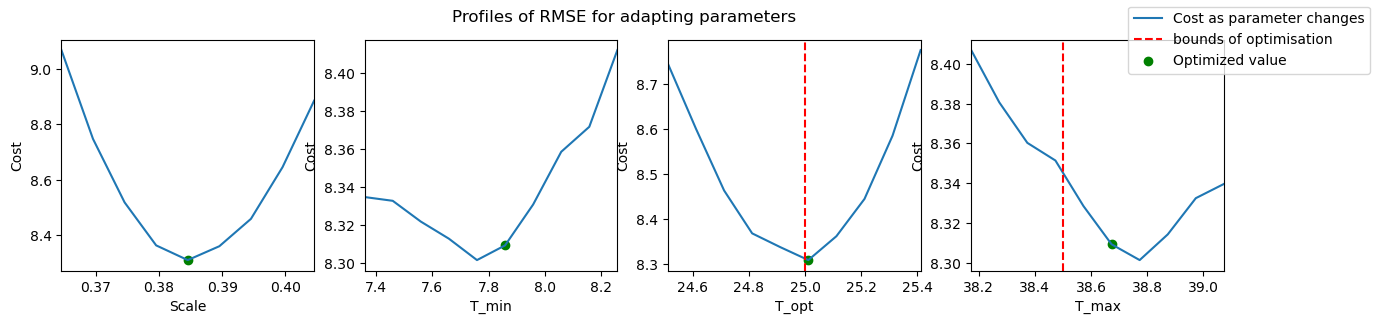

In [26]:
train_a, test_a = train_test_split(ds_warm, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm5s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [29]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm6s, res = local_opt(x1s, ds_cold, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 8.683780
         Iterations: 196
         Function evaluations: 353
[ 0.8  8.  28.  39. ] [ 0.37629408  7.08260145 25.02142537 39.63852827] [ 0.42370592  0.91739855  2.97857463 -0.63852827]
RMSE at opt on test set:  8.666066536777695
R^2: 0.35085707964200563


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


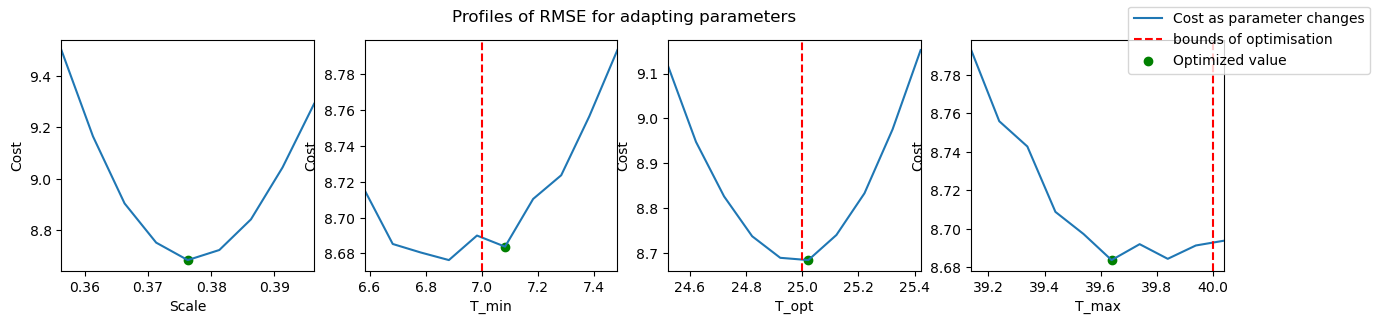

In [30]:
train_a, test_a = train_test_split(ds_cold, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm6s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [36]:
parameter_data = np.concatenate([np.array([fm_all_ripeness[0]]), 
                                 np.array([fm2s[0]]), np.array([fms[0]]), 
                                 np.array([fm_flowering_all[0][0]]), 
                                 np.array([fm5s[0]]), 
                                 np.array([fm6s[0]])], axis=0)

In [47]:
column_names = ['Scale (thermal time requirement)', 'T_min', 'T_opt',  'T_max']
row_names = np.array(['Full set, ripeness', 'Warm set, ripeness', 'Cold set, ripeness',
                      'Full set, flowering', 'Warm set, flowering', 'Cold set, flowering'])
R2s = np.array([-0.029379434800168136, 0.33311833790242984, 0.12521048556632275,
                0.3281956184199428, 0.3372506254579203, 0.35085707964200563])
parameters_frame = pd.DataFrame(parameter_data, columns = column_names, index = row_names)
parameters_frame['R2'] = R2s

In [62]:
np.round(parameters_frame, decimals = 2)

Scale  T_min  T_opt  T_max    R2
Full set, ripeness    0.24   5.00  28.16  43.96 -0.03
Warm set, ripeness    0.23   5.02  28.03  43.68  0.33
Cold set, ripeness    0.25   5.01  28.02  43.70  0.13
Full set, flowering   0.38   7.01  25.07  38.89  0.33
Warm set, flowering   0.38   7.86  25.01  38.67  0.34
Cold set, flowering   0.38   7.08  25.02  39.64  0.35

In [15]:
def one_by_one_optimisation(x0, ds, lb, ub, phase_list = ['yellow ripeness'], thresholds = [10], growing_period_length = 200, response_type = 'Wang', ):
    fixed_params = x0.copy()[1:].tolist()
    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})

    T_min = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, x] + fixed_params[1:], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[1], ub[1]),
                                                method='bounded',
                                                options = {'disp': 3})
                            
    T_opt = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, T_min.x, x] + fixed_params[2:], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[2], ub[2]),
                                                method='bounded',
                                                options = {'disp': 3})
    T_max = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, T_min.x, T_opt.x, x], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[3], ub[3]),
                                                method='bounded',
                                                options = {'disp': 3})

    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x, T_min.x, T_opt.x, T_max.x], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})


    x_opt = [x_0.x, T_min.x, T_opt.x, T_max.x]
    return x_opt

In [20]:
x_opt = one_by_one_optimisation(fm3s[0], train_a,
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200,
                         thresholds = [20])

 
 Func-count     x          f(x)          Procedure
    1        1.91601      46.0385        initial
    2        3.09399      55.7688        golden
    3        1.18798       33.381        golden
    4       0.738031      16.4724        golden
    5       0.459948      17.5153        golden
    6       0.632022      10.8563        parabolic
    7       0.604678      9.86623        parabolic
    8       0.549396      9.82621        golden
    9       0.576194      9.44314        parabolic
   10        0.57635      9.44053        parabolic
   11        0.58717      9.52115        golden
   12       0.580067      9.44998        parabolic
   13       0.577953      9.45067        parabolic
   14       0.576354      9.44093        parabolic
   15       0.576282      9.44159        parabolic
   16       0.576324      9.44061        golden
   17       0.576338      9.44071        parabolic
   18       0.576345       9.4405        golden
   19       0.576342      9.44068        parabolic

Opt

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


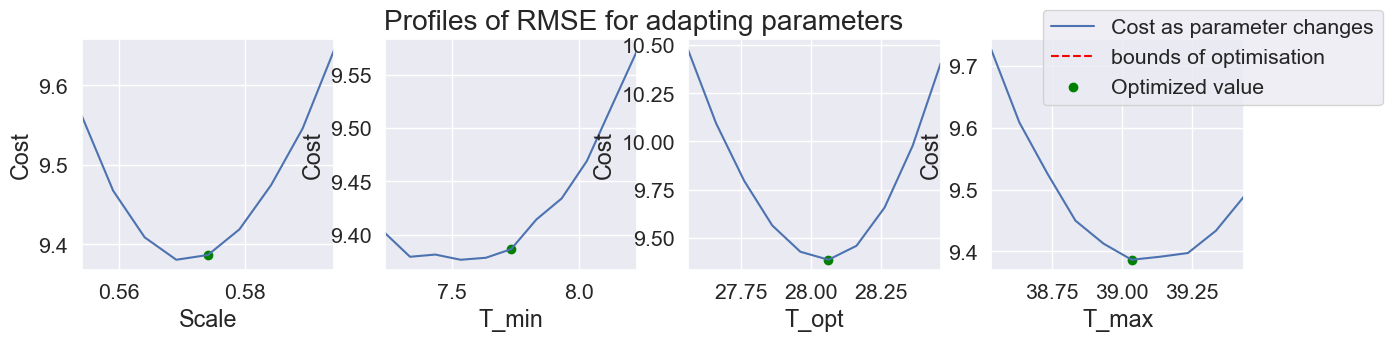

In [23]:
plot_profiles_at_minimum(x_opt, train_a,
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [18]:
def global_search(ds, param_values,
                     N = 200, 
                     interesting_threshold = 16, great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness']):
    np.random.seed(10)
    count_tested = 0
    results_array = pd.DataFrame(columns = ['Tmin', 'Topt', 'Tmax', 'optimised scale', 'RMSE'])
    for Tmin_index, Tmin in enumerate(param_values[0]):
        for Topt_index, Topt in enumerate(param_values[1]):
            for Tmax_index, Tmax in enumerate(param_values[2]):
                x0 = [0.12, Tmin, Topt, Tmax]
                constraint_violation = x0[1] < x0[0] or x0[2] < x0[1]
                if constraint_violation:
                    print(x0, 'goes against constraints')
                    continue
                fixed_params = [Tmin, Topt, Tmax]
                x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type=response_type, phase_list = phase_list),
                                                    bounds = (0.05, 1.5),
                                                    method='bounded',
                                                    options = {'disp': 2})
                x1 = np.array([x_0.x] + fixed_params)
                opt_value = run_GDD_and_get_RMSE(x1, ds, 't2m', response_type=response_type,  phase_list = phase_list)
                new_row = pd.DataFrame({'Tmin':[Tmin], 'Topt':[Topt], 'Tmax':[Tmax], 'optimised scale':[x1[0]], 'RMSE':[opt_value]})
                count_tested += 1
                print(f'{count_tested} samples considered')
                results_array = pd.concat([results_array, new_row])
                print(results_array)
    return results_array

0 stations out of 114 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.23804860204298983
Bias: 3.6904432132963905 (sign -1.0)
Variance of modelled values: 99.94853283651608


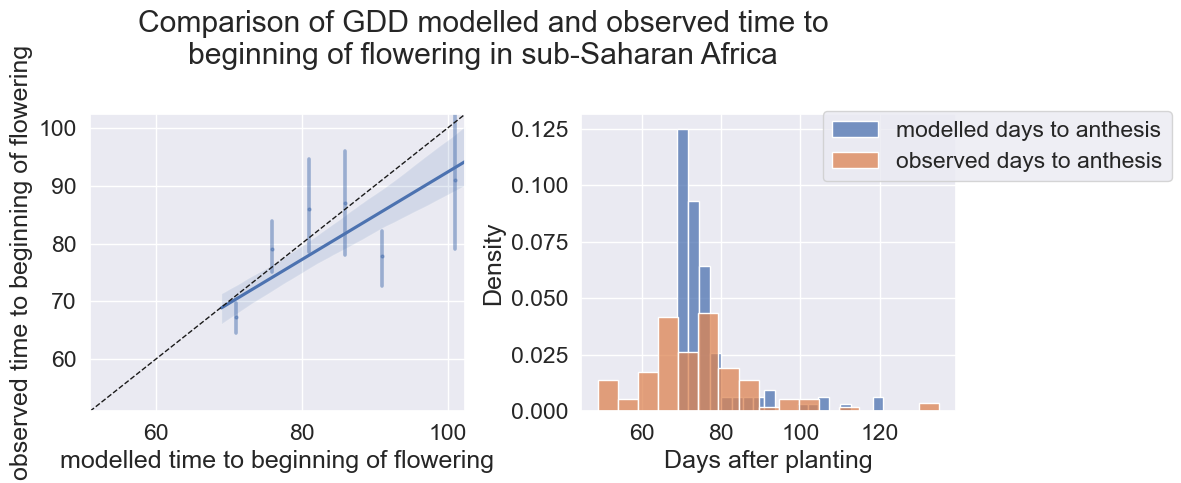

In [79]:
fm_flowering_all_DE = np.array([0.34020292, 7.24511043, 24.10650321, 39.69694962])#DE params
#fm_flowering_all_DE = np.array([0.29237735, 7.5983653, 24.73654165, 39.54685523])#SSA params
fm_flowering_all_DE = np.array([0.29432022, 7.00296687, 25.27906453, 39.96888553])
#fm_flowering_all_DE = np.array([0.37700293, 7.93566179, 28.01052802, 39.95536985])
train_a, test_a = train_test_split(ds_inputs_SSA, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_plot(fm_flowering_all_DE, test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20],  method = 'both', title_extra = 'in sub-Saharan Africa', savename = 'SSA_GDD_skill.png')#np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

0 stations out of 3061 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.4191269675053191
Bias: 0.0038528361730301858 (sign 1.0)
Variance of modelled values: 81.44009817800546


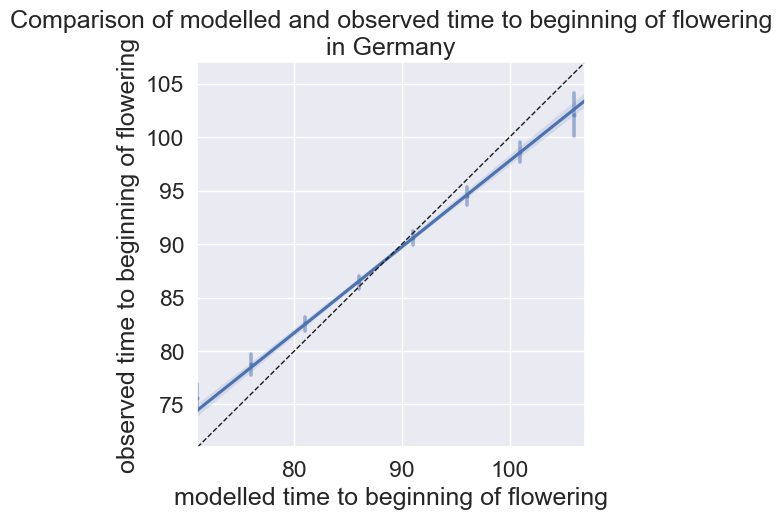

In [106]:
#fm_flowering_all_DE = np.array([0.34020292, 7.24511043, 24.10650321, 39.69694962])#DE params
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
ca_flowering = run_GDD_and_plot(fm_flowering_all_DE[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20],  method = 'regression', title_extra = 'in Germany', savename = 'DE_GDD_skill.png')

In [84]:
fm_flowering_all_DE[0]

[array([ 0.36937929,  8.99032142, 24.2238229 , 39.23548472])]

8 stations out of 1404 did not reach the end of phase 'yellow ripeness'
R^2 value for model: 0.07936085266295356
Bias: 8.17780750562087 (sign 1.0)
Variance of modelled values: 200.14510369517527


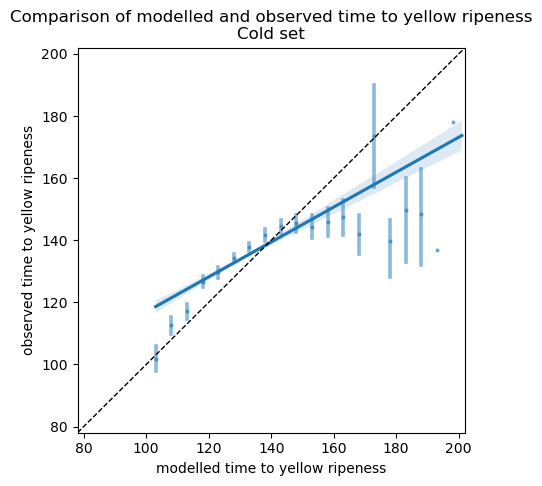

In [54]:
train, test = train_test_split(ds2_cold, test_size=0.5, random_state = 1)
ca_ripeness_cold = run_GDD_and_scatter_plot(fms[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Cold set')

0 stations out of 2540 did not reach the end of phase 'yellow ripeness'
R^2 value for model: 0.33285568265938137
Bias: 0.4453197656395564 (sign 1.0)
Variance of modelled values: 121.66391008922236


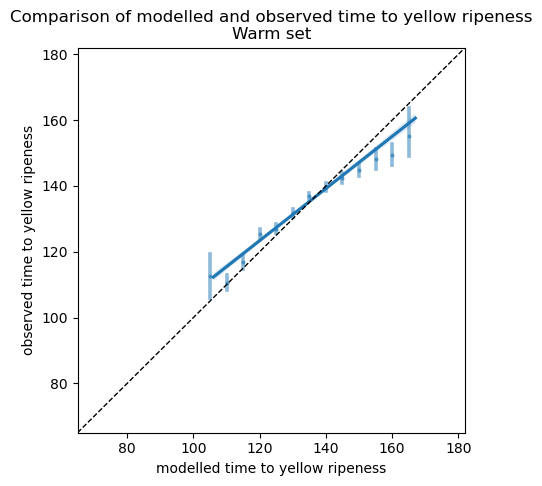

In [55]:
train, test = train_test_split(ds2_warm, test_size=0.5, random_state = 1)
ca_ripeness = run_GDD_and_scatter_plot(fm2s[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Warm set')

39 stations out of 3944 did not reach the end of phase 'yellow ripeness'
R^2 value for model: -0.029640499835624334
Bias: 2.9421295320080136 (sign 1.0)
Variance of modelled values: 221.68053374943779


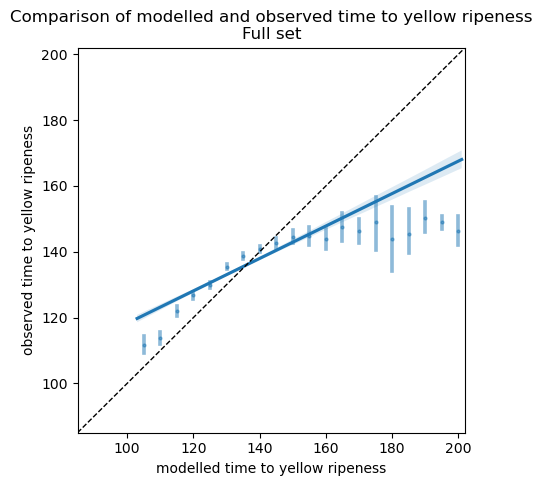

In [56]:
train, test = train_test_split(ds2, test_size=0.5, random_state = 1)
ca_ripeness = run_GDD_and_scatter_plot(fm_all_ripeness[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Full set')

Text(0.5, 1.0, 'Discrepancy between GDD model and CCNN')

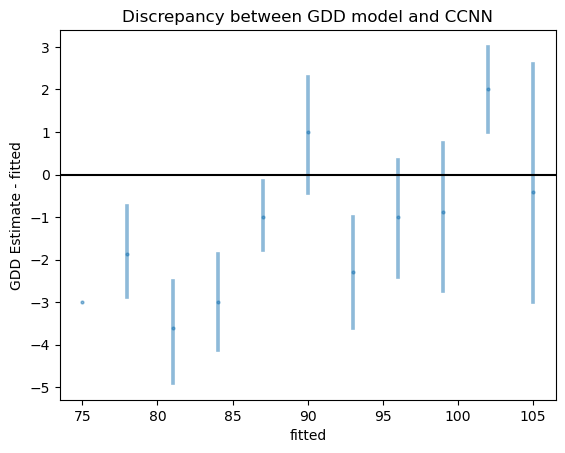

In [26]:
train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_output.csv')
train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
train = pd.merge(ds_inputs_DE, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
test = pd.merge(ds_inputs_DE, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
check = pd.merge(test_indices[['Stations_id', 'Referenzjahr', 'fitted', 'observed']], ca_flowering[['Stations_id', 'Referenzjahr', 'modelled time to beginning of flowering']], on = ['Stations_id', 'Referenzjahr'])
#check['fitted'] = check['fitted'] - check['observed']
#check['modelled time to beginning of flowering'] = check['modelled time to beginning of flowering'] - check['observed']
check['discrepancy'] = check['modelled time to beginning of flowering'] - check['fitted']
maxval = check['fitted'].max()#max(check['fitted'].max(), check['discrepancy'].max())
minval = check['fitted'].min()#min(check['fitted'].min(), check['discrepancy'].min())
fig, ax = plt.subplots()
sns.regplot(x='fitted', y='discrepancy', data = check, ax=ax,
            scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
            fit_reg = False)
#fig, ax = plt.subplots()
#sns.regplot(x = 'modelled time to beginning of flowering', y = 'fitted', data = check, ax = ax)
#ax.plot([minval - 5, maxval + 5], [minval - 5, maxval + 5], color = 'k')
ax.set_ylabel('GDD Estimate - fitted')
ax.axhline(0, color = 'k')
ax.set_title('Discrepancy between GDD model and CCNN')

Text(0.5, 1.0, 'Comparison between residuals for CCNN and GDD model')

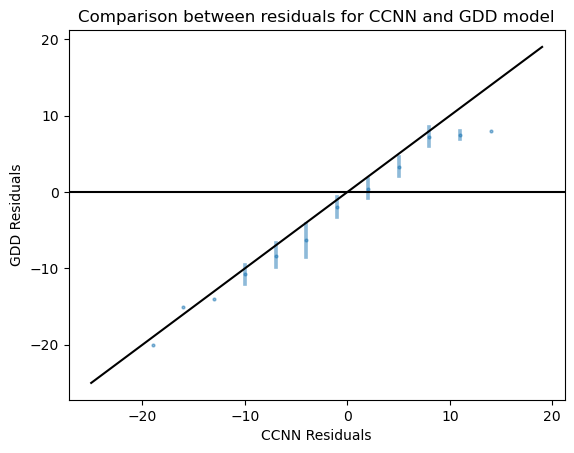

In [44]:
train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_output.csv')
train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
train = pd.merge(ds_inputs_DE, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
test = pd.merge(ds_inputs_DE, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
check = pd.merge(test_indices[['Stations_id', 'Referenzjahr', 'fitted', 'observed']], ca_flowering[['Stations_id', 'Referenzjahr', 'modelled time to beginning of flowering']], on = ['Stations_id', 'Referenzjahr'])
check['GDD Residuals'] = check['modelled time to beginning of flowering'] - check['observed']
check['CCNN Residuals'] = check['fitted'] - check['observed']
maxval = max(check['GDD Residuals'].max(), check['CCNN Residuals'].max())
minval = min(check['GDD Residuals'].min(), check['CCNN Residuals'].min())
fig, ax = plt.subplots()
sns.regplot(x='CCNN Residuals', y='GDD Residuals', data = check, ax=ax,
            scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
            fit_reg = False)
#fig, ax = plt.subplots()
#sns.regplot(x = 'modelled time to beginning of flowering', y = 'fitted', data = check, ax = ax)
ax.plot([minval - 5, maxval + 5], [minval - 5, maxval + 5], color = 'k')
#ax.set_ylabel('GDD Estimate - fitted')
ax.axhline(0, color = 'k')
ax.set_title('Comparison between residuals for CCNN and GDD model')

In [46]:
check

Stations_id  Referenzjahr  fitted  observed  \
0       12258.0        2020.0    97.0     102.0   
1       12563.0        2022.0    92.0      84.0   
2       15460.0        2019.0    83.0      74.0   
3       11533.0        2017.0    88.0      90.0   
4        8535.0        2018.0    83.0      77.0   
..          ...           ...     ...       ...   
82      13011.0        2022.0    77.0      85.0   
83      11162.0        2017.0    96.0      97.0   
84       8333.0        2017.0    91.0      87.0   
85       8360.0        2021.0   105.0     100.0   
86      15508.0        2018.0    82.0      84.0   

    modelled time to beginning of flowering  GDD Residuals  CCNN Residuals  
0                                      90.0          -12.0            -5.0  
1                                      89.0            5.0             8.0  
2                                      82.0            8.0             9.0  
3                                      90.0            0.0            -2.0  
4                                      79.0            2.0             6.0  
..                                      ...            ...             ...  
82                                     73.0          -12.0            -8.0  
83                                     97.0            0.0            -1.0  
84                                     93.0            6.0             4.0  
85                                    110.0           10.0             5.0  
86                                     79.0           -5.0            -2.0  

[87 rows x 7 columns]

In [23]:
#test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_output.csv')
compare_results = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
compare_results = compare_results.rename(columns = {'Stations_id': 'Referenzjahr', 'year': 'Stations_id'})
test = pd.merge(ds_inputs_DE, compare_results[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
check = pd.merge(compare_results[['Stations_id', 'Referenzjahr', 'Temp model', 'SAT model', 'observed']], ca_flowering[['Stations_id', 'Referenzjahr', 'modelled time to beginning of flowering']], on = ['Stations_id', 'Referenzjahr'])

In [57]:
arr = torch.tile(torch.arange(-5, 7), (4, 1))
indices = np.tile(np.arange(0, 12), (4, 1)).astype(np.float64)
indices[arr > 0] = np.nan
np.nanmax(indices, axis=0)

NameError: name 'torch' is not defined

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6396\1201343894.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([check['modelled time to beginning of flowering'] - check['observed'],


Text(0.5, 0, 'Residuals DTF')

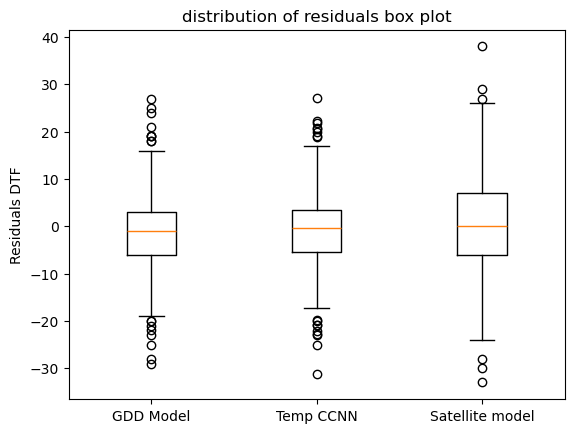

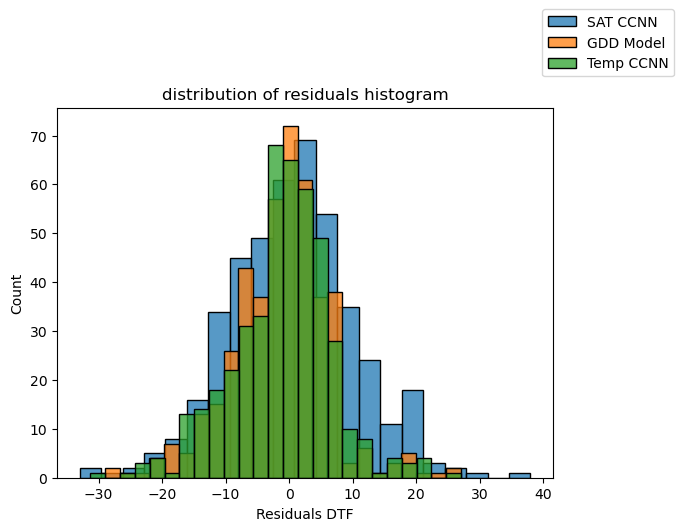

In [34]:
fig, ax = plt.subplots()
ax.boxplot([check['modelled time to beginning of flowering'] - check['observed'], 
            check['Temp model'] - check['observed'], 
            check['SAT model'] - check['observed']],  labels = ['GDD Model', 'Temp CCNN', 'Satellite model'])
ax.set_ylabel('Residuals DTF')
ax.set_title('distribution of residuals box plot')
fig, ax = plt.subplots()
sns.histplot(check['SAT model'] - check['observed'], label = 'SAT CCNN', ax=ax)
sns.histplot(check['modelled time to beginning of flowering'] - check['observed'], label = 'GDD Model', ax=ax)
sns.histplot(check['Temp model'] - check['observed'], label = 'Temp CCNN', ax=ax)
fig.legend(bbox_to_anchor = (1.1, 1.1))
ax.set_title('distribution of residuals histogram')
ax.set_xlabel('Residuals DTF')

In [43]:
import skill_metrics as sm
taylor_stats1 = sm.taylor_statistics(check['Temp model'],check['observed'],'data')
taylor_stats2 = sm.taylor_statistics(check['SAT model'],check['observed'],'data')
taylor_stats3 = sm.taylor_statistics(check['modelled time to beginning of flowering'],check['observed'],'data')

In [44]:
sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                    taylor_stats2['sdev'][1], taylor_stats3['sdev'][1]])
crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                    taylor_stats2['crmsd'][1], taylor_stats3['crmsd'][1]])
ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                    taylor_stats2['ccoef'][1], taylor_stats3['ccoef'][1]])

In [50]:
label = ['Temp CCNN', 'Temp CCNN', 'SAT CCNN', 'GDD']

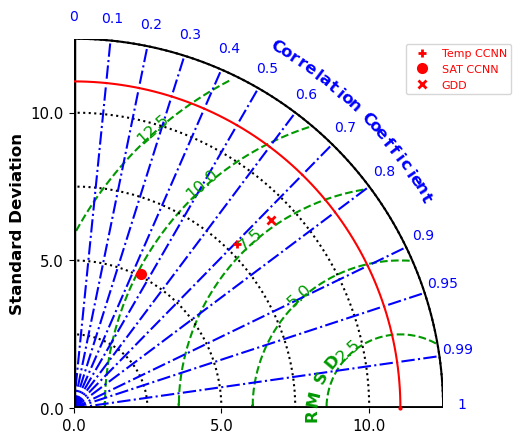

In [52]:
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label, markerLabelColor = 'r', 
                          markerLegend = 'on', markerColor = 'r',
                          styleOBS = '-', colOBS = 'r', markerobs = 'o',
                          markerSize = 6,)

0 stations out of 441 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.5073419290278791
Bias: 0.26729603405989316 (sign 1.0)
Variance of modelled values: 85.37001649144494


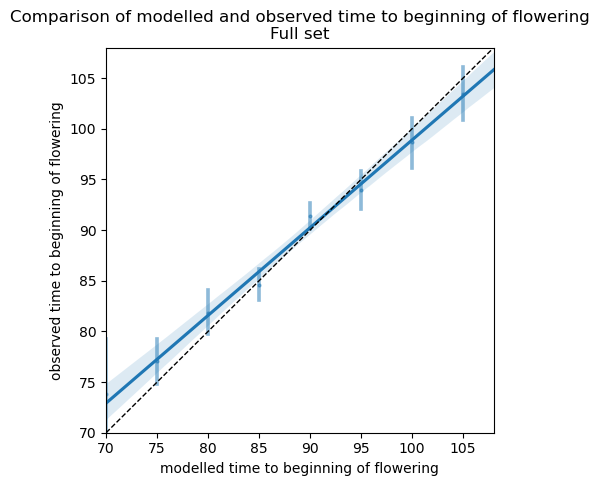

In [22]:
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
#train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
test_indices = test_indices.rename(columns = {'Stations_id': 'Referenzjahr', 'year': 'Stations_id'})
test = pd.merge(ds_inputs_DE, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
complement_indices = ds_inputs_DE.index.difference(test.index)

fm_flowering_all_DE = np.array([0.36883787, 7.33177754, 25.34427389, 39.48075322])
# Filter df2 to keep only the rows with the complement indices
train = ds_inputs_DE.loc[complement_indices]
#train = pd.merge(ds, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
#test = pd.merge(ds_inputs_DE, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
ca_flowering = run_GDD_and_plot(fm_flowering_all_DE, test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')#np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

In [102]:
ca_flowering[['modelled time to beginning of flowering', 'observed time to beginning of flowering']]
ca_late_pred = ca_flowering.loc[ca_flowering['modelled time to beginning of flowering'] > 110]#ca_flowering['observed time to beginning of flowering'] + 15]

In [105]:
ca_late_pred.to_csv('Saved_files/ca_late_pred.csv', index = False)

In [104]:
ca_late_pred

Unnamed: 0.1  Unnamed: 0 Planting date  Referenzjahr  Stations_id  \
77            8879       47091    2004-04-23          2004        11458   
186           3521       20168    2020-04-16          2020         9291   
302           3493       19942    2010-04-16          2010         9278   
363            288        2494    2015-04-18          2015         7730   
386             35         410    2010-04-15          2010         7566   
407           7462       41644    2004-04-28          2004        11088   
687          12949       67986    2004-04-27          2004        13458   
710          11634       60425    2004-04-26          2004        12810   
767           3492       19926    2009-04-10          2009         9278   
788          13362       69793    2002-04-10          2002        13646   
877            308        2574    2020-03-30          2020         7736   
919            220        2192    2015-04-18          2015         7700   
934           1124        7930    2014-03-22          2014         8104   
1034          3192       18674    2014-03-29          2014         9164   
1058          7469       41651    2011-04-18          2011        11088   
1129         11712       60992    2014-03-28          2014        12833   
1253         10115       52066    2014-04-10          2014        11878   
1259           354        2762    2010-04-13          2010         7748   
1328          4432       24922    2001-04-10          2001         9768   
1344          4435       24925    2004-04-16          2004         9768   
1371         13443       70543    2010-04-19          2010        13789   
1563          7611       42134    2004-04-16          2004        11152   
1595          6893       38433    2013-04-18          2013        10858   
1615          3371       19314    2009-04-07          2009         9241   
1742           943        6441    2004-04-20          2004         7998   
1857          4922       28141    2009-04-16          2009        10091   
2171         14224       77027    2004-04-12          2004        15465   
2269           300        2566    2012-03-30          2012         7736   
2822          6923       38509    2004-03-28          2004        10865   
2916         10231       52541    2001-04-02          2001        11916   
2919         14877       82040    2010-04-16          2010        19498   
3007            98        1103    2020-04-14          2020         7623   

          lat      lon  Objekt_id Reporting method Historic or recent  ...  \
77    50.3167  11.9167        215           annual           historic  ...   
186   51.1500   8.2833        215           annual           historic  ...   
302   51.3500   8.3333        210        immediate           historic  ...   
363   54.6167   9.8333        215           annual           historic  ...   
386   54.7500   9.5167        210        immediate           historic  ...   
407   47.7500  12.1167        215           annual           historic  ...   
687   50.6833  10.9167        215           annual           historic  ...   
710   50.7000  13.4333        215           annual           historic  ...   
767   51.3500   8.3333        210        immediate           historic  ...   
788   51.4333  10.3500        215           annual           historic  ...   
877   54.5500   9.4000        215           annual           historic  ...   
919   54.1667  10.0500        215           annual           historic  ...   
934   52.7344  10.2244        215           annual           historic  ...   
1034  52.1000   8.9333        215           annual           historic  ...   
1058  47.7500  12.1167        215           annual           historic  ...   
1129  51.1167  13.1833        215           annual           historic  ...   
1253  50.5333  10.1500        215           annual           historic  ...   
1259  54.0667  10.2167        215           annual           historic  ...   
1328  51.2410   9.2629        215           annu

0 stations out of 51 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.12740820402519593
Bias: 0.11111111111110795 (sign 1.0)
Variance of modelled values: 32.483137254901955


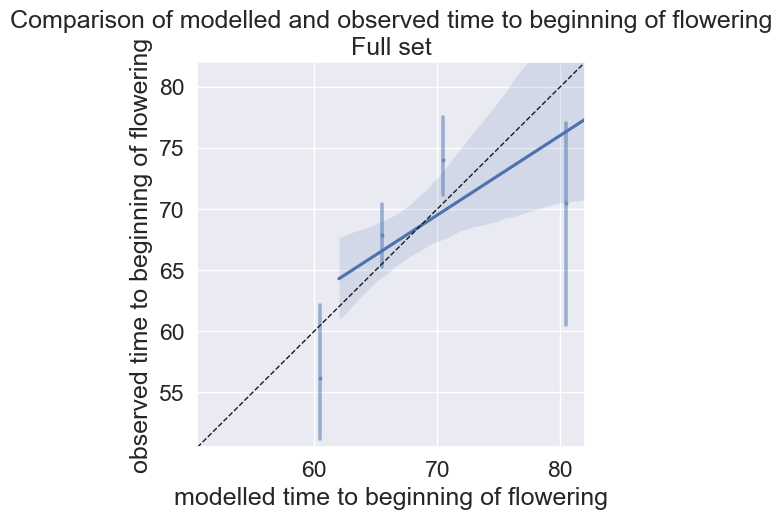

In [61]:
train_a, test_a = train_test_split(ds, test_size=0.2, random_state = 1)
ca_flowering = run_GDD_and_plot([fm_flowering_tc[0][0], 7, 25, 40], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')#np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

In [39]:
fm_flowering_tc[0]

array([ 0.32491715,  7.14326516, 25.08753995, 39.83443631])

In [29]:
fm_flowering_all[0][0]

array([ 0.18833668,  7.5060529 , 25.0202482 , 39.96409198])

In [206]:
np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

array([ 0.5       ,  9.69138985, 31.        , 38.9057878 ])

0 stations out of 3484 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3370603442708511
Bias: 0.01272415081705384 (sign 1.0)
Variance of modelled values: 52.864617728293425


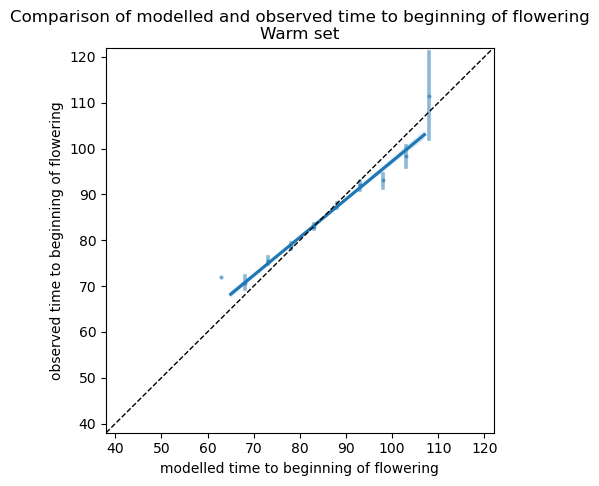

In [60]:
train_a, test_a = train_test_split(ds_warm, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_scatter_plot(fm5s[0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, 
                                        thresholds = [20], title_extra='Warm set')

0 stations out of 2115 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3505500110893277
Bias: 0.015817670696199153 (sign -1.0)
Variance of modelled values: 52.15977374745873


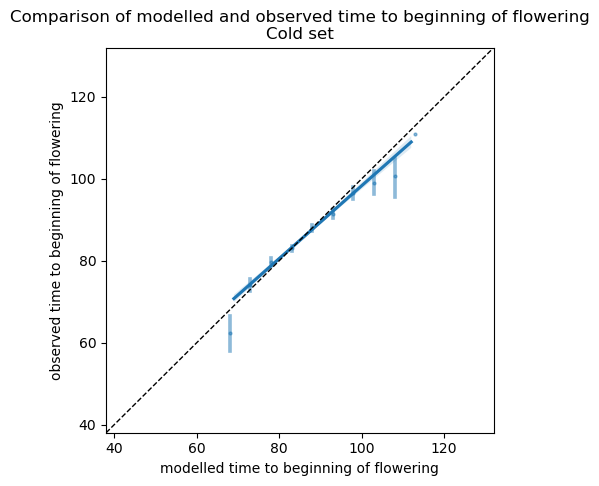

In [61]:
train_a, test_a = train_test_split(ds_cold, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_scatter_plot(fm6s[0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, 
                                        thresholds = [20], title_extra='Cold set')

0 stations out of 5599 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.16468430613847995
Bias: 0.3049706430558551
Variance of modelled values: 98.71395226307803


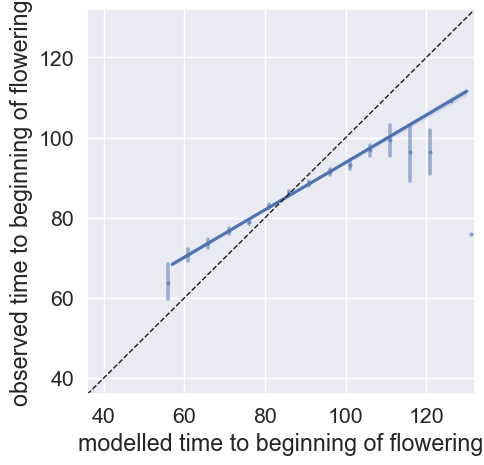

In [41]:
ca_flowering_2nd_min = run_GDD_and_scatter_plot(x_opt, test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, thresholds = [20])

In [23]:
ca_not_matured = ca_ripeness.where(ca_ripeness['modelled time to yellow ripeness'] ==201).dropna()
ca_not_matured = get_station_locations(ca_not_matured, Maize_set.station_data)
ca_not_matured[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/canm_latlon2.csv')
ca_not_matured['Referenzjahr'].unique()

array([2002., 2004., 2010., 2008., 2015., 2007., 2012.])

In [127]:
ca_late_matured = ca_ripeness.where(ca_ripeness['modelled time to yellow ripeness'] > 160).dropna()
ca_late_matured = get_station_locations(ca_late_matured, Maize_set.station_data)
ca_late_matured[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/calm_latlon3.csv')
ca_late_matured['Referenzjahr'].unique()

array([2015., 2010., 2004., 2012.])

In [128]:
ca_bad_flowering = ca_flowering.where(ca_flowering['modelled time to beginning of flowering'] > 100).dropna()
ca_bad_flowering = get_station_locations(ca_bad_flowering, Maize_set.station_data)
ca_bad_flowering[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/cabf_latlon3.csv')

In [65]:
print(run_GDD_and_get_RMSE(fm2s[0], ds2, 't2m', response_type = 'Wang', phase_list = ['yellow ripeness'], new_unfinished_penalisation=True),
      run_GDD_and_get_RMSE(fm2s[0], ds2, 't2m', response_type = 'Wang', phase_list = ['yellow ripeness'], new_unfinished_penalisation=False))

0 7767
21.37204687891441 28.512367772840147


In [128]:
x0 = np.array([11.36, 5.757, 22.68, 25.17, 45])
x0 = np.array([11.36, 5.757, 22.68, 35, 45])
x0 = np.array([1, 5.757, 26, 45])
#x0 = fm2s[0]
x0 = np.ones(20)*0.3
x0 = x
thresholds = [100]
phase_list = ['beginning of flowering']
response_type = 'Spline'
ds = ds_inputs_DE #train
grad_algebraic = run_GDD_and_get_RMSE_derivs(x0, ds.drop_duplicates(), 't2m', response_type = response_type,
                                             thresholds = thresholds, phase_list = phase_list)
for h in [0.001]:#, 0.01, 0.1]:0.00005, 0.0001,
    print(h)
    grads_numeric0 = []
    grads_numeric1 = []
    grads_numeric2 = []
    for x_index in range(len(x0)):
        if x_index % 4 != 1:
            continue
        print(x_index)
        x_plus_h = x0
        x_minus_h =  x0
        h_perturb = [0 for count in range(len(x0))]
        h_perturb[x_index] = h
        h_perturb = np.array(h_perturb)
        x_plus_h = x_plus_h + h_perturb
        x_minus_h = x_minus_h - h_perturb
        #print(x_minus_h, x_plus_h)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/(2*h)
        grads_numeric0.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/h
        grads_numeric1.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/h
        grads_numeric2.append(grad_numeric)
    
    print(grads_numeric0, grads_numeric1, grads_numeric2, grad_algebraic[[n for n in range(1, 19, 4)]])

0.001
1
5
9
13
17


TypeError: list indices must be integers or slices, not list

In [129]:
print(grads_numeric0, grads_numeric1, grads_numeric2, grad_algebraic)#[[n for n in range(1, 19, 4)]])

[0.20991481400578493, 8.066684334754548, 10.293885211700271, -0.027820351355067885, 0.0] [0.3743051021736221, 9.661799040037167, 12.506528390019866, 0.020233057691498857, 0.0] [0.04552452583794775, 6.471569629471929, 8.081242033380676, -0.07587376040163463, 0.0] [-11787.111100291328, -12092.905554133962, -13119.397434783805, -14322.149958013186, -14490.210541700244, -17976.92905523983, -25075.45339599726, -28497.992132376556, -24009.992323399838, -17637.672469076613, -14815.885423637246, -11461.919054935963, -6217.454683318368, -1808.442075708689, -316.0008983405145, -83.416403824503, -3.6557752752794084, -0.0022480797054191563, -0.0, -0.0]
